# Демонстрация автоматического расчета важностей

In [1]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Стандартные библиотеки для анализа
import pandas as pd
pd.options.display.float_format = '{:20,.5f}'.format

from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pylab as pl

import numpy as np
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [3]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import AutoTrees, base_pipe, AutoSelection

In [4]:
import sklearn as sk
import catboost as ctb
import matplotlib as mplot
import autobinary as ab
import numpy as np
import scipy as sc

print('pandas: ', pd.__version__)
print('numpy: ', np.__version__)
print('scipy: ', sc.__version__)
print('sklearn: ', sk.__version__)
print('catboost: ', ctb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

pandas:  1.5.3
numpy:  1.22.2
scipy:  1.7.3
sklearn:  1.1.3
catboost:  1.0.4
matplotlib:  3.7.0
autobinary:  1.0.9


In [5]:
from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=1000, 
    n_features=25, 
    n_informative=7, 
    n_redundant=18, 
    n_classes=2, 
    random_state=42)

sample = pd.DataFrame(X)
sample.columns = [f'feature_{i}' for i in range(len(sample.columns))]

sample['target'] = y

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (1000, 26)


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,target
0,-0.08703,1.35713,-0.60108,-3.36450,-3.38396,2.18352,2.21945,-1.90678,4.09890,1.53230,...,5.43266,1.59238,-1.43742,-2.21700,2.74544,1.07497,1.16129,1.63421,-2.07849,0
1,0.42706,-2.57458,-4.78315,5.21344,-1.14970,3.17040,2.08226,6.94894,-2.68050,0.15669,...,-4.05924,-0.44249,2.91312,-1.87243,-0.68255,-0.75467,-0.35606,-2.74458,2.77727,0


In [6]:
num_columns = sample.drop(columns='target').columns.tolist()

cat_columns = [
]

target = ['target']

In [7]:
X_train, X_val, y_train, y_val = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [8]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns)

Определены только количественные переменные!


In [9]:
params = {
    'learning_rate':0.01,
    'iterations':500,
    'subsample':0.9,
    'colsample_bylevel':0.9,
    'depth':6,
    'loss_function':'Logloss',
    'thread_count':-1,
    'random_state':42,
    'eval_metric':'AUC',
    #'custom_metric':'Logloss',
    'verbose':0}

fit_params = {
    'use_best_model':True,
    'early_stopping_rounds':100, 
    'verbose':100,
    'plot':False}

# создаем экземпляр класса XGBClassifier
catb_model = ctb.CatBoostClassifier(**params)

# задаем стратегию проверки
strat = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42)

# 1. Применение класса `AutoSelection`
* Передаем в параметры: функцию трансформации, количественные и категориальные признаки, параметры обучения, а также модель обучения.
* Атрибутами являются признаковое пространство, целевая метка, название необходимой метрики для оптимизации и название используемого алгоритма.

In [10]:
selection = AutoSelection(
    base_pipe=base_pipe,
    num_columns=num_columns,
    cat_columns=cat_columns,
    main_fit_params=fit_params,
    main_estimator=catb_model,

    X_train=X_train,
    y_train=y_train,
    
    main_metric='gini',
    model_type='catboost')

Определены только количественные переменные!


## 1.1 Описание работы функции `forward_selection`.

- **1.** Сначала обучается модель по кросс-валидационной схеме, которая определяется параметрами `strat/groups`; 

- **2.** Расчитывается средняя метрика по всем последним фолдам;

- **3.** Из упорядоченного по важности списка факторов в модель добавляется по одному фактору, и снова происходит кросс-валидационное обучение;

- **4.** Рассчитываются метрики на фолдах при добавленных признаках и сравниваются со значениями метрик на фолдах при всех фактора;

- **5.** Метод останавливается как только на более, чем половине фолдах значение метрик при добавленных факторов выше, чем при всем списке факторов.

In [11]:
fselection_res = selection.forward_selection(strat=strat)

Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8915944	test1: 0.8652786	best: 0.8652786 (0)	total: 56.4ms	remaining: 28.2s
100:	test: 0.9965051	test1: 0.9955093	best: 0.9955093 (97)	total: 189ms	remaining: 747ms
200:	test: 0.9987500	test1: 0.9969382	best: 0.9971423 (179)	total: 314ms	remaining: 467ms


1it [00:00,  2.03it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 179

Shrink model to first 180 iterations.
BEST ITERATION:  179
gini на обучающей выборке: 99.684
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9361663	test1: 0.9203061	best: 0.9203061 (0)	total: 2.47ms	remaining: 1.23s
100:	test: 0.9975765	test1: 0.9738776	best: 0.9748980 (73)	total: 138ms	remaining: 546ms
200:	test: 0.9991964	test1: 0.9777551	best: 0.9777551 (200)	total: 293ms	remaining: 436ms
300:	test: 0.9998342	test1: 0.9789796	best: 0.9795918 (293)	total: 425ms	remaining: 281ms


2it [00:01,  1.53it/s]

400:	test: 1.0000000	test1: 0.9812245	best: 0.9814286 (385)	total: 554ms	remaining: 137ms
499:	test: 1.0000000	test1: 0.9822449	best: 0.9824490 (465)	total: 678ms	remaining: 0us

bestTest = 0.9824489796
bestIteration = 465

Shrink model to first 466 iterations.
BEST ITERATION:  465
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.490

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9323971	test1: 0.9009184	best: 0.9009184 (0)	total: 2.36ms	remaining: 1.18s
100:	test: 0.9969005	test1: 0.9804082	best: 0.9808163 (90)	total: 129ms	remaining: 510ms
200:	test: 0.9990816	test1: 0.9855102	best: 0.9855102 (199)	total: 262ms	remaining: 390ms


3it [00:01,  1.72it/s]

300:	test: 0.9997704	test1: 0.9859184	best: 0.9867347 (226)	total: 395ms	remaining: 261ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9867346939
bestIteration = 226

Shrink model to first 227 iterations.
BEST ITERATION:  226
gini на обучающей выборке: 99.867
gini на проверочной выборке: 97.347

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9337300	test1: 0.8405102	best: 0.8405102 (0)	total: 1.75ms	remaining: 871ms
100:	test: 0.9966964	test1: 0.9708163	best: 0.9710204 (99)	total: 131ms	remaining: 518ms
200:	test: 0.9992092	test1: 0.9800000	best: 0.9800000 (199)	total: 258ms	remaining: 384ms
300:	test: 0.9997832	test1: 0.9810204	best: 0.9812245 (294)	total: 390ms	remaining: 258ms
400:	test: 0.9999745	test1: 0.9824490	best: 0.9826531 (376)	total: 519ms	remaining: 128ms


4it [00:02,  1.55it/s]

499:	test: 1.0000000	test1: 0.9830612	best: 0.9830612 (489)	total: 650ms	remaining: 0us

bestTest = 0.9830612245
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.612

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9490045	test1: 0.8640816	best: 0.8640816 (0)	total: 1.48ms	remaining: 740ms
100:	test: 0.9968239	test1: 0.9626531	best: 0.9628571 (98)	total: 140ms	remaining: 552ms
200:	test: 0.9992474	test1: 0.9738776	best: 0.9740816 (195)	total: 279ms	remaining: 416ms
300:	test: 0.9997321	test1: 0.9767347	best: 0.9767347 (291)	total: 407ms	remaining: 269ms


5it [00:03,  1.54it/s]


400:	test: 0.9999490	test1: 0.9773469	best: 0.9775510 (383)	total: 539ms	remaining: 133ms
499:	test: 1.0000000	test1: 0.9785714	best: 0.9787755 (471)	total: 671ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 471

Shrink model to first 472 iterations.
BEST ITERATION:  471
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  97.126507
Конец обуения кросс-валидации!

Начало жадного отбора факторов Forward Selection!
Добавление признака feature_17
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8363265	test1: 0.8507859	best: 0.8507859 (0)	total: 2.14ms	remaining: 1.07s


1it [00:00,  8.55it/s]

100:	test: 0.8543240	test1: 0.8689528	best: 0.8700755 (44)	total: 54.2ms	remaining: 214ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8700755256
bestIteration = 44

Shrink model to first 45 iterations.
BEST ITERATION:  44
gini на обучающей выборке: 70.818
gini на проверочной выборке: 74.015

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8415031	test1: 0.8365306	best: 0.8365306 (0)	total: 785us	remaining: 392ms
100:	test: 0.8570709	test1: 0.8577551	best: 0.8591837 (33)	total: 54.1ms	remaining: 214ms


2it [00:00,  8.87it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8591836735
bestIteration = 33

Shrink model to first 34 iterations.
BEST ITERATION:  33
gini на обучающей выборке: 71.310
gini на проверочной выборке: 71.837

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8331548	test1: 0.8154082	best: 0.8154082 (0)	total: 990us	remaining: 494ms


3it [00:00,  8.70it/s]

100:	test: 0.8596028	test1: 0.8586735	best: 0.8604082 (51)	total: 55ms	remaining: 217ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8604081633
bestIteration = 51

Shrink model to first 52 iterations.
BEST ITERATION:  51
gini на обучающей выборке: 71.884
gini на проверочной выборке: 72.082

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8304315	test1: 0.8396939	best: 0.8396939 (0)	total: 655us	remaining: 327ms
100:	test: 0.8558655	test1: 0.8634694	best: 0.8671429 (13)	total: 52ms	remaining: 206ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8671428571
bestIteration = 13

Shrink model to first 14 iterations.
BEST ITERATION:  13
gini на обучающей выборке: 70.767
gini на проверочной выборке: 73.429

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.8526193	t

5it [00:00,  9.47it/s]


100:	test: 0.8674983	test1: 0.8222449	best: 0.8280612 (6)	total: 51.7ms	remaining: 204ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8280612245
bestIteration = 6

Shrink model to first 7 iterations.
BEST ITERATION:  6
gini на обучающей выборке: 73.001
gini на проверочной выборке: 65.612

********************** 5 фолд обучен! ******************************


Количество признаков: 1 => метрика: 71.39485775939279
Добавление признака feature_4
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8829464	test1: 0.9072260	best: 0.9072260 (0)	total: 1.74ms	remaining: 867ms
100:	test: 0.9125638	test1: 0.9176363	best: 0.9176363 (100)	total: 70.9ms	remaining: 280ms
200:	test: 0.9216199	test1: 0.9219228	best: 0.9221270 (188)	total: 138ms	remaining: 206ms


1it [00:00,  3.98it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9221269647
bestIteration = 188

Shrink model to first 189 iterations.
BEST ITERATION:  188
gini на обучающей выборке: 84.031
gini на проверочной выборке: 84.425

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8741948	test1: 0.8636735	best: 0.8636735 (0)	total: 1.25ms	remaining: 626ms
100:	test: 0.9121609	test1: 0.9069388	best: 0.9071429 (78)	total: 79.1ms	remaining: 312ms


2it [00:00,  4.43it/s]

200:	test: 0.9208217	test1: 0.9069388	best: 0.9081633 (106)	total: 159ms	remaining: 236ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9081632653
bestIteration = 106

Shrink model to first 107 iterations.
BEST ITERATION:  106
gini на обучающей выборке: 82.460
gini на проверочной выборке: 81.633

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8902346	test1: 0.8668367	best: 0.8668367 (0)	total: 954us	remaining: 476ms
100:	test: 0.9216380	test1: 0.8710204	best: 0.8839796 (4)	total: 67.6ms	remaining: 267ms


3it [00:00,  5.84it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8839795918
bestIteration = 4

Shrink model to first 5 iterations.
BEST ITERATION:  4
gini на обучающей выборке: 82.537
gini на проверочной выборке: 76.796

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8683529	test1: 0.8159184	best: 0.8159184 (0)	total: 1.2ms	remaining: 596ms


4it [00:00,  6.68it/s]

100:	test: 0.9149415	test1: 0.8885714	best: 0.8943878 (7)	total: 75.6ms	remaining: 299ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8943877551
bestIteration = 7

Shrink model to first 8 iterations.
BEST ITERATION:  7
gini на обучающей выборке: 81.294
gini на проверочной выборке: 78.878

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.8824028	test1: 0.8090816	best: 0.8090816 (0)	total: 1.09ms	remaining: 545ms


5it [00:00,  6.10it/s]


100:	test: 0.9203115	test1: 0.8675510	best: 0.8694898 (31)	total: 76.1ms	remaining: 301ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.8694897959
bestIteration = 31

Shrink model to first 32 iterations.
BEST ITERATION:  31
gini на обучающей выборке: 82.895
gini на проверочной выборке: 73.898

********************** 5 фолд обучен! ******************************


Количество признаков: 2 => метрика: 79.12589491399744
Добавление признака feature_19
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9274107	test1: 0.9394774	best: 0.9394774 (0)	total: 2.67ms	remaining: 1.33s


1it [00:00,  7.05it/s]

100:	test: 0.9695089	test1: 0.9679526	best: 0.9723413 (30)	total: 81ms	remaining: 320ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9723412941
bestIteration = 30

Shrink model to first 31 iterations.
BEST ITERATION:  30
gini на обучающей выборке: 92.180
gini на проверочной выборке: 94.468

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9288384	test1: 0.9044898	best: 0.9044898 (0)	total: 1.37ms	remaining: 686ms
100:	test: 0.9744384	test1: 0.9385714	best: 0.9385714 (100)	total: 79.1ms	remaining: 312ms


2it [00:00,  4.34it/s]

200:	test: 0.9810584	test1: 0.9416327	best: 0.9416327 (166)	total: 153ms	remaining: 228ms
300:	test: 0.9852677	test1: 0.9406122	best: 0.9420408 (215)	total: 228ms	remaining: 151ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9420408163
bestIteration = 215

Shrink model to first 216 iterations.
BEST ITERATION:  215
gini на обучающей выборке: 96.398
gini на проверочной выборке: 88.408

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9239786	test1: 0.9228571	best: 0.9228571 (0)	total: 1.64ms	remaining: 821ms


3it [00:00,  4.88it/s]

100:	test: 0.9730099	test1: 0.9453061	best: 0.9475510 (73)	total: 80.6ms	remaining: 318ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9475510204
bestIteration = 73

Shrink model to first 74 iterations.
BEST ITERATION:  73
gini на обучающей выборке: 94.154
gini на проверочной выборке: 89.510

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9305540	test1: 0.9079592	best: 0.9079592 (0)	total: 1.27ms	remaining: 635ms
100:	test: 0.9732522	test1: 0.9387755	best: 0.9393878 (92)	total: 79.9ms	remaining: 316ms
200:	test: 0.9801656	test1: 0.9408163	best: 0.9408163 (194)	total: 156ms	remaining: 232ms
300:	test: 0.9850636	test1: 0.9440816	best: 0.9440816 (300)	total: 232ms	remaining: 153ms
400:	test: 0.9888519	test1: 0.9469388	best: 0.9469388 (398)	total: 308ms	remaining: 76.1ms


4it [00:01,  3.30it/s]

499:	test: 0.9919132	test1: 0.9475510	best: 0.9483673 (489)	total: 382ms	remaining: 0us

bestTest = 0.9483673469
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 98.319
gini на проверочной выборке: 89.673

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9345846	test1: 0.8612245	best: 0.8612245 (0)	total: 1.09ms	remaining: 547ms
100:	test: 0.9709308	test1: 0.9459184	best: 0.9461224 (98)	total: 75.7ms	remaining: 299ms
200:	test: 0.9794640	test1: 0.9438776	best: 0.9477551 (135)	total: 149ms	remaining: 221ms


5it [00:01,  3.89it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.947755102
bestIteration = 135

Shrink model to first 136 iterations.
BEST ITERATION:  135
gini на обучающей выборке: 94.908
gini на проверочной выборке: 89.551

********************** 5 фолд обучен! ******************************


Количество признаков: 3 => метрика: 90.32222319423789
Добавление признака feature_22
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9098661	test1: 0.9266177	best: 0.9266177 (0)	total: 2.05ms	remaining: 1.02s
100:	test: 0.9818240	test1: 0.9902021	best: 0.9908145 (92)	total: 79.1ms	remaining: 313ms
200:	test: 0.9891327	test1: 0.9908145	best: 0.9914268 (145)	total: 163ms	remaining: 242ms


1it [00:00,  3.99it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9914268218
bestIteration = 145

Shrink model to first 146 iterations.
BEST ITERATION:  145
gini на обучающей выборке: 97.179
gini на проверочной выборке: 98.285

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9169632	test1: 0.9035714	best: 0.9035714 (0)	total: 1.53ms	remaining: 765ms
100:	test: 0.9858544	test1: 0.9626531	best: 0.9632653 (93)	total: 80.1ms	remaining: 316ms


2it [00:00,  3.55it/s]

200:	test: 0.9920662	test1: 0.9630612	best: 0.9638776 (150)	total: 162ms	remaining: 241ms
300:	test: 0.9953061	test1: 0.9630612	best: 0.9644898 (219)	total: 236ms	remaining: 156ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9644897959
bestIteration = 219

Shrink model to first 220 iterations.
BEST ITERATION:  219
gini на обучающей выборке: 98.605
gini на проверочной выборке: 92.898

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9070715	test1: 0.9030612	best: 0.9030612 (0)	total: 1.14ms	remaining: 568ms
100:	test: 0.9857906	test1: 0.9555102	best: 0.9565306 (71)	total: 94.9ms	remaining: 375ms
200:	test: 0.9913392	test1: 0.9585714	best: 0.9585714 (199)	total: 179ms	remaining: 267ms
300:	test: 0.9948469	test1: 0.9608163	best: 0.9616327 (260)	total: 262ms	remaining: 173ms


3it [00:00,  3.10it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9616326531
bestIteration = 260

Shrink model to first 261 iterations.
BEST ITERATION:  260
gini на обучающей выборке: 98.735
gini на проверочной выборке: 92.327

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9161405	test1: 0.8683673	best: 0.8683673 (0)	total: 1.89ms	remaining: 941ms
100:	test: 0.9858034	test1: 0.9444898	best: 0.9448980 (99)	total: 81.9ms	remaining: 323ms
200:	test: 0.9915815	test1: 0.9512245	best: 0.9512245 (200)	total: 160ms	remaining: 238ms
300:	test: 0.9946300	test1: 0.9561224	best: 0.9563265 (299)	total: 238ms	remaining: 158ms
400:	test: 0.9965943	test1: 0.9577551	best: 0.9583673 (368)	total: 318ms	remaining: 78.4ms


4it [00:01,  2.64it/s]

499:	test: 0.9979719	test1: 0.9583673	best: 0.9585714 (410)	total: 393ms	remaining: 0us

bestTest = 0.9585714286
bestIteration = 410

Shrink model to first 411 iterations.
BEST ITERATION:  410
gini на обучающей выборке: 99.360
gini на проверочной выборке: 91.714

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9191954	test1: 0.8662245	best: 0.8662245 (0)	total: 955us	remaining: 477ms
100:	test: 0.9857651	test1: 0.9559184	best: 0.9567347 (88)	total: 75.3ms	remaining: 297ms
200:	test: 0.9920152	test1: 0.9606122	best: 0.9620408 (186)	total: 151ms	remaining: 224ms


5it [00:01,  2.82it/s]


300:	test: 0.9952423	test1: 0.9620408	best: 0.9626531 (284)	total: 232ms	remaining: 153ms
400:	test: 0.9971301	test1: 0.9612245	best: 0.9630612 (316)	total: 310ms	remaining: 76.4ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9630612245
bestIteration = 316

Shrink model to first 317 iterations.
BEST ITERATION:  316
gini на обучающей выборке: 99.138
gini на проверочной выборке: 92.612

********************** 5 фолд обучен! ******************************


Количество признаков: 4 => метрика: 93.56727695364734
Добавление признака feature_18
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9390625	test1: 0.9523372	best: 0.9523372 (0)	total: 2.82ms	remaining: 1.41s
100:	test: 0.9835969	test1: 0.9887732	best: 0.9887732 (100)	total: 92.8ms	remaining: 366ms
200:	test: 0.9903316	test1: 0.9918351	best: 0.9918351 (178)	total: 181ms	remaining: 269ms
300:	test: 0.9949107	test1: 0.9914268	best: 0.9920392 (206)	total: 263ms	remaining: 174ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9920391917
bestIteration = 206

Shrink model to first 207 iterations.
BEST ITERATION:  206


1it [00:00,  3.08it/s]

gini на обучающей выборке: 98.133
gini на проверочной выборке: 98.408

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9275437	test1: 0.9302041	best: 0.9302041 (0)	total: 988us	remaining: 493ms
100:	test: 0.9868238	test1: 0.9657143	best: 0.9657143 (100)	total: 85ms	remaining: 336ms
200:	test: 0.9930611	test1: 0.9655102	best: 0.9667347 (103)	total: 166ms	remaining: 247ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9667346939
bestIteration = 103

Shrink model to first 104 iterations.


2it [00:00,  3.85it/s]

BEST ITERATION:  103
gini на обучающей выборке: 97.418
gini на проверочной выборке: 93.347

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9250182	test1: 0.9254082	best: 0.9254082 (0)	total: 966us	remaining: 482ms
100:	test: 0.9857524	test1: 0.9663265	best: 0.9671429 (83)	total: 86ms	remaining: 340ms


3it [00:00,  4.17it/s]

200:	test: 0.9919387	test1: 0.9669388	best: 0.9677551 (109)	total: 162ms	remaining: 240ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.967755102
bestIteration = 109

Shrink model to first 110 iterations.
BEST ITERATION:  109
gini на обучающей выборке: 97.296
gini на проверочной выборке: 93.551

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9362301	test1: 0.8946939	best: 0.8946939 (0)	total: 1.44ms	remaining: 721ms
100:	test: 0.9866580	test1: 0.9461224	best: 0.9463265 (92)	total: 94ms	remaining: 371ms
200:	test: 0.9923086	test1: 0.9500000	best: 0.9508163 (155)	total: 186ms	remaining: 277ms
300:	test: 0.9958035	test1: 0.9536735	best: 0.9542857 (266)	total: 281ms	remaining: 186ms
400:	test: 0.9978954	test1: 0.9548980	best: 0.9559184 (350)	total: 376ms	remaining: 92.8ms


4it [00:01,  2.76it/s]

499:	test: 0.9989923	test1: 0.9573469	best: 0.9575510 (470)	total: 468ms	remaining: 0us

bestTest = 0.9575510204
bestIteration = 470

Shrink model to first 471 iterations.
BEST ITERATION:  470
gini на обучающей выборке: 99.740
gini на проверочной выборке: 91.510

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9443233	test1: 0.8765306	best: 0.8765306 (0)	total: 1.14ms	remaining: 569ms
100:	test: 0.9865432	test1: 0.9481633	best: 0.9485714 (94)	total: 125ms	remaining: 495ms
200:	test: 0.9925637	test1: 0.9565306	best: 0.9565306 (197)	total: 217ms	remaining: 323ms
300:	test: 0.9960586	test1: 0.9591837	best: 0.9595918 (297)	total: 300ms	remaining: 198ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9595918367
bestIteration = 297

Shrink model to first 298 iterations.
BEST ITERATION:  297


5it [00:01,  2.84it/s]


gini на обучающей выборке: 99.179
gini на проверочной выборке: 91.918

********************** 5 фолд обучен! ******************************


Количество признаков: 5 => метрика: 93.74687378931978
Добавление признака feature_5
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9453380	test1: 0.9469279	best: 0.9469279 (0)	total: 2.46ms	remaining: 1.23s
100:	test: 0.9904209	test1: 0.9938763	best: 0.9938763 (100)	total: 97.2ms	remaining: 384ms
200:	test: 0.9957143	test1: 0.9961217	best: 0.9963258 (184)	total: 183ms	remaining: 273ms
300:	test: 0.9980357	test1: 0.9973464	best: 0.9973464 (267)	total: 265ms	remaining: 175ms
400:	test: 0.9991582	test1: 0.9977546	best: 0.9981629 (369)	total: 349ms	remaining: 86.1ms


1it [00:00,  1.96it/s]

499:	test: 0.9997321	test1: 0.9981629	best: 0.9983670 (409)	total: 434ms	remaining: 0us

bestTest = 0.9983670137
bestIteration = 409

Shrink model to first 410 iterations.
BEST ITERATION:  409
gini на обучающей выборке: 99.849
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9309302	test1: 0.9103061	best: 0.9103061 (0)	total: 1.03ms	remaining: 513ms
100:	test: 0.9930866	test1: 0.9710204	best: 0.9714286 (84)	total: 106ms	remaining: 418ms
200:	test: 0.9971556	test1: 0.9748980	best: 0.9753061 (174)	total: 190ms	remaining: 282ms
300:	test: 0.9987627	test1: 0.9763265	best: 0.9763265 (300)	total: 270ms	remaining: 179ms
400:	test: 0.9995408	test1: 0.9761224	best: 0.9763265 (300)	total: 355ms	remaining: 87.7ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9763265306
bestIteration = 300

Shrink model to first 301 iterations.
BEST ITERATION:  30

2it [00:00,  2.19it/s]

gini на обучающей выборке: 99.753
gini на проверочной выборке: 95.265

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9368423	test1: 0.8926531	best: 0.8926531 (0)	total: 1.22ms	remaining: 608ms
100:	test: 0.9910713	test1: 0.9771429	best: 0.9773469 (99)	total: 81.3ms	remaining: 321ms
200:	test: 0.9958418	test1: 0.9816327	best: 0.9816327 (199)	total: 161ms	remaining: 239ms


3it [00:01,  2.20it/s]

300:	test: 0.9977041	test1: 0.9836735	best: 0.9844898 (287)	total: 247ms	remaining: 163ms
400:	test: 0.9990306	test1: 0.9851020	best: 0.9857143 (362)	total: 330ms	remaining: 81.6ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9857142857
bestIteration = 362

Shrink model to first 363 iterations.
BEST ITERATION:  362
gini на обучающей выборке: 99.712
gini на проверочной выборке: 97.143

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9497634	test1: 0.9328571	best: 0.9328571 (0)	total: 1.14ms	remaining: 571ms
100:	test: 0.9913137	test1: 0.9565306	best: 0.9565306 (100)	total: 87.3ms	remaining: 345ms
200:	test: 0.9965688	test1: 0.9665306	best: 0.9665306 (200)	total: 174ms	remaining: 259ms
300:	test: 0.9984183	test1: 0.9706122	best: 0.9708163 (296)	total: 261ms	remaining: 173ms


4it [00:01,  2.12it/s]

400:	test: 0.9993622	test1: 0.9736735	best: 0.9736735 (398)	total: 344ms	remaining: 84.9ms
499:	test: 0.9997449	test1: 0.9753061	best: 0.9753061 (499)	total: 422ms	remaining: 0us

bestTest = 0.9753061224
bestIteration = 499

BEST ITERATION:  499
gini на обучающей выборке: 99.949
gini на проверочной выборке: 95.061

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9375056	test1: 0.8928571	best: 0.8928571 (0)	total: 1.11ms	remaining: 556ms
100:	test: 0.9913264	test1: 0.9551020	best: 0.9553061 (99)	total: 91.5ms	remaining: 362ms
200:	test: 0.9963903	test1: 0.9663265	best: 0.9667347 (188)	total: 184ms	remaining: 274ms
300:	test: 0.9984566	test1: 0.9722449	best: 0.9722449 (294)	total: 264ms	remaining: 175ms


5it [00:02,  2.10it/s]


400:	test: 0.9994133	test1: 0.9757143	best: 0.9759184 (397)	total: 350ms	remaining: 86.3ms
499:	test: 0.9997449	test1: 0.9771429	best: 0.9771429 (491)	total: 434ms	remaining: 0us

bestTest = 0.9771428571
bestIteration = 491

Shrink model to first 492 iterations.
BEST ITERATION:  491
gini на обучающей выборке: 99.946
gini на проверочной выборке: 95.429

********************** 5 фолд обучен! ******************************


Количество признаков: 6 => метрика: 96.51427238378513
Добавление признака feature_2
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9243750	test1: 0.9440702	best: 0.9440702 (0)	total: 2.02ms	remaining: 1.01s
100:	test: 0.9927423	test1: 0.9944887	best: 0.9953052 (96)	total: 91.1ms	remaining: 360ms
200:	test: 0.9972704	test1: 0.9969382	best: 0.9969382 (189)	total: 178ms	remaining: 264ms
300:	test: 0.9989923	test1: 0.9973464	best: 0.9973464 (278)	total: 268ms	remaining: 177ms
400:	test: 0.9996811	test1: 0.9977546	best: 0.9977546 (321)	total: 353ms	remaining: 87.1ms


1it [00:00,  2.27it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9977546438
bestIteration = 321

Shrink model to first 322 iterations.
BEST ITERATION:  321
gini на обучающей выборке: 99.842
gini на проверочной выборке: 99.551

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9274162	test1: 0.8733673	best: 0.8733673 (0)	total: 1.03ms	remaining: 517ms
100:	test: 0.9957653	test1: 0.9728571	best: 0.9751020 (82)	total: 87.1ms	remaining: 344ms


2it [00:00,  3.32it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9751020408
bestIteration = 82

Shrink model to first 83 iterations.
BEST ITERATION:  82
gini на обучающей выборке: 98.952
gini на проверочной выборке: 95.020

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9233281	test1: 0.9479592	best: 0.9479592 (0)	total: 1.15ms	remaining: 576ms
100:	test: 0.9943367	test1: 0.9797959	best: 0.9800000 (93)	total: 93.2ms	remaining: 368ms


3it [00:01,  2.85it/s]

200:	test: 0.9975255	test1: 0.9863265	best: 0.9863265 (200)	total: 184ms	remaining: 274ms
300:	test: 0.9988648	test1: 0.9881633	best: 0.9887755 (287)	total: 271ms	remaining: 179ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9887755102
bestIteration = 287

Shrink model to first 288 iterations.
BEST ITERATION:  287
gini на обучающей выборке: 99.740
gini на проверочной выборке: 97.755

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9355030	test1: 0.8562245	best: 0.8562245 (0)	total: 1.08ms	remaining: 540ms
100:	test: 0.9945663	test1: 0.9663265	best: 0.9663265 (100)	total: 88.6ms	remaining: 350ms
200:	test: 0.9978826	test1: 0.9746939	best: 0.9751020 (177)	total: 179ms	remaining: 267ms
300:	test: 0.9991837	test1: 0.9771429	best: 0.9775510 (279)	total: 269ms	remaining: 178ms
400:	test: 0.9997066	test1: 0.9783673	best: 0.9783673 (387)	total: 357ms	remaining: 88ms
499:	test: 

4it [00:01,  2.40it/s]

gini на обучающей выборке: 99.990
gini на проверочной выборке: 95.796

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9332134	test1: 0.8445918	best: 0.8445918 (0)	total: 1.02ms	remaining: 509ms
100:	test: 0.9946555	test1: 0.9581633	best: 0.9581633 (100)	total: 90.9ms	remaining: 359ms
200:	test: 0.9977678	test1: 0.9695918	best: 0.9695918 (200)	total: 176ms	remaining: 262ms
300:	test: 0.9990434	test1: 0.9751020	best: 0.9755102 (289)	total: 267ms	remaining: 176ms
400:	test: 0.9997576	test1: 0.9777551	best: 0.9781633 (376)	total: 357ms	remaining: 88.1ms


5it [00:02,  2.39it/s]

499:	test: 0.9999362	test1: 0.9783673	best: 0.9787755 (489)	total: 445ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 99.987
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Количество признаков: 7 => метрика: 96.77549187464331

Количество отобранных признаков: 7
Метрика до отбора: 97.1265 => после отбора: 96.7755
Конец жадного отбора факторов Forward Selection!


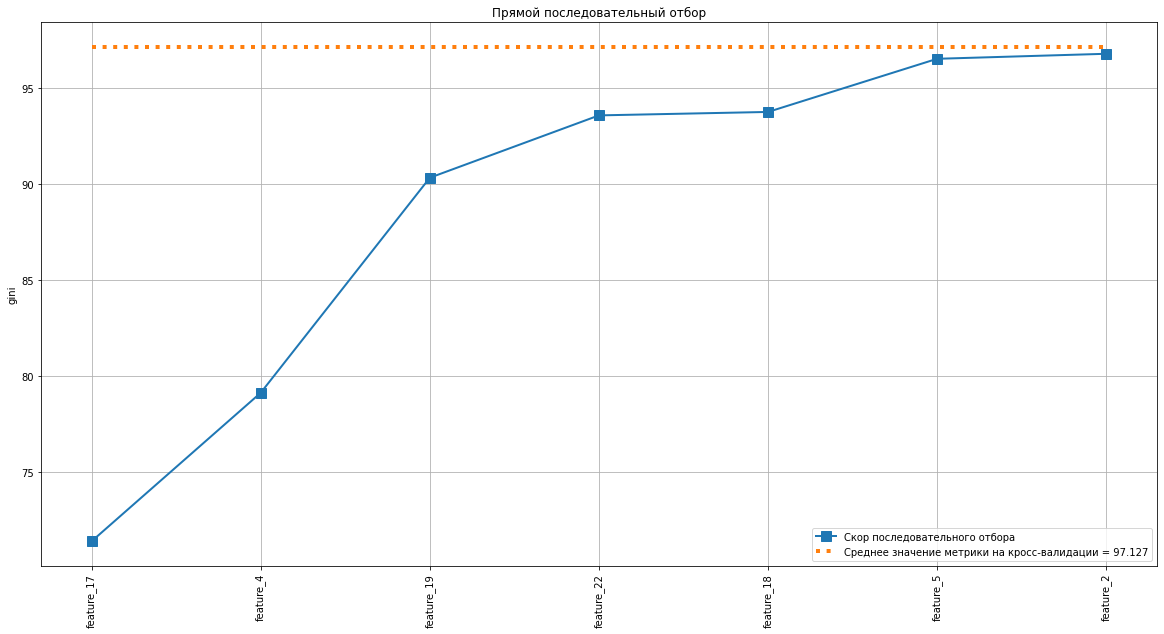

In [12]:
# Отрисовка метода forward_selection.
## Оранжевая линия - среднее значение метрики при всех факторах. Синяя - среднее значение метрики при добавлении факторав по важности.

selection.plot_forward(figsize=(20,10))

## 1.2 Описание работы функции `backward_selection`.
- **1.** Сначала обучается модель по кросс-валидационной схеме, которая определяется параметрами strat / groups;

- **2.** Расчитывается средняя метрика по всем фолдам на тестовых множествах;

- **3.** Из упорядоченного по важности списка факторов из модели удаляется по одному, и снова происходит кросс-валидационное обучение;

- **4.** Рассчитываются метрики на фолдах при удаленных признаках и сравниваются со значениями метрик на фолдах при всех фактора;

- **5.** Метод останавливается в зависимости от параметра `first_degradation`:
    - При значении True - остановка происходит при первом пересечении средней метрики при отобранных факторов относительно всех факторов;
    - При значении False - остановка происходит аналогично методу forward_selection.

In [13]:
bselection_res = selection.backward_selection(strat=strat,first_degradation=True)

Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8915944	test1: 0.8652786	best: 0.8652786 (0)	total: 1.47ms	remaining: 735ms
100:	test: 0.9965051	test1: 0.9955093	best: 0.9955093 (97)	total: 142ms	remaining: 561ms


1it [00:00,  2.23it/s]

200:	test: 0.9987500	test1: 0.9969382	best: 0.9971423 (179)	total: 277ms	remaining: 412ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 179

Shrink model to first 180 iterations.
BEST ITERATION:  179
gini на обучающей выборке: 99.684
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9361663	test1: 0.9203061	best: 0.9203061 (0)	total: 1.6ms	remaining: 799ms
100:	test: 0.9975765	test1: 0.9738776	best: 0.9748980 (73)	total: 135ms	remaining: 533ms
200:	test: 0.9991964	test1: 0.9777551	best: 0.9777551 (200)	total: 267ms	remaining: 398ms
300:	test: 0.9998342	test1: 0.9789796	best: 0.9795918 (293)	total: 404ms	remaining: 267ms
400:	test: 1.0000000	test1: 0.9812245	best: 0.9814286 (385)	total: 536ms	remaining: 132ms


2it [00:01,  1.59it/s]

499:	test: 1.0000000	test1: 0.9822449	best: 0.9824490 (465)	total: 672ms	remaining: 0us

bestTest = 0.9824489796
bestIteration = 465

Shrink model to first 466 iterations.
BEST ITERATION:  465
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.490

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9323971	test1: 0.9009184	best: 0.9009184 (0)	total: 1.62ms	remaining: 810ms
100:	test: 0.9969005	test1: 0.9804082	best: 0.9808163 (90)	total: 137ms	remaining: 540ms
200:	test: 0.9990816	test1: 0.9855102	best: 0.9855102 (199)	total: 264ms	remaining: 392ms
300:	test: 0.9997704	test1: 0.9859184	best: 0.9867347 (226)	total: 398ms	remaining: 263ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9867346939
bestIteration = 226

Shrink model to first 227 iterations.
BEST ITERATION:  226


3it [00:01,  1.75it/s]

gini на обучающей выборке: 99.867
gini на проверочной выборке: 97.347

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9337300	test1: 0.8405102	best: 0.8405102 (0)	total: 1.72ms	remaining: 857ms
100:	test: 0.9966964	test1: 0.9708163	best: 0.9710204 (99)	total: 138ms	remaining: 547ms
200:	test: 0.9992092	test1: 0.9800000	best: 0.9800000 (199)	total: 268ms	remaining: 399ms
300:	test: 0.9997832	test1: 0.9810204	best: 0.9812245 (294)	total: 398ms	remaining: 263ms


4it [00:02,  1.53it/s]

400:	test: 0.9999745	test1: 0.9824490	best: 0.9826531 (376)	total: 525ms	remaining: 130ms
499:	test: 1.0000000	test1: 0.9830612	best: 0.9830612 (489)	total: 677ms	remaining: 0us

bestTest = 0.9830612245
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.612

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9490045	test1: 0.8640816	best: 0.8640816 (0)	total: 1.66ms	remaining: 831ms
100:	test: 0.9968239	test1: 0.9626531	best: 0.9628571 (98)	total: 135ms	remaining: 535ms
200:	test: 0.9992474	test1: 0.9738776	best: 0.9740816 (195)	total: 268ms	remaining: 399ms
300:	test: 0.9997321	test1: 0.9767347	best: 0.9767347 (291)	total: 398ms	remaining: 263ms


5it [00:03,  1.55it/s]


400:	test: 0.9999490	test1: 0.9773469	best: 0.9775510 (383)	total: 526ms	remaining: 130ms
499:	test: 1.0000000	test1: 0.9785714	best: 0.9787755 (471)	total: 651ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 471

Shrink model to first 472 iterations.
BEST ITERATION:  471
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  97.126507
Конец обуения кросс-валидации!

Начало жадного отбора факторов Backward Selection!
Удаление признака 0
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9075064	test1: 0.9204940	best: 0.9204940 (0)	total: 1.39ms	remaining: 691ms
100:	test: 0.9951403	test1: 0.9944887	best: 0.9946928 (80)	total: 138ms	remaining: 545ms
200:	test: 0.9985714	test1: 0.9967340	best: 0.9971423 (182)	total: 287ms	remaining: 427ms


1it [00:00,  2.19it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 182

Shrink model to first 183 iterations.
BEST ITERATION:  182
gini на обучающей выборке: 99.640
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8990166	test1: 0.8917347	best: 0.8917347 (0)	total: 1.39ms	remaining: 695ms
100:	test: 0.9974362	test1: 0.9746939	best: 0.9757143 (90)	total: 128ms	remaining: 506ms
200:	test: 0.9992729	test1: 0.9818367	best: 0.9820408 (199)	total: 254ms	remaining: 379ms
300:	test: 0.9998342	test1: 0.9832653	best: 0.9836735 (290)	total: 381ms	remaining: 252ms
400:	test: 1.0000000	test1: 0.9848980	best: 0.9848980 (396)	total: 514ms	remaining: 127ms


2it [00:01,  1.62it/s]

499:	test: 1.0000000	test1: 0.9861224	best: 0.9861224 (437)	total: 648ms	remaining: 0us

bestTest = 0.986122449
bestIteration = 437

Shrink model to first 438 iterations.
BEST ITERATION:  437
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.224

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9064210	test1: 0.8862245	best: 0.8862245 (0)	total: 1.51ms	remaining: 754ms
100:	test: 0.9973341	test1: 0.9838776	best: 0.9840816 (91)	total: 132ms	remaining: 520ms
200:	test: 0.9992347	test1: 0.9869388	best: 0.9869388 (200)	total: 259ms	remaining: 385ms
300:	test: 0.9998724	test1: 0.9877551	best: 0.9879592 (248)	total: 385ms	remaining: 255ms


3it [00:01,  1.76it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9879591837
bestIteration = 248

Shrink model to first 249 iterations.
BEST ITERATION:  248
gini на обучающей выборке: 99.926
gini на проверочной выборке: 97.592

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9145461	test1: 0.8870408	best: 0.8870408 (0)	total: 1.42ms	remaining: 707ms
100:	test: 0.9973214	test1: 0.9757143	best: 0.9759184 (99)	total: 136ms	remaining: 538ms
200:	test: 0.9994260	test1: 0.9814286	best: 0.9814286 (200)	total: 272ms	remaining: 405ms
300:	test: 0.9998597	test1: 0.9840816	best: 0.9840816 (300)	total: 406ms	remaining: 269ms
400:	test: 0.9999745	test1: 0.9840816	best: 0.9844898 (367)	total: 567ms	remaining: 140ms


4it [00:02,  1.57it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9844897959
bestIteration = 367

Shrink model to first 368 iterations.
BEST ITERATION:  367
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.898

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9194505	test1: 0.8059184	best: 0.8059184 (0)	total: 1.72ms	remaining: 857ms
100:	test: 0.9966581	test1: 0.9626531	best: 0.9632653 (96)	total: 141ms	remaining: 557ms
200:	test: 0.9991964	test1: 0.9748980	best: 0.9748980 (200)	total: 275ms	remaining: 409ms
300:	test: 0.9997704	test1: 0.9775510	best: 0.9777551 (286)	total: 406ms	remaining: 269ms
400:	test: 0.9999490	test1: 0.9787755	best: 0.9789796 (344)	total: 537ms	remaining: 133ms


5it [00:03,  1.57it/s]


499:	test: 1.0000000	test1: 0.9791837	best: 0.9797959 (490)	total: 666ms	remaining: 0us

bestTest = 0.9797959184
bestIteration = 490

Shrink model to first 491 iterations.
BEST ITERATION:  490
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.959

********************** 5 фолд обучен! ******************************


Количество признаков: 24 => метрика: 97.42038483488926
Удаление признака 1
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9282398	test1: 0.8906920	best: 0.8906920 (0)	total: 1.37ms	remaining: 684ms
100:	test: 0.9956505	test1: 0.9946928	best: 0.9948969 (95)	total: 131ms	remaining: 517ms
200:	test: 0.9985969	test1: 0.9967340	best: 0.9967340 (182)	total: 261ms	remaining: 389ms
300:	test: 0.9996046	test1: 0.9977546	best: 0.9977546 (264)	total: 388ms	remaining: 256ms
400:	test: 0.9999235	test1: 0.9979588	best: 0.9979588 (316)	total: 524ms	remaining: 129ms


1it [00:00,  1.34it/s]

499:	test: 1.0000000	test1: 0.9985711	best: 0.9985711 (422)	total: 656ms	remaining: 0us

bestTest = 0.998571137
bestIteration = 422

Shrink model to first 423 iterations.
BEST ITERATION:  422
gini на обучающей выборке: 99.992
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9378245	test1: 0.8919388	best: 0.8919388 (0)	total: 1.39ms	remaining: 696ms
100:	test: 0.9975637	test1: 0.9718367	best: 0.9718367 (98)	total: 134ms	remaining: 529ms
200:	test: 0.9993367	test1: 0.9789796	best: 0.9791837 (182)	total: 275ms	remaining: 409ms
300:	test: 0.9998214	test1: 0.9818367	best: 0.9820408 (296)	total: 412ms	remaining: 272ms
400:	test: 1.0000000	test1: 0.9836735	best: 0.9836735 (400)	total: 550ms	remaining: 136ms


2it [00:01,  1.32it/s]

499:	test: 1.0000000	test1: 0.9844898	best: 0.9844898 (490)	total: 684ms	remaining: 0us

bestTest = 0.9844897959
bestIteration = 490

Shrink model to first 491 iterations.
BEST ITERATION:  490
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.898

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9482965	test1: 0.9153061	best: 0.9153061 (0)	total: 1.51ms	remaining: 754ms
100:	test: 0.9973852	test1: 0.9840816	best: 0.9853061 (81)	total: 142ms	remaining: 562ms
200:	test: 0.9990944	test1: 0.9865306	best: 0.9869388 (195)	total: 277ms	remaining: 413ms
300:	test: 0.9998724	test1: 0.9885714	best: 0.9887755 (259)	total: 412ms	remaining: 272ms
400:	test: 1.0000000	test1: 0.9891837	best: 0.9893878 (397)	total: 539ms	remaining: 133ms


3it [00:02,  1.32it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9893877551
bestIteration = 397

Shrink model to first 398 iterations.
BEST ITERATION:  397
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.878

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9433092	test1: 0.9140816	best: 0.9140816 (0)	total: 1.42ms	remaining: 706ms
100:	test: 0.9966581	test1: 0.9724490	best: 0.9724490 (100)	total: 135ms	remaining: 534ms
200:	test: 0.9991964	test1: 0.9800000	best: 0.9800000 (200)	total: 268ms	remaining: 399ms
300:	test: 0.9998087	test1: 0.9820408	best: 0.9826531 (290)	total: 408ms	remaining: 270ms
400:	test: 0.9999745	test1: 0.9834694	best: 0.9836735 (377)	total: 567ms	remaining: 140ms


4it [00:03,  1.30it/s]

499:	test: 1.0000000	test1: 0.9848980	best: 0.9851020 (463)	total: 698ms	remaining: 0us

bestTest = 0.9851020408
bestIteration = 463

Shrink model to first 464 iterations.
BEST ITERATION:  463
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.020

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9389469	test1: 0.8479592	best: 0.8479592 (0)	total: 1.42ms	remaining: 707ms
100:	test: 0.9965816	test1: 0.9630612	best: 0.9630612 (98)	total: 131ms	remaining: 517ms
200:	test: 0.9991199	test1: 0.9726531	best: 0.9732653 (180)	total: 262ms	remaining: 390ms
300:	test: 0.9996939	test1: 0.9769388	best: 0.9771429 (275)	total: 399ms	remaining: 263ms
400:	test: 0.9999235	test1: 0.9773469	best: 0.9777551 (353)	total: 530ms	remaining: 131ms


5it [00:03,  1.33it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.977755102
bestIteration = 353

Shrink model to first 354 iterations.
BEST ITERATION:  353
gini на обучающей выборке: 99.980
gini на проверочной выборке: 95.551

********************** 5 фолд обучен! ******************************


Количество признаков: 23 => метрика: 97.41223323377115
Удаление признака 2
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9142283	test1: 0.8875281	best: 0.8875281 (0)	total: 1.32ms	remaining: 657ms
100:	test: 0.9965306	test1: 0.9946928	best: 0.9948969 (99)	total: 134ms	remaining: 531ms
200:	test: 0.9988393	test1: 0.9969382	best: 0.9969382 (200)	total: 265ms	remaining: 394ms
300:	test: 0.9996173	test1: 0.9977546	best: 0.9979588 (295)	total: 395ms	remaining: 261ms


1it [00:00,  1.57it/s]

400:	test: 0.9999490	test1: 0.9979588	best: 0.9981629 (310)	total: 525ms	remaining: 130ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9981628904
bestIteration = 310

Shrink model to first 311 iterations.
BEST ITERATION:  310
gini на обучающей выборке: 99.939
gini на проверочной выборке: 99.633

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9222056	test1: 0.8214286	best: 0.8214286 (0)	total: 1.33ms	remaining: 663ms
100:	test: 0.9973214	test1: 0.9746939	best: 0.9753061 (39)	total: 145ms	remaining: 575ms
200:	test: 0.9992474	test1: 0.9795918	best: 0.9797959 (169)	total: 278ms	remaining: 413ms
300:	test: 0.9998342	test1: 0.9804082	best: 0.9808163 (276)	total: 407ms	remaining: 269ms
400:	test: 1.0000000	test1: 0.9826531	best: 0.9828571 (395)	total: 535ms	remaining: 132ms


2it [00:01,  1.35it/s]

499:	test: 1.0000000	test1: 0.9834694	best: 0.9834694 (472)	total: 659ms	remaining: 0us

bestTest = 0.9834693878
bestIteration = 472

Shrink model to first 473 iterations.
BEST ITERATION:  472
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.694

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8896414	test1: 0.9064286	best: 0.9064286 (0)	total: 1.3ms	remaining: 651ms
100:	test: 0.9972194	test1: 0.9820408	best: 0.9830612 (81)	total: 126ms	remaining: 498ms
200:	test: 0.9990816	test1: 0.9853061	best: 0.9855102 (156)	total: 255ms	remaining: 380ms
300:	test: 0.9997959	test1: 0.9879592	best: 0.9879592 (263)	total: 388ms	remaining: 256ms


3it [00:02,  1.36it/s]

400:	test: 0.9999745	test1: 0.9885714	best: 0.9887755 (384)	total: 516ms	remaining: 127ms
499:	test: 1.0000000	test1: 0.9900000	best: 0.9904082 (484)	total: 643ms	remaining: 0us

bestTest = 0.9904081633
bestIteration = 484

Shrink model to first 485 iterations.
BEST ITERATION:  484
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.082

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8886274	test1: 0.8343878	best: 0.8343878 (0)	total: 1.79ms	remaining: 894ms
100:	test: 0.9966326	test1: 0.9773469	best: 0.9773469 (98)	total: 148ms	remaining: 583ms
200:	test: 0.9990434	test1: 0.9822449	best: 0.9822449 (200)	total: 280ms	remaining: 417ms
300:	test: 0.9997194	test1: 0.9846939	best: 0.9851020 (271)	total: 414ms	remaining: 274ms
400:	test: 0.9999745	test1: 0.9857143	best: 0.9861224 (353)	total: 544ms	remaining: 134ms


4it [00:02,  1.39it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.986122449
bestIteration = 353

Shrink model to first 354 iterations.
BEST ITERATION:  353
gini на обучающей выборке: 99.974
gini на проверочной выборке: 97.224

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9257516	test1: 0.8584694	best: 0.8584694 (0)	total: 1.38ms	remaining: 686ms
100:	test: 0.9967219	test1: 0.9536735	best: 0.9536735 (100)	total: 133ms	remaining: 526ms
200:	test: 0.9990816	test1: 0.9708163	best: 0.9708163 (200)	total: 267ms	remaining: 398ms
300:	test: 0.9997704	test1: 0.9751020	best: 0.9755102 (271)	total: 398ms	remaining: 263ms


5it [00:03,  1.38it/s]


400:	test: 0.9999617	test1: 0.9785714	best: 0.9787755 (398)	total: 529ms	remaining: 131ms
499:	test: 1.0000000	test1: 0.9802041	best: 0.9802041 (471)	total: 656ms	remaining: 0us

bestTest = 0.9802040816
bestIteration = 471

Shrink model to first 472 iterations.
BEST ITERATION:  471
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.041

********************** 5 фолд обучен! ******************************


Количество признаков: 22 => метрика: 97.53467888073784
Удаление признака 3
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9204783	test1: 0.8848745	best: 0.8848745 (0)	total: 1.36ms	remaining: 678ms
100:	test: 0.9960714	test1: 0.9961217	best: 0.9963258 (88)	total: 133ms	remaining: 525ms


1it [00:00,  2.78it/s]

200:	test: 0.9986862	test1: 0.9971423	best: 0.9973464 (130)	total: 263ms	remaining: 391ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9973463972
bestIteration = 130

Shrink model to first 131 iterations.
BEST ITERATION:  130
gini на обучающей выборке: 99.436
gini на проверочной выборке: 99.469

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9259557	test1: 0.8953061	best: 0.8953061 (0)	total: 1.64ms	remaining: 819ms
100:	test: 0.9976275	test1: 0.9795918	best: 0.9795918 (100)	total: 132ms	remaining: 520ms
200:	test: 0.9992985	test1: 0.9820408	best: 0.9824490 (199)	total: 262ms	remaining: 389ms
300:	test: 0.9998597	test1: 0.9840816	best: 0.9840816 (239)	total: 394ms	remaining: 260ms
400:	test: 1.0000000	test1: 0.9851020	best: 0.9853061 (379)	total: 532ms	remaining: 131ms


2it [00:01,  1.67it/s]

499:	test: 1.0000000	test1: 0.9861224	best: 0.9863265 (462)	total: 679ms	remaining: 0us

bestTest = 0.9863265306
bestIteration = 462

Shrink model to first 463 iterations.
BEST ITERATION:  462
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.265

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9600314	test1: 0.9006122	best: 0.9006122 (0)	total: 1.7ms	remaining: 849ms
100:	test: 0.9973214	test1: 0.9830612	best: 0.9838776 (94)	total: 138ms	remaining: 544ms
200:	test: 0.9989286	test1: 0.9867347	best: 0.9875510 (178)	total: 269ms	remaining: 400ms
300:	test: 0.9997321	test1: 0.9881633	best: 0.9881633 (291)	total: 402ms	remaining: 266ms
400:	test: 0.9999745	test1: 0.9895918	best: 0.9897959 (351)	total: 534ms	remaining: 132ms


3it [00:01,  1.50it/s]

499:	test: 1.0000000	test1: 0.9906122	best: 0.9906122 (444)	total: 664ms	remaining: 0us

bestTest = 0.9906122449
bestIteration = 444

Shrink model to first 445 iterations.
BEST ITERATION:  444
gini на обучающей выборке: 99.997
gini на проверочной выборке: 98.122

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9472442	test1: 0.8560204	best: 0.8560204 (0)	total: 1.55ms	remaining: 773ms
100:	test: 0.9965051	test1: 0.9742857	best: 0.9744898 (98)	total: 134ms	remaining: 528ms
200:	test: 0.9990689	test1: 0.9802041	best: 0.9802041 (199)	total: 269ms	remaining: 400ms
300:	test: 0.9997576	test1: 0.9832653	best: 0.9832653 (298)	total: 403ms	remaining: 266ms


4it [00:02,  1.55it/s]

400:	test: 0.9999745	test1: 0.9828571	best: 0.9834694 (303)	total: 532ms	remaining: 131ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9834693878
bestIteration = 303

Shrink model to first 304 iterations.
BEST ITERATION:  303
gini на обучающей выборке: 99.954
gini на проверочной выборке: 96.694

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9577418	test1: 0.8572449	best: 0.8572449 (0)	total: 1.35ms	remaining: 672ms
100:	test: 0.9968750	test1: 0.9622449	best: 0.9624490 (97)	total: 137ms	remaining: 543ms
200:	test: 0.9991199	test1: 0.9700000	best: 0.9702041 (197)	total: 281ms	remaining: 418ms
300:	test: 0.9996811	test1: 0.9757143	best: 0.9761224 (286)	total: 414ms	remaining: 274ms
400:	test: 0.9999617	test1: 0.9775510	best: 0.9775510 (366)	total: 544ms	remaining: 134ms


5it [00:03,  1.54it/s]


499:	test: 1.0000000	test1: 0.9781633	best: 0.9783673 (467)	total: 678ms	remaining: 0us

bestTest = 0.9783673469
bestIteration = 467

Shrink model to first 468 iterations.
BEST ITERATION:  467
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.673

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.4448762971202
Удаление признака 4
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9533929	test1: 0.9567259	best: 0.9567259 (0)	total: 1.55ms	remaining: 774ms
100:	test: 0.9962628	test1: 0.9959175	best: 0.9959175 (100)	total: 133ms	remaining: 526ms
200:	test: 0.9985714	test1: 0.9969382	best: 0.9971423 (199)	total: 292ms	remaining: 434ms


1it [00:00,  1.91it/s]

300:	test: 0.9995026	test1: 0.9975505	best: 0.9975505 (217)	total: 430ms	remaining: 284ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9975505205
bestIteration = 217

Shrink model to first 218 iterations.
BEST ITERATION:  217
gini на обучающей выборке: 99.758
gini на проверочной выборке: 99.510

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9162936	test1: 0.9120408	best: 0.9120408 (0)	total: 1.34ms	remaining: 669ms
100:	test: 0.9975893	test1: 0.9744898	best: 0.9744898 (100)	total: 136ms	remaining: 537ms
200:	test: 0.9991326	test1: 0.9808163	best: 0.9810204 (190)	total: 273ms	remaining: 405ms
300:	test: 0.9997704	test1: 0.9832653	best: 0.9834694 (291)	total: 401ms	remaining: 265ms
400:	test: 0.9999872	test1: 0.9840816	best: 0.9848980 (378)	total: 534ms	remaining: 132ms


2it [00:01,  1.52it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9848979592
bestIteration = 378

Shrink model to first 379 iterations.
BEST ITERATION:  378
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9509624	test1: 0.8611224	best: 0.8611224 (0)	total: 1.31ms	remaining: 653ms
100:	test: 0.9973341	test1: 0.9836735	best: 0.9836735 (100)	total: 130ms	remaining: 514ms
200:	test: 0.9990051	test1: 0.9863265	best: 0.9871429 (176)	total: 262ms	remaining: 389ms


3it [00:01,  1.82it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9871428571
bestIteration = 176

Shrink model to first 177 iterations.
BEST ITERATION:  176
gini на обучающей выборке: 99.735
gini на проверочной выборке: 97.429

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9346038	test1: 0.9052041	best: 0.9052041 (0)	total: 1.28ms	remaining: 639ms
100:	test: 0.9965178	test1: 0.9783673	best: 0.9783673 (100)	total: 136ms	remaining: 536ms
200:	test: 0.9992602	test1: 0.9816327	best: 0.9820408 (168)	total: 271ms	remaining: 403ms
300:	test: 0.9998087	test1: 0.9861224	best: 0.9863265 (294)	total: 402ms	remaining: 266ms


4it [00:02,  1.75it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9863265306
bestIteration = 294

Shrink model to first 295 iterations.
BEST ITERATION:  294
gini на обучающей выборке: 99.959
gini на проверочной выборке: 97.265

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9465682	test1: 0.8870408	best: 0.8870408 (0)	total: 3.48ms	remaining: 1.74s
100:	test: 0.9963775	test1: 0.9559184	best: 0.9559184 (99)	total: 150ms	remaining: 592ms
200:	test: 0.9991454	test1: 0.9710204	best: 0.9716327 (192)	total: 285ms	remaining: 424ms
300:	test: 0.9997832	test1: 0.9746939	best: 0.9746939 (290)	total: 423ms	remaining: 280ms
400:	test: 0.9999362	test1: 0.9769388	best: 0.9771429 (393)	total: 558ms	remaining: 138ms


5it [00:03,  1.62it/s]


499:	test: 0.9999872	test1: 0.9773469	best: 0.9777551 (429)	total: 693ms	remaining: 0us

bestTest = 0.977755102
bestIteration = 429

Shrink model to first 430 iterations.
BEST ITERATION:  429
gini на обучающей выборке: 99.995
gini на проверочной выборке: 95.551

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.3469187797593
Удаление признака 5
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400638	test1: 0.9157991	best: 0.9157991 (0)	total: 1.28ms	remaining: 637ms
100:	test: 0.9960459	test1: 0.9961217	best: 0.9961217 (100)	total: 134ms	remaining: 529ms
200:	test: 0.9987755	test1: 0.9979588	best: 0.9981629 (193)	total: 281ms	remaining: 418ms


1it [00:00,  2.06it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9981628904
bestIteration = 193

Shrink model to first 194 iterations.
BEST ITERATION:  193
gini на обучающей выборке: 99.719
gini на проверочной выборке: 99.633

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9465491	test1: 0.9187755	best: 0.9187755 (0)	total: 1.27ms	remaining: 633ms
100:	test: 0.9971811	test1: 0.9810204	best: 0.9810204 (100)	total: 141ms	remaining: 558ms
200:	test: 0.9991199	test1: 0.9846939	best: 0.9846939 (200)	total: 287ms	remaining: 427ms
300:	test: 0.9998087	test1: 0.9846939	best: 0.9848980 (253)	total: 434ms	remaining: 287ms


2it [00:01,  1.78it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9848979592
bestIteration = 253

Shrink model to first 254 iterations.
BEST ITERATION:  253
gini на обучающей выборке: 99.918
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9314022	test1: 0.8615306	best: 0.8615306 (0)	total: 1.27ms	remaining: 636ms
100:	test: 0.9973469	test1: 0.9830612	best: 0.9836735 (96)	total: 146ms	remaining: 577ms
200:	test: 0.9991964	test1: 0.9873469	best: 0.9875510 (198)	total: 284ms	remaining: 423ms
300:	test: 0.9997832	test1: 0.9889796	best: 0.9891837 (251)	total: 419ms	remaining: 277ms
400:	test: 0.9999745	test1: 0.9902041	best: 0.9904082 (385)	total: 548ms	remaining: 135ms


3it [00:01,  1.55it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9904081633
bestIteration = 385

Shrink model to first 386 iterations.
BEST ITERATION:  385
gini на обучающей выборке: 99.995
gini на проверочной выборке: 98.082

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9251457	test1: 0.8767347	best: 0.8767347 (0)	total: 1.38ms	remaining: 687ms
100:	test: 0.9965306	test1: 0.9800000	best: 0.9800000 (100)	total: 134ms	remaining: 530ms
200:	test: 0.9990944	test1: 0.9838776	best: 0.9838776 (172)	total: 268ms	remaining: 398ms
300:	test: 0.9997832	test1: 0.9865306	best: 0.9865306 (291)	total: 424ms	remaining: 280ms
400:	test: 0.9999745	test1: 0.9863265	best: 0.9867347 (315)	total: 553ms	remaining: 136ms


4it [00:02,  1.44it/s]

499:	test: 1.0000000	test1: 0.9871429	best: 0.9873469 (467)	total: 682ms	remaining: 0us

bestTest = 0.9873469388
bestIteration = 467

Shrink model to first 468 iterations.
BEST ITERATION:  467
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.469

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9505861	test1: 0.8131633	best: 0.8131633 (0)	total: 1.39ms	remaining: 692ms
100:	test: 0.9972576	test1: 0.9614286	best: 0.9614286 (100)	total: 135ms	remaining: 532ms
200:	test: 0.9992729	test1: 0.9716327	best: 0.9718367 (198)	total: 268ms	remaining: 399ms
300:	test: 0.9998724	test1: 0.9746939	best: 0.9748980 (289)	total: 401ms	remaining: 265ms
400:	test: 0.9999617	test1: 0.9785714	best: 0.9785714 (394)	total: 535ms	remaining: 132ms


5it [00:03,  1.48it/s]


499:	test: 1.0000000	test1: 0.9795918	best: 0.9795918 (485)	total: 670ms	remaining: 0us

bestTest = 0.9795918367
bestIteration = 485

Shrink model to first 486 iterations.
BEST ITERATION:  485
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.918

********************** 5 фолд обучен! ******************************


Количество признаков: 19 => метрика: 97.61631153379906
Удаление признака 6
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9440306	test1: 0.9188610	best: 0.9188610 (0)	total: 1.2ms	remaining: 598ms
100:	test: 0.9960332	test1: 0.9961217	best: 0.9963258 (98)	total: 130ms	remaining: 514ms
200:	test: 0.9986735	test1: 0.9979588	best: 0.9979588 (191)	total: 277ms	remaining: 412ms


1it [00:00,  1.94it/s]

300:	test: 0.9995153	test1: 0.9983670	best: 0.9983670 (229)	total: 409ms	remaining: 270ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9983670137
bestIteration = 229

Shrink model to first 230 iterations.
BEST ITERATION:  229
gini на обучающей выборке: 99.806
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9701272	test1: 0.9427551	best: 0.9427551 (0)	total: 1.37ms	remaining: 685ms


2it [00:00,  3.06it/s]

100:	test: 0.9970663	test1: 0.9726531	best: 0.9753061 (14)	total: 133ms	remaining: 524ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9753061224
bestIteration = 14

Shrink model to first 15 iterations.
BEST ITERATION:  14
gini на обучающей выборке: 98.472
gini на проверочной выборке: 95.061

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9366637	test1: 0.9574490	best: 0.9574490 (0)	total: 1.21ms	remaining: 605ms
100:	test: 0.9965943	test1: 0.9834694	best: 0.9836735 (92)	total: 136ms	remaining: 536ms
200:	test: 0.9989286	test1: 0.9871429	best: 0.9871429 (199)	total: 267ms	remaining: 397ms
300:	test: 0.9997704	test1: 0.9883673	best: 0.9885714 (297)	total: 397ms	remaining: 263ms
400:	test: 0.9999745	test1: 0.9881633	best: 0.9887755 (345)	total: 525ms	remaining: 130ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9887755102
bestIteration = 345

Shrin

3it [00:01,  2.08it/s]

BEST ITERATION:  345
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.755

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9599995	test1: 0.9147959	best: 0.9147959 (0)	total: 1.23ms	remaining: 614ms
100:	test: 0.9963775	test1: 0.9793878	best: 0.9797959 (95)	total: 132ms	remaining: 521ms
200:	test: 0.9988520	test1: 0.9824490	best: 0.9824490 (176)	total: 265ms	remaining: 394ms
300:	test: 0.9997066	test1: 0.9842857	best: 0.9846939 (287)	total: 398ms	remaining: 263ms
400:	test: 0.9999745	test1: 0.9857143	best: 0.9857143 (395)	total: 530ms	remaining: 131ms


4it [00:02,  1.71it/s]

499:	test: 1.0000000	test1: 0.9846939	best: 0.9859184 (411)	total: 658ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 411

Shrink model to first 412 iterations.
BEST ITERATION:  411
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.184

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9534624	test1: 0.8572449	best: 0.8572449 (0)	total: 1.22ms	remaining: 608ms
100:	test: 0.9966836	test1: 0.9530612	best: 0.9530612 (100)	total: 141ms	remaining: 558ms
200:	test: 0.9991199	test1: 0.9683673	best: 0.9683673 (200)	total: 281ms	remaining: 417ms
300:	test: 0.9997576	test1: 0.9738776	best: 0.9738776 (299)	total: 410ms	remaining: 271ms
400:	test: 0.9999362	test1: 0.9765306	best: 0.9769388 (374)	total: 540ms	remaining: 133ms


5it [00:02,  1.74it/s]


499:	test: 1.0000000	test1: 0.9773469	best: 0.9779592 (474)	total: 667ms	remaining: 0us

bestTest = 0.9779591837
bestIteration = 474

Shrink model to first 475 iterations.
BEST ITERATION:  474
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.592

********************** 5 фолд обучен! ******************************


Количество признаков: 18 => метрика: 97.0530478939892
Удаление признака 7
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9388967	test1: 0.9402939	best: 0.9402939 (0)	total: 1.62ms	remaining: 810ms
100:	test: 0.9961607	test1: 0.9957134	best: 0.9957134 (91)	total: 151ms	remaining: 597ms
200:	test: 0.9986862	test1: 0.9977546	best: 0.9977546 (200)	total: 279ms	remaining: 415ms
300:	test: 0.9995408	test1: 0.9979588	best: 0.9981629 (248)	total: 408ms	remaining: 270ms


1it [00:00,  1.85it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9981628904
bestIteration = 248

Shrink model to first 249 iterations.
BEST ITERATION:  248
gini на обучающей выборке: 99.839
gini на проверочной выборке: 99.633

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9528502	test1: 0.9148980	best: 0.9148980 (0)	total: 1.23ms	remaining: 615ms
100:	test: 0.9973469	test1: 0.9761224	best: 0.9763265 (95)	total: 134ms	remaining: 529ms
200:	test: 0.9991582	test1: 0.9806122	best: 0.9806122 (198)	total: 287ms	remaining: 427ms
300:	test: 0.9997576	test1: 0.9830612	best: 0.9830612 (297)	total: 416ms	remaining: 275ms
400:	test: 0.9999872	test1: 0.9848980	best: 0.9851020 (360)	total: 547ms	remaining: 135ms


2it [00:01,  1.55it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9851020408
bestIteration = 360

Shrink model to first 361 iterations.
BEST ITERATION:  360
gini на обучающей выборке: 99.987
gini на проверочной выборке: 97.020

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9484050	test1: 0.8974490	best: 0.8974490 (0)	total: 1.68ms	remaining: 837ms
100:	test: 0.9968622	test1: 0.9859184	best: 0.9859184 (100)	total: 135ms	remaining: 534ms
200:	test: 0.9990434	test1: 0.9879592	best: 0.9879592 (194)	total: 263ms	remaining: 392ms
300:	test: 0.9997576	test1: 0.9893878	best: 0.9893878 (298)	total: 390ms	remaining: 258ms
400:	test: 0.9999745	test1: 0.9906122	best: 0.9910204 (389)	total: 532ms	remaining: 131ms


3it [00:02,  1.45it/s]

499:	test: 1.0000000	test1: 0.9918367	best: 0.9920408 (453)	total: 660ms	remaining: 0us

bestTest = 0.9920408163
bestIteration = 453

Shrink model to first 454 iterations.
BEST ITERATION:  453
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.408

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9500695	test1: 0.9436735	best: 0.9436735 (0)	total: 1.26ms	remaining: 628ms
100:	test: 0.9963903	test1: 0.9759184	best: 0.9763265 (91)	total: 151ms	remaining: 596ms
200:	test: 0.9989413	test1: 0.9830612	best: 0.9832653 (198)	total: 277ms	remaining: 412ms
300:	test: 0.9997704	test1: 0.9863265	best: 0.9863265 (299)	total: 404ms	remaining: 267ms
400:	test: 0.9999745	test1: 0.9865306	best: 0.9869388 (375)	total: 531ms	remaining: 131ms


4it [00:02,  1.43it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9869387755
bestIteration = 375

Shrink model to first 376 iterations.
BEST ITERATION:  375
gini на обучающей выборке: 99.992
gini на проверочной выборке: 97.388

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9578183	test1: 0.8800000	best: 0.8800000 (0)	total: 1.41ms	remaining: 701ms
100:	test: 0.9966454	test1: 0.9604082	best: 0.9606122 (14)	total: 148ms	remaining: 586ms
200:	test: 0.9990434	test1: 0.9710204	best: 0.9710204 (200)	total: 286ms	remaining: 425ms
300:	test: 0.9997066	test1: 0.9753061	best: 0.9755102 (292)	total: 415ms	remaining: 274ms
400:	test: 0.9999235	test1: 0.9781633	best: 0.9785714 (370)	total: 547ms	remaining: 135ms


5it [00:03,  1.43it/s]


499:	test: 0.9999872	test1: 0.9781633	best: 0.9793878 (460)	total: 685ms	remaining: 0us

bestTest = 0.9793877551
bestIteration = 460

Shrink model to first 461 iterations.
BEST ITERATION:  460
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.878

********************** 5 фолд обучен! ******************************


Количество признаков: 17 => метрика: 97.6652911256358
Удаление признака 8
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9405867	test1: 0.9697898	best: 0.9697898 (0)	total: 1.66ms	remaining: 826ms
100:	test: 0.9955485	test1: 0.9953052	best: 0.9957134 (94)	total: 127ms	remaining: 502ms
200:	test: 0.9985587	test1: 0.9977546	best: 0.9977546 (197)	total: 255ms	remaining: 379ms
300:	test: 0.9995281	test1: 0.9981629	best: 0.9981629 (269)	total: 380ms	remaining: 251ms
400:	test: 0.9999362	test1: 0.9985711	best: 0.9987753 (378)	total: 505ms	remaining: 125ms


1it [00:00,  1.45it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9987752603
bestIteration = 378

Shrink model to first 379 iterations.
BEST ITERATION:  378
gini на обучающей выборке: 99.969
gini на проверочной выборке: 99.755

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9704078	test1: 0.9073469	best: 0.9073469 (0)	total: 1.39ms	remaining: 693ms
100:	test: 0.9975255	test1: 0.9767347	best: 0.9771429 (95)	total: 127ms	remaining: 502ms
200:	test: 0.9991709	test1: 0.9802041	best: 0.9806122 (165)	total: 253ms	remaining: 376ms
300:	test: 0.9997959	test1: 0.9836735	best: 0.9836735 (298)	total: 375ms	remaining: 248ms
400:	test: 0.9999872	test1: 0.9857143	best: 0.9861224 (382)	total: 494ms	remaining: 122ms


2it [00:01,  1.46it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.986122449
bestIteration = 382

Shrink model to first 383 iterations.
BEST ITERATION:  382
gini на обучающей выборке: 99.992
gini на проверочной выборке: 97.224

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9557584	test1: 0.9285714	best: 0.9285714 (0)	total: 1.39ms	remaining: 694ms
100:	test: 0.9970280	test1: 0.9818367	best: 0.9820408 (97)	total: 129ms	remaining: 511ms
200:	test: 0.9990944	test1: 0.9867347	best: 0.9869388 (199)	total: 274ms	remaining: 408ms
300:	test: 0.9997832	test1: 0.9885714	best: 0.9885714 (268)	total: 398ms	remaining: 263ms


3it [00:02,  1.50it/s]

400:	test: 0.9999745	test1: 0.9891837	best: 0.9893878 (332)	total: 523ms	remaining: 129ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9893877551
bestIteration = 332

Shrink model to first 333 iterations.
BEST ITERATION:  332
gini на обучающей выборке: 99.980
gini на проверочной выборке: 97.878

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9518170	test1: 0.9177551	best: 0.9177551 (0)	total: 1.5ms	remaining: 747ms
100:	test: 0.9961989	test1: 0.9714286	best: 0.9716327 (94)	total: 131ms	remaining: 518ms
200:	test: 0.9991071	test1: 0.9810204	best: 0.9812245 (191)	total: 257ms	remaining: 383ms
300:	test: 0.9997704	test1: 0.9836735	best: 0.9838776 (295)	total: 385ms	remaining: 255ms
400:	test: 0.9999745	test1: 0.9859184	best: 0.9861224 (387)	total: 512ms	remaining: 126ms


4it [00:02,  1.45it/s]

499:	test: 1.0000000	test1: 0.9855102	best: 0.9863265 (482)	total: 634ms	remaining: 0us

bestTest = 0.9863265306
bestIteration = 482

Shrink model to first 483 iterations.
BEST ITERATION:  482
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.265

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9489534	test1: 0.8762245	best: 0.8762245 (0)	total: 1.49ms	remaining: 742ms
100:	test: 0.9962882	test1: 0.9646939	best: 0.9646939 (99)	total: 129ms	remaining: 508ms
200:	test: 0.9990434	test1: 0.9755102	best: 0.9761224 (196)	total: 277ms	remaining: 413ms
300:	test: 0.9996556	test1: 0.9781633	best: 0.9783673 (279)	total: 405ms	remaining: 268ms
400:	test: 0.9999362	test1: 0.9804082	best: 0.9810204 (359)	total: 528ms	remaining: 130ms


5it [00:03,  1.44it/s]


499:	test: 0.9999872	test1: 0.9816327	best: 0.9818367 (497)	total: 650ms	remaining: 0us

bestTest = 0.9818367347
bestIteration = 497

Shrink model to first 498 iterations.
BEST ITERATION:  497
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.367

********************** 5 фолд обучен! ******************************


Количество признаков: 16 => метрика: 97.69794918579801
Удаление признака 9
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9468878	test1: 0.9703001	best: 0.9703001 (0)	total: 1.43ms	remaining: 716ms
100:	test: 0.9957526	test1: 0.9961217	best: 0.9961217 (100)	total: 125ms	remaining: 496ms
200:	test: 0.9986862	test1: 0.9973464	best: 0.9975505 (137)	total: 249ms	remaining: 370ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9975505205
bestIteration = 137

Shrink model to first 138 iterations.
BEST ITERATION:  137


1it [00:00,  2.81it/s]

gini на обучающей выборке: 99.418
gini на проверочной выборке: 99.510

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9502034	test1: 0.9181633	best: 0.9181633 (0)	total: 1.35ms	remaining: 676ms
100:	test: 0.9972321	test1: 0.9755102	best: 0.9761224 (87)	total: 132ms	remaining: 520ms
200:	test: 0.9992092	test1: 0.9797959	best: 0.9800000 (192)	total: 259ms	remaining: 385ms
300:	test: 0.9998342	test1: 0.9816327	best: 0.9820408 (274)	total: 385ms	remaining: 255ms
400:	test: 0.9999745	test1: 0.9828571	best: 0.9834694 (353)	total: 510ms	remaining: 126ms


2it [00:01,  1.74it/s]

499:	test: 1.0000000	test1: 0.9848980	best: 0.9848980 (494)	total: 635ms	remaining: 0us

bestTest = 0.9848979592
bestIteration = 494

Shrink model to first 495 iterations.
BEST ITERATION:  494
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9484751	test1: 0.9345918	best: 0.9345918 (0)	total: 1.11ms	remaining: 553ms
100:	test: 0.9972449	test1: 0.9838776	best: 0.9859184 (26)	total: 128ms	remaining: 506ms
200:	test: 0.9990306	test1: 0.9879592	best: 0.9879592 (198)	total: 248ms	remaining: 370ms
300:	test: 0.9998087	test1: 0.9908163	best: 0.9908163 (273)	total: 356ms	remaining: 236ms
400:	test: 0.9999745	test1: 0.9916327	best: 0.9916327 (339)	total: 476ms	remaining: 117ms


3it [00:01,  1.61it/s]

499:	test: 1.0000000	test1: 0.9916327	best: 0.9918367 (403)	total: 595ms	remaining: 0us

bestTest = 0.9918367347
bestIteration = 403

Shrink model to first 404 iterations.
BEST ITERATION:  403
gini на обучающей выборке: 99.997
gini на проверочной выборке: 98.367

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9478692	test1: 0.8988776	best: 0.8988776 (0)	total: 1.26ms	remaining: 630ms
100:	test: 0.9964795	test1: 0.9767347	best: 0.9779592 (89)	total: 120ms	remaining: 474ms
200:	test: 0.9992347	test1: 0.9826531	best: 0.9826531 (200)	total: 244ms	remaining: 362ms
300:	test: 0.9998724	test1: 0.9853061	best: 0.9859184 (280)	total: 367ms	remaining: 243ms
400:	test: 0.9999872	test1: 0.9867347	best: 0.9867347 (342)	total: 488ms	remaining: 120ms


4it [00:02,  1.54it/s]

499:	test: 1.0000000	test1: 0.9875510	best: 0.9877551 (456)	total: 603ms	remaining: 0us

bestTest = 0.987755102
bestIteration = 456

Shrink model to first 457 iterations.
BEST ITERATION:  456
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.551

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9488195	test1: 0.8968367	best: 0.8968367 (0)	total: 1.41ms	remaining: 705ms
100:	test: 0.9967347	test1: 0.9616327	best: 0.9616327 (95)	total: 126ms	remaining: 497ms
200:	test: 0.9991964	test1: 0.9738776	best: 0.9742857 (199)	total: 247ms	remaining: 368ms
300:	test: 0.9997959	test1: 0.9795918	best: 0.9797959 (292)	total: 368ms	remaining: 244ms


5it [00:03,  1.66it/s]


400:	test: 0.9999617	test1: 0.9795918	best: 0.9800000 (302)	total: 488ms	remaining: 120ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.98
bestIteration = 302

Shrink model to first 303 iterations.
BEST ITERATION:  302
gini на обучающей выборке: 99.959
gini на проверочной выборке: 96.000

********************** 5 фолд обучен! ******************************


Количество признаков: 15 => метрика: 97.68161265731032
Удаление признака 10
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9415561	test1: 0.9505001	best: 0.9505001 (0)	total: 1.82ms	remaining: 909ms
100:	test: 0.9963520	test1: 0.9961217	best: 0.9961217 (78)	total: 136ms	remaining: 538ms
200:	test: 0.9987117	test1: 0.9973464	best: 0.9975505 (187)	total: 244ms	remaining: 363ms


1it [00:00,  2.15it/s]

300:	test: 0.9995918	test1: 0.9981629	best: 0.9983670 (250)	total: 346ms	remaining: 229ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9983670137
bestIteration = 250

Shrink model to first 251 iterations.
BEST ITERATION:  250
gini на обучающей выборке: 99.852
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9579012	test1: 0.8803061	best: 0.8803061 (0)	total: 1.25ms	remaining: 625ms
100:	test: 0.9976020	test1: 0.9759184	best: 0.9759184 (85)	total: 114ms	remaining: 450ms
200:	test: 0.9990178	test1: 0.9795918	best: 0.9800000 (196)	total: 220ms	remaining: 327ms
300:	test: 0.9997704	test1: 0.9834694	best: 0.9834694 (298)	total: 327ms	remaining: 216ms
400:	test: 0.9999872	test1: 0.9836735	best: 0.9842857 (374)	total: 442ms	remaining: 109ms


2it [00:01,  1.76it/s]

499:	test: 1.0000000	test1: 0.9846939	best: 0.9848980 (457)	total: 561ms	remaining: 0us

bestTest = 0.9848979592
bestIteration = 457

Shrink model to first 458 iterations.
BEST ITERATION:  457
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9328690	test1: 0.9112245	best: 0.9112245 (0)	total: 1.29ms	remaining: 644ms
100:	test: 0.9974617	test1: 0.9824490	best: 0.9826531 (79)	total: 110ms	remaining: 436ms
200:	test: 0.9991837	test1: 0.9863265	best: 0.9867347 (180)	total: 225ms	remaining: 335ms
300:	test: 0.9998342	test1: 0.9881633	best: 0.9883673 (291)	total: 335ms	remaining: 222ms


3it [00:01,  1.68it/s]

400:	test: 1.0000000	test1: 0.9893878	best: 0.9895918 (385)	total: 440ms	remaining: 109ms
499:	test: 1.0000000	test1: 0.9893878	best: 0.9902041 (451)	total: 544ms	remaining: 0us

bestTest = 0.9902040816
bestIteration = 451

Shrink model to first 452 iterations.
BEST ITERATION:  451
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.041

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9366191	test1: 0.8778571	best: 0.8778571 (0)	total: 1.28ms	remaining: 637ms
100:	test: 0.9966581	test1: 0.9793878	best: 0.9793878 (92)	total: 123ms	remaining: 485ms
200:	test: 0.9990434	test1: 0.9834694	best: 0.9836735 (187)	total: 250ms	remaining: 372ms
300:	test: 0.9998214	test1: 0.9871429	best: 0.9871429 (299)	total: 375ms	remaining: 248ms
400:	test: 0.9999745	test1: 0.9883673	best: 0.9883673 (363)	total: 487ms	remaining: 120ms


4it [00:02,  1.60it/s]

499:	test: 1.0000000	test1: 0.9887755	best: 0.9889796 (431)	total: 592ms	remaining: 0us

bestTest = 0.9889795918
bestIteration = 431

Shrink model to first 432 iterations.
BEST ITERATION:  431
gini на обучающей выборке: 99.997
gini на проверочной выборке: 97.796

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9395911	test1: 0.8664286	best: 0.8664286 (0)	total: 1.29ms	remaining: 643ms
100:	test: 0.9969898	test1: 0.9687755	best: 0.9687755 (100)	total: 121ms	remaining: 479ms
200:	test: 0.9990561	test1: 0.9773469	best: 0.9775510 (191)	total: 242ms	remaining: 360ms
300:	test: 0.9997449	test1: 0.9806122	best: 0.9806122 (298)	total: 362ms	remaining: 240ms


5it [00:03,  1.60it/s]


400:	test: 0.9999490	test1: 0.9826531	best: 0.9826531 (390)	total: 497ms	remaining: 123ms
499:	test: 1.0000000	test1: 0.9828571	best: 0.9828571 (402)	total: 609ms	remaining: 0us

bestTest = 0.9828571429
bestIteration = 402

Shrink model to first 403 iterations.
BEST ITERATION:  402
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.571

********************** 5 фолд обучен! ******************************


Количество признаков: 14 => метрика: 97.81223156745858
Удаление признака 11
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9410906	test1: 0.9206981	best: 0.9206981 (0)	total: 1.31ms	remaining: 655ms
100:	test: 0.9953827	test1: 0.9969382	best: 0.9969382 (88)	total: 113ms	remaining: 447ms
200:	test: 0.9985077	test1: 0.9985711	best: 0.9985711 (165)	total: 228ms	remaining: 339ms


1it [00:00,  2.44it/s]

300:	test: 0.9995663	test1: 0.9985711	best: 0.9987753 (209)	total: 336ms	remaining: 222ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9987752603
bestIteration = 209

Shrink model to first 210 iterations.
BEST ITERATION:  209
gini на обучающей выборке: 99.719
gini на проверочной выборке: 99.755

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9458730	test1: 0.9290816	best: 0.9290816 (0)	total: 1.32ms	remaining: 658ms
100:	test: 0.9975127	test1: 0.9785714	best: 0.9785714 (98)	total: 133ms	remaining: 526ms
200:	test: 0.9991199	test1: 0.9838776	best: 0.9838776 (196)	total: 239ms	remaining: 355ms
300:	test: 0.9997704	test1: 0.9846939	best: 0.9846939 (251)	total: 342ms	remaining: 226ms
400:	test: 0.9999745	test1: 0.9865306	best: 0.9865306 (393)	total: 446ms	remaining: 110ms


2it [00:01,  1.86it/s]

499:	test: 1.0000000	test1: 0.9879592	best: 0.9881633 (476)	total: 545ms	remaining: 0us

bestTest = 0.9881632653
bestIteration = 476

Shrink model to first 477 iterations.
BEST ITERATION:  476
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.633

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9446103	test1: 0.9259184	best: 0.9259184 (0)	total: 1.25ms	remaining: 626ms
100:	test: 0.9966071	test1: 0.9859184	best: 0.9859184 (56)	total: 122ms	remaining: 481ms
200:	test: 0.9989668	test1: 0.9881633	best: 0.9885714 (184)	total: 247ms	remaining: 368ms
300:	test: 0.9997576	test1: 0.9885714	best: 0.9897959 (284)	total: 357ms	remaining: 236ms


3it [00:01,  1.90it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9897959184
bestIteration = 284

Shrink model to first 285 iterations.
BEST ITERATION:  284
gini на обучающей выборке: 99.944
gini на проверочной выборке: 97.959

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9496996	test1: 0.8813265	best: 0.8813265 (0)	total: 1.32ms	remaining: 660ms
100:	test: 0.9961352	test1: 0.9742857	best: 0.9757143 (93)	total: 110ms	remaining: 436ms
200:	test: 0.9989668	test1: 0.9828571	best: 0.9828571 (193)	total: 218ms	remaining: 325ms
300:	test: 0.9997449	test1: 0.9846939	best: 0.9848980 (259)	total: 321ms	remaining: 213ms
400:	test: 0.9999745	test1: 0.9857143	best: 0.9859184 (376)	total: 437ms	remaining: 108ms


4it [00:02,  1.77it/s]

499:	test: 1.0000000	test1: 0.9865306	best: 0.9865306 (499)	total: 544ms	remaining: 0us

bestTest = 0.9865306122
bestIteration = 499

BEST ITERATION:  499
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.306

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9559306	test1: 0.8969388	best: 0.8969388 (0)	total: 1.26ms	remaining: 632ms
100:	test: 0.9961989	test1: 0.9642857	best: 0.9642857 (100)	total: 117ms	remaining: 461ms
200:	test: 0.9988648	test1: 0.9759184	best: 0.9759184 (192)	total: 240ms	remaining: 357ms
300:	test: 0.9996556	test1: 0.9800000	best: 0.9802041 (282)	total: 352ms	remaining: 233ms
400:	test: 0.9999107	test1: 0.9814286	best: 0.9814286 (382)	total: 467ms	remaining: 115ms


5it [00:02,  1.76it/s]


499:	test: 0.9999872	test1: 0.9818367	best: 0.9822449 (434)	total: 582ms	remaining: 0us

bestTest = 0.982244898
bestIteration = 434

Shrink model to first 435 iterations.
BEST ITERATION:  434
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.449

********************** 5 фолд обучен! ******************************


Количество признаков: 13 => метрика: 97.82039816538986
Удаление признака 12
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9423661	test1: 0.9583588	best: 0.9583588 (0)	total: 1.39ms	remaining: 695ms
100:	test: 0.9954847	test1: 0.9963258	best: 0.9963258 (98)	total: 113ms	remaining: 447ms
200:	test: 0.9985204	test1: 0.9977546	best: 0.9977546 (181)	total: 220ms	remaining: 328ms
300:	test: 0.9995918	test1: 0.9979588	best: 0.9981629 (295)	total: 327ms	remaining: 216ms
400:	test: 0.9999490	test1: 0.9983670	best: 0.9985711 (396)	total: 422ms	remaining: 104ms


1it [00:00,  1.63it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.998571137
bestIteration = 396

Shrink model to first 397 iterations.
BEST ITERATION:  396
gini на обучающей выборке: 99.990
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9339150	test1: 0.8982653	best: 0.8982653 (0)	total: 1.16ms	remaining: 581ms
100:	test: 0.9976913	test1: 0.9744898	best: 0.9755102 (92)	total: 113ms	remaining: 447ms
200:	test: 0.9993367	test1: 0.9793878	best: 0.9797959 (180)	total: 217ms	remaining: 322ms
300:	test: 0.9998342	test1: 0.9812245	best: 0.9820408 (291)	total: 316ms	remaining: 209ms
400:	test: 0.9999872	test1: 0.9824490	best: 0.9824490 (394)	total: 430ms	remaining: 106ms


2it [00:01,  1.63it/s]

499:	test: 1.0000000	test1: 0.9840816	best: 0.9842857 (473)	total: 533ms	remaining: 0us

bestTest = 0.9842857143
bestIteration = 473

Shrink model to first 474 iterations.
BEST ITERATION:  473
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.857

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9494636	test1: 0.9279592	best: 0.9279592 (0)	total: 1.31ms	remaining: 653ms


3it [00:01,  2.42it/s]

100:	test: 0.9970025	test1: 0.9830612	best: 0.9844898 (15)	total: 114ms	remaining: 452ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9844897959
bestIteration = 15

Shrink model to first 16 iterations.
BEST ITERATION:  15
gini на обучающей выборке: 97.987
gini на проверочной выборке: 96.898

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9451779	test1: 0.8822449	best: 0.8822449 (0)	total: 2.19ms	remaining: 1.09s
100:	test: 0.9964413	test1: 0.9751020	best: 0.9751020 (100)	total: 119ms	remaining: 471ms
200:	test: 0.9990561	test1: 0.9840816	best: 0.9851020 (194)	total: 224ms	remaining: 333ms
300:	test: 0.9997704	test1: 0.9877551	best: 0.9879592 (239)	total: 328ms	remaining: 217ms


4it [00:01,  2.16it/s]

400:	test: 0.9999490	test1: 0.9881633	best: 0.9883673 (322)	total: 442ms	remaining: 109ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9883673469
bestIteration = 322

Shrink model to first 323 iterations.
BEST ITERATION:  322
gini на обучающей выборке: 99.964
gini на проверочной выборке: 97.673

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9304392	test1: 0.8634694	best: 0.8634694 (0)	total: 1.15ms	remaining: 572ms
100:	test: 0.9967602	test1: 0.9687755	best: 0.9689796 (93)	total: 103ms	remaining: 408ms
200:	test: 0.9989158	test1: 0.9763265	best: 0.9763265 (199)	total: 212ms	remaining: 315ms
300:	test: 0.9996173	test1: 0.9783673	best: 0.9785714 (295)	total: 356ms	remaining: 235ms


5it [00:02,  1.92it/s]


400:	test: 0.9999362	test1: 0.9795918	best: 0.9795918 (395)	total: 472ms	remaining: 117ms
499:	test: 0.9999872	test1: 0.9797959	best: 0.9808163 (431)	total: 575ms	remaining: 0us

bestTest = 0.9808163265
bestIteration = 431

Shrink model to first 432 iterations.
BEST ITERATION:  431
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.163

********************** 5 фолд обучен! ******************************


Количество признаков: 12 => метрика: 97.46121282560789
Удаление признака 13
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9071620	test1: 0.8997755	best: 0.8997755 (0)	total: 1.18ms	remaining: 586ms
100:	test: 0.9955102	test1: 0.9967340	best: 0.9967340 (89)	total: 108ms	remaining: 428ms
200:	test: 0.9984949	test1: 0.9983670	best: 0.9983670 (194)	total: 205ms	remaining: 305ms
300:	test: 0.9995408	test1: 0.9983670	best: 0.9985711 (257)	total: 300ms	remaining: 199ms
400:	test: 0.9999107	test1: 0.9989794	best: 0.9989794 (372)	total: 399ms	remaining: 98.5ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9989793835
bestIteration = 372

Shrink model to first 373 iterations.
BEST ITERATION:  372


1it [00:00,  1.82it/s]

gini на обучающей выборке: 99.969
gini на проверочной выборке: 99.796

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8940675	test1: 0.8648980	best: 0.8648980 (0)	total: 1.12ms	remaining: 557ms
100:	test: 0.9972066	test1: 0.9777551	best: 0.9777551 (100)	total: 103ms	remaining: 408ms
200:	test: 0.9989923	test1: 0.9816327	best: 0.9818367 (198)	total: 208ms	remaining: 309ms
300:	test: 0.9997449	test1: 0.9832653	best: 0.9834694 (249)	total: 308ms	remaining: 204ms
400:	test: 0.9999872	test1: 0.9844898	best: 0.9846939 (388)	total: 408ms	remaining: 101ms


2it [00:01,  1.76it/s]

499:	test: 1.0000000	test1: 0.9851020	best: 0.9855102 (489)	total: 501ms	remaining: 0us

bestTest = 0.9855102041
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.102

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8901006	test1: 0.9028571	best: 0.9028571 (0)	total: 1.28ms	remaining: 638ms
100:	test: 0.9967091	test1: 0.9861224	best: 0.9863265 (96)	total: 110ms	remaining: 435ms
200:	test: 0.9988520	test1: 0.9881633	best: 0.9881633 (200)	total: 218ms	remaining: 325ms
300:	test: 0.9996939	test1: 0.9895918	best: 0.9902041 (299)	total: 335ms	remaining: 221ms
400:	test: 0.9999107	test1: 0.9912245	best: 0.9912245 (381)	total: 454ms	remaining: 112ms


3it [00:01,  1.64it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9912244898
bestIteration = 381

Shrink model to first 382 iterations.
BEST ITERATION:  381
gini на обучающей выборке: 99.980
gini на проверочной выборке: 98.245

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9176648	test1: 0.8631633	best: 0.8631633 (0)	total: 1.09ms	remaining: 544ms
100:	test: 0.9965943	test1: 0.9759184	best: 0.9761224 (98)	total: 121ms	remaining: 478ms
200:	test: 0.9988903	test1: 0.9838776	best: 0.9838776 (193)	total: 238ms	remaining: 354ms
300:	test: 0.9996811	test1: 0.9859184	best: 0.9861224 (292)	total: 360ms	remaining: 238ms
400:	test: 0.9999617	test1: 0.9873469	best: 0.9873469 (369)	total: 476ms	remaining: 118ms


4it [00:02,  1.57it/s]

499:	test: 1.0000000	test1: 0.9881633	best: 0.9885714 (489)	total: 592ms	remaining: 0us

bestTest = 0.9885714286
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.714

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9331752	test1: 0.8844898	best: 0.8844898 (0)	total: 1.42ms	remaining: 707ms
100:	test: 0.9964413	test1: 0.9651020	best: 0.9651020 (100)	total: 121ms	remaining: 479ms
200:	test: 0.9988520	test1: 0.9740816	best: 0.9746939 (197)	total: 230ms	remaining: 342ms
300:	test: 0.9996046	test1: 0.9763265	best: 0.9765306 (274)	total: 329ms	remaining: 217ms
400:	test: 0.9999362	test1: 0.9781633	best: 0.9783673 (393)	total: 427ms	remaining: 105ms


5it [00:03,  1.63it/s]


499:	test: 0.9999872	test1: 0.9785714	best: 0.9787755 (449)	total: 527ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 449

Shrink model to first 450 iterations.
BEST ITERATION:  449
gini на обучающей выборке: 99.992
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Количество признаков: 11 => метрика: 97.72244064802896
Удаление признака 14
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9325446	test1: 0.9370280	best: 0.9370280 (0)	total: 1.15ms	remaining: 575ms
100:	test: 0.9941327	test1: 0.9971423	best: 0.9971423 (85)	total: 113ms	remaining: 448ms
200:	test: 0.9977168	test1: 0.9979588	best: 0.9979588 (171)	total: 233ms	remaining: 347ms
300:	test: 0.9992602	test1: 0.9987753	best: 0.9987753 (284)	total: 335ms	remaining: 222ms


1it [00:00,  2.00it/s]

400:	test: 0.9998597	test1: 0.9989794	best: 0.9989794 (301)	total: 427ms	remaining: 105ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9989793835
bestIteration = 301

Shrink model to first 302 iterations.
BEST ITERATION:  301
gini на обучающей выборке: 99.852
gini на проверочной выборке: 99.796

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9420528	test1: 0.9276531	best: 0.9276531 (0)	total: 1.38ms	remaining: 690ms
100:	test: 0.9968239	test1: 0.9759184	best: 0.9761224 (88)	total: 115ms	remaining: 453ms
200:	test: 0.9990944	test1: 0.9775510	best: 0.9781633 (169)	total: 225ms	remaining: 335ms
300:	test: 0.9998469	test1: 0.9800000	best: 0.9804082 (282)	total: 321ms	remaining: 212ms
400:	test: 1.0000000	test1: 0.9806122	best: 0.9810204 (379)	total: 414ms	remaining: 102ms


2it [00:01,  1.80it/s]

499:	test: 1.0000000	test1: 0.9816327	best: 0.9818367 (480)	total: 513ms	remaining: 0us

bestTest = 0.9818367347
bestIteration = 480

Shrink model to first 481 iterations.
BEST ITERATION:  480
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.367

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9472315	test1: 0.9039796	best: 0.9039796 (0)	total: 1.42ms	remaining: 707ms
100:	test: 0.9961479	test1: 0.9840816	best: 0.9848980 (92)	total: 107ms	remaining: 423ms
200:	test: 0.9985714	test1: 0.9879592	best: 0.9883673 (195)	total: 220ms	remaining: 327ms


3it [00:01,  2.08it/s]

300:	test: 0.9996301	test1: 0.9883673	best: 0.9885714 (203)	total: 327ms	remaining: 216ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9885714286
bestIteration = 203

Shrink model to first 204 iterations.
BEST ITERATION:  203
gini на обучающей выборке: 99.735
gini на проверочной выборке: 97.714

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9342530	test1: 0.9012245	best: 0.9012245 (0)	total: 1.39ms	remaining: 695ms
100:	test: 0.9951913	test1: 0.9763265	best: 0.9763265 (100)	total: 102ms	remaining: 404ms
200:	test: 0.9980612	test1: 0.9846939	best: 0.9846939 (200)	total: 197ms	remaining: 294ms
300:	test: 0.9993495	test1: 0.9865306	best: 0.9867347 (299)	total: 288ms	remaining: 191ms
400:	test: 0.9998087	test1: 0.9885714	best: 0.9887755 (392)	total: 387ms	remaining: 95.5ms


4it [00:02,  1.92it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9887755102
bestIteration = 392

Shrink model to first 393 iterations.
BEST ITERATION:  392
gini на обучающей выборке: 99.957
gini на проверочной выборке: 97.755

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9393041	test1: 0.8977551	best: 0.8977551 (0)	total: 1.34ms	remaining: 667ms
100:	test: 0.9962372	test1: 0.9659184	best: 0.9659184 (100)	total: 120ms	remaining: 474ms
200:	test: 0.9985969	test1: 0.9736735	best: 0.9736735 (200)	total: 218ms	remaining: 324ms
300:	test: 0.9995025	test1: 0.9789796	best: 0.9793878 (281)	total: 315ms	remaining: 209ms
400:	test: 0.9998087	test1: 0.9808163	best: 0.9808163 (397)	total: 442ms	remaining: 109ms


5it [00:02,  1.85it/s]


499:	test: 0.9999617	test1: 0.9804082	best: 0.9810204 (429)	total: 547ms	remaining: 0us

bestTest = 0.9810204082
bestIteration = 429

Shrink model to first 430 iterations.
BEST ITERATION:  429
gini на обучающей выборке: 99.974
gini на проверочной выборке: 96.204

********************** 5 фолд обучен! ******************************


Количество признаков: 10 => метрика: 97.56733860721263
Удаление признака 15
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9358992	test1: 0.9614207	best: 0.9614207 (0)	total: 1.48ms	remaining: 740ms
100:	test: 0.9944898	test1: 0.9975505	best: 0.9975505 (74)	total: 117ms	remaining: 463ms
200:	test: 0.9980612	test1: 0.9987753	best: 0.9987753 (170)	total: 210ms	remaining: 313ms
300:	test: 0.9994133	test1: 0.9989794	best: 0.9989794 (270)	total: 299ms	remaining: 198ms
400:	test: 0.9998342	test1: 0.9989794	best: 0.9991835 (310)	total: 391ms	remaining: 96.5ms


1it [00:00,  2.12it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9991835068
bestIteration = 310

Shrink model to first 311 iterations.
BEST ITERATION:  310
gini на обучающей выборке: 99.893
gini на проверочной выборке: 99.837

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9569956	test1: 0.9489796	best: 0.9489796 (0)	total: 1.14ms	remaining: 568ms
100:	test: 0.9969515	test1: 0.9734694	best: 0.9734694 (98)	total: 99.1ms	remaining: 392ms
200:	test: 0.9991709	test1: 0.9759184	best: 0.9761224 (176)	total: 192ms	remaining: 286ms
300:	test: 0.9997576	test1: 0.9789796	best: 0.9789796 (269)	total: 288ms	remaining: 190ms


2it [00:01,  1.94it/s]

400:	test: 0.9999617	test1: 0.9802041	best: 0.9804082 (396)	total: 378ms	remaining: 93.4ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9804081633
bestIteration = 396

Shrink model to first 397 iterations.
BEST ITERATION:  396
gini на обучающей выборке: 99.990
gini на проверочной выборке: 96.082

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9394061	test1: 0.9313265	best: 0.9313265 (0)	total: 1.29ms	remaining: 645ms
100:	test: 0.9966964	test1: 0.9846939	best: 0.9848980 (98)	total: 114ms	remaining: 450ms
200:	test: 0.9985076	test1: 0.9857143	best: 0.9857143 (159)	total: 213ms	remaining: 317ms


3it [00:01,  2.01it/s]

300:	test: 0.9995025	test1: 0.9875510	best: 0.9877551 (297)	total: 309ms	remaining: 204ms
400:	test: 0.9998852	test1: 0.9871429	best: 0.9879592 (305)	total: 402ms	remaining: 99.2ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9879591837
bestIteration = 305

Shrink model to first 306 iterations.
BEST ITERATION:  305
gini на обучающей выборке: 99.908
gini на проверочной выборке: 97.592

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9548655	test1: 0.8696939	best: 0.8696939 (0)	total: 1.24ms	remaining: 621ms
100:	test: 0.9948086	test1: 0.9740816	best: 0.9740816 (94)	total: 103ms	remaining: 406ms
200:	test: 0.9979592	test1: 0.9840816	best: 0.9840816 (199)	total: 209ms	remaining: 310ms
300:	test: 0.9993112	test1: 0.9867347	best: 0.9867347 (300)	total: 301ms	remaining: 199ms
400:	test: 0.9997832	test1: 0.9887755	best: 0.9887755 (400)	total: 404ms	remaining: 99.6ms


4it [00:02,  1.89it/s]

499:	test: 0.9999745	test1: 0.9895918	best: 0.9895918 (493)	total: 497ms	remaining: 0us

bestTest = 0.9895918367
bestIteration = 493

Shrink model to first 494 iterations.
BEST ITERATION:  493
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.918

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9814921	test1: 0.9461224	best: 0.9461224 (0)	total: 1.11ms	remaining: 557ms
100:	test: 0.9959566	test1: 0.9616327	best: 0.9620408 (9)	total: 100ms	remaining: 397ms
200:	test: 0.9984311	test1: 0.9710204	best: 0.9710204 (200)	total: 193ms	remaining: 287ms
300:	test: 0.9994388	test1: 0.9771429	best: 0.9773469 (294)	total: 288ms	remaining: 191ms


5it [00:02,  1.91it/s]


400:	test: 0.9998087	test1: 0.9795918	best: 0.9795918 (399)	total: 387ms	remaining: 95.4ms
499:	test: 0.9999617	test1: 0.9822449	best: 0.9824490 (493)	total: 479ms	remaining: 0us

bestTest = 0.9824489796
bestIteration = 493

Shrink model to first 494 iterations.
BEST ITERATION:  493
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.490

********************** 5 фолд обучен! ******************************


Количество признаков: 9 => метрика: 97.58366680413744
Удаление признака 16
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9259311	test1: 0.9237600	best: 0.9237600 (0)	total: 1.51ms	remaining: 754ms
100:	test: 0.9942219	test1: 0.9955093	best: 0.9955093 (100)	total: 98.2ms	remaining: 388ms
200:	test: 0.9977934	test1: 0.9971423	best: 0.9973464 (177)	total: 192ms	remaining: 286ms
300:	test: 0.9991327	test1: 0.9979588	best: 0.9979588 (299)	total: 280ms	remaining: 185ms


1it [00:00,  2.23it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9979587671
bestIteration = 299

Shrink model to first 300 iterations.
BEST ITERATION:  299
gini на обучающей выборке: 99.824
gini на проверочной выборке: 99.592

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9390298	test1: 0.8851020	best: 0.8851020 (0)	total: 2.06ms	remaining: 1.03s
100:	test: 0.9961862	test1: 0.9724490	best: 0.9726531 (99)	total: 101ms	remaining: 399ms
200:	test: 0.9984694	test1: 0.9742857	best: 0.9746939 (195)	total: 195ms	remaining: 290ms
300:	test: 0.9994133	test1: 0.9761224	best: 0.9761224 (250)	total: 285ms	remaining: 188ms
400:	test: 0.9997959	test1: 0.9775510	best: 0.9777551 (398)	total: 373ms	remaining: 92.2ms


2it [00:00,  1.99it/s]

499:	test: 0.9999490	test1: 0.9783673	best: 0.9785714 (492)	total: 466ms	remaining: 0us

bestTest = 0.9785714286
bestIteration = 492

Shrink model to first 493 iterations.
BEST ITERATION:  492
gini на обучающей выборке: 99.990
gini на проверочной выборке: 95.714

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9313065	test1: 0.8962245	best: 0.8962245 (0)	total: 1.17ms	remaining: 583ms
100:	test: 0.9950892	test1: 0.9779592	best: 0.9791837 (84)	total: 117ms	remaining: 463ms
200:	test: 0.9978954	test1: 0.9836735	best: 0.9838776 (190)	total: 244ms	remaining: 363ms
300:	test: 0.9990051	test1: 0.9865306	best: 0.9869388 (296)	total: 331ms	remaining: 219ms
400:	test: 0.9995663	test1: 0.9875510	best: 0.9877551 (372)	total: 417ms	remaining: 103ms


3it [00:01,  1.85it/s]

499:	test: 0.9998980	test1: 0.9877551	best: 0.9879592 (430)	total: 507ms	remaining: 0us

bestTest = 0.9879591837
bestIteration = 430

Shrink model to first 431 iterations.
BEST ITERATION:  430
gini на обучающей выборке: 99.946
gini на проверочной выборке: 97.592

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9360706	test1: 0.9423469	best: 0.9423469 (0)	total: 1.17ms	remaining: 582ms
100:	test: 0.9944897	test1: 0.9712245	best: 0.9712245 (88)	total: 93.9ms	remaining: 371ms
200:	test: 0.9981505	test1: 0.9791837	best: 0.9804082 (189)	total: 185ms	remaining: 275ms
300:	test: 0.9994388	test1: 0.9812245	best: 0.9812245 (238)	total: 276ms	remaining: 182ms
400:	test: 0.9997959	test1: 0.9836735	best: 0.9836735 (356)	total: 367ms	remaining: 90.7ms


4it [00:02,  1.85it/s]

499:	test: 1.0000000	test1: 0.9853061	best: 0.9853061 (478)	total: 462ms	remaining: 0us

bestTest = 0.9853061224
bestIteration = 478

Shrink model to first 479 iterations.
BEST ITERATION:  478
gini на обучающей выборке: 99.997
gini на проверочной выборке: 97.061

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9318678	test1: 0.8594898	best: 0.8594898 (0)	total: 1.05ms	remaining: 525ms
100:	test: 0.9944132	test1: 0.9491837	best: 0.9491837 (100)	total: 89ms	remaining: 352ms
200:	test: 0.9981122	test1: 0.9648980	best: 0.9648980 (200)	total: 177ms	remaining: 263ms
300:	test: 0.9992347	test1: 0.9742857	best: 0.9742857 (299)	total: 257ms	remaining: 170ms
400:	test: 0.9996811	test1: 0.9757143	best: 0.9759184 (370)	total: 340ms	remaining: 83.9ms


5it [00:02,  1.93it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9759183673
bestIteration = 370

Shrink model to first 371 iterations.
BEST ITERATION:  370
gini на обучающей выборке: 99.921
gini на проверочной выборке: 95.184

********************** 5 фолд обучен! ******************************


Количество признаков: 8 => метрика: 97.02855476544569
Удаление признака 17
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9243750	test1: 0.9440702	best: 0.9440702 (0)	total: 1.1ms	remaining: 549ms
100:	test: 0.9927423	test1: 0.9944887	best: 0.9953052 (96)	total: 92.3ms	remaining: 365ms
200:	test: 0.9972704	test1: 0.9969382	best: 0.9969382 (189)	total: 190ms	remaining: 282ms
300:	test: 0.9989923	test1: 0.9973464	best: 0.9973464 (278)	total: 281ms	remaining: 186ms


1it [00:00,  2.09it/s]

400:	test: 0.9996811	test1: 0.9977546	best: 0.9977546 (321)	total: 384ms	remaining: 94.7ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9977546438
bestIteration = 321

Shrink model to first 322 iterations.
BEST ITERATION:  321
gini на обучающей выборке: 99.842
gini на проверочной выборке: 99.551

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9274162	test1: 0.8733673	best: 0.8733673 (0)	total: 1.7ms	remaining: 849ms
100:	test: 0.9957653	test1: 0.9728571	best: 0.9751020 (82)	total: 96.9ms	remaining: 383ms


2it [00:00,  3.11it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9751020408
bestIteration = 82

Shrink model to first 83 iterations.
BEST ITERATION:  82
gini на обучающей выборке: 98.952
gini на проверочной выборке: 95.020

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9233281	test1: 0.9479592	best: 0.9479592 (0)	total: 1.14ms	remaining: 570ms
100:	test: 0.9943367	test1: 0.9797959	best: 0.9800000 (93)	total: 98.7ms	remaining: 390ms
200:	test: 0.9975255	test1: 0.9863265	best: 0.9863265 (200)	total: 199ms	remaining: 296ms
300:	test: 0.9988648	test1: 0.9881633	best: 0.9887755 (287)	total: 308ms	remaining: 204ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9887755102
bestIteration = 287

Shrink model to first 288 iterations.


3it [00:01,  2.64it/s]

BEST ITERATION:  287
gini на обучающей выборке: 99.740
gini на проверочной выборке: 97.755

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9355030	test1: 0.8562245	best: 0.8562245 (0)	total: 959us	remaining: 479ms
100:	test: 0.9945663	test1: 0.9663265	best: 0.9663265 (100)	total: 89ms	remaining: 352ms
200:	test: 0.9978826	test1: 0.9746939	best: 0.9751020 (177)	total: 178ms	remaining: 264ms
300:	test: 0.9991837	test1: 0.9771429	best: 0.9775510 (279)	total: 271ms	remaining: 179ms


4it [00:01,  2.25it/s]

400:	test: 0.9997066	test1: 0.9783673	best: 0.9783673 (387)	total: 369ms	remaining: 91ms
499:	test: 0.9999490	test1: 0.9789796	best: 0.9789796 (485)	total: 466ms	remaining: 0us

bestTest = 0.9789795918
bestIteration = 485

Shrink model to first 486 iterations.
BEST ITERATION:  485
gini на обучающей выборке: 99.990
gini на проверочной выборке: 95.796

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9332134	test1: 0.8445918	best: 0.8445918 (0)	total: 1.24ms	remaining: 620ms
100:	test: 0.9946555	test1: 0.9581633	best: 0.9581633 (100)	total: 107ms	remaining: 425ms
200:	test: 0.9977678	test1: 0.9695918	best: 0.9695918 (200)	total: 215ms	remaining: 320ms


5it [00:02,  2.23it/s]

300:	test: 0.9990434	test1: 0.9751020	best: 0.9755102 (289)	total: 318ms	remaining: 210ms
400:	test: 0.9997576	test1: 0.9777551	best: 0.9781633 (376)	total: 397ms	remaining: 98.1ms
499:	test: 0.9999362	test1: 0.9783673	best: 0.9787755 (489)	total: 478ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 99.987
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Количество признаков: 7 => метрика: 96.77549187464331

Количество отобранных признаков: 8
Метрика до отбора: 97.1265 => после отбора: 97.0286
Конец жадного отбора факторов Backward Selection!


## 1.3 Описание работы функции `deep_backward_selection`.

- **1.** Сначала обучается модель по кросс-валидационной схеме, которая определяется параметрами `strat / groups`;

- **2.** Параметр tol:float=0.001 - порог по которому мы сохраняем / удалем признак;

- **3.** Расчитывается средняя метрика по всем фолдам на тестовых множествах;

- **4.** Из упорядоченного по важности списка факторов из модели удаляется по одному, и снова происходит кросс-валидационное обучение;

- **5.** Рассчитываются метрики на фолдах при удаленных признаках и сравниваются со значениями метрик на фолдах при всех фактора;

- **6.** Метод работает по всем факторам, после удаления сравнивает с максимальной доступной метрикой:
    - Если выше, то удаляет признак и записывает значение как новое для сравнения.

**Итог:** остаются только те признаки, исключение которых привело бы к снижению качества модели.

In [14]:
deep_bselection_res = selection.deep_backward_selection(strat=strat, tol=0.001)

Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.8915944	test1: 0.8652786	best: 0.8652786 (0)	total: 1.68ms	remaining: 841ms
100:	test: 0.9965051	test1: 0.9955093	best: 0.9955093 (97)	total: 158ms	remaining: 622ms


1it [00:00,  2.11it/s]

200:	test: 0.9987500	test1: 0.9969382	best: 0.9971423 (179)	total: 299ms	remaining: 445ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 179

Shrink model to first 180 iterations.
BEST ITERATION:  179
gini на обучающей выборке: 99.684
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9361663	test1: 0.9203061	best: 0.9203061 (0)	total: 1.53ms	remaining: 762ms
100:	test: 0.9975765	test1: 0.9738776	best: 0.9748980 (73)	total: 146ms	remaining: 575ms
200:	test: 0.9991964	test1: 0.9777551	best: 0.9777551 (200)	total: 279ms	remaining: 415ms
300:	test: 0.9998342	test1: 0.9789796	best: 0.9795918 (293)	total: 414ms	remaining: 274ms
400:	test: 1.0000000	test1: 0.9812245	best: 0.9814286 (385)	total: 550ms	remaining: 136ms


2it [00:01,  1.54it/s]

499:	test: 1.0000000	test1: 0.9822449	best: 0.9824490 (465)	total: 686ms	remaining: 0us

bestTest = 0.9824489796
bestIteration = 465

Shrink model to first 466 iterations.
BEST ITERATION:  465
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.490

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9323971	test1: 0.9009184	best: 0.9009184 (0)	total: 1.66ms	remaining: 826ms
100:	test: 0.9969005	test1: 0.9804082	best: 0.9808163 (90)	total: 135ms	remaining: 534ms
200:	test: 0.9990816	test1: 0.9855102	best: 0.9855102 (199)	total: 269ms	remaining: 400ms
300:	test: 0.9997704	test1: 0.9859184	best: 0.9867347 (226)	total: 412ms	remaining: 273ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9867346939
bestIteration = 226

Shrink model to first 227 iterations.
BEST ITERATION:  226


3it [00:01,  1.69it/s]

gini на обучающей выборке: 99.867
gini на проверочной выборке: 97.347

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9337300	test1: 0.8405102	best: 0.8405102 (0)	total: 1.51ms	remaining: 755ms
100:	test: 0.9966964	test1: 0.9708163	best: 0.9710204 (99)	total: 135ms	remaining: 533ms
200:	test: 0.9992092	test1: 0.9800000	best: 0.9800000 (199)	total: 275ms	remaining: 409ms
300:	test: 0.9997832	test1: 0.9810204	best: 0.9812245 (294)	total: 409ms	remaining: 270ms


4it [00:02,  1.52it/s]

400:	test: 0.9999745	test1: 0.9824490	best: 0.9826531 (376)	total: 542ms	remaining: 134ms
499:	test: 1.0000000	test1: 0.9830612	best: 0.9830612 (489)	total: 673ms	remaining: 0us

bestTest = 0.9830612245
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.612

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9490045	test1: 0.8640816	best: 0.8640816 (0)	total: 1.58ms	remaining: 788ms
100:	test: 0.9968239	test1: 0.9626531	best: 0.9628571 (98)	total: 137ms	remaining: 543ms
200:	test: 0.9992474	test1: 0.9738776	best: 0.9740816 (195)	total: 272ms	remaining: 405ms
300:	test: 0.9997321	test1: 0.9767347	best: 0.9767347 (291)	total: 407ms	remaining: 269ms
400:	test: 0.9999490	test1: 0.9773469	best: 0.9775510 (383)	total: 541ms	remaining: 134ms


5it [00:03,  1.52it/s]


499:	test: 1.0000000	test1: 0.9785714	best: 0.9787755 (471)	total: 674ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 471

Shrink model to first 472 iterations.
BEST ITERATION:  471
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Средняя метрика на фолдах со всеми факторами:  97.126507
Конец обучения кросс-валидации!

Начало глубокого жадного отбора факторов Backward Selection!
Проверяемый признак: feature_20
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9075064	test1: 0.9204940	best: 0.9204940 (0)	total: 1.39ms	remaining: 694ms
100:	test: 0.9951403	test1: 0.9944887	best: 0.9946928 (80)	total: 135ms	remaining: 534ms
200:	test: 0.9985714	test1: 0.9967340	best: 0.9971423 (182)	total: 270ms	remaining: 402ms


1it [00:00,  2.24it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 182

Shrink model to first 183 iterations.
BEST ITERATION:  182
gini на обучающей выборке: 99.640
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8990166	test1: 0.8917347	best: 0.8917347 (0)	total: 1.58ms	remaining: 791ms
100:	test: 0.9974362	test1: 0.9746939	best: 0.9757143 (90)	total: 136ms	remaining: 539ms
200:	test: 0.9992729	test1: 0.9818367	best: 0.9820408 (199)	total: 271ms	remaining: 404ms
300:	test: 0.9998342	test1: 0.9832653	best: 0.9836735 (290)	total: 408ms	remaining: 269ms
400:	test: 1.0000000	test1: 0.9848980	best: 0.9848980 (396)	total: 555ms	remaining: 137ms


2it [00:01,  1.56it/s]

499:	test: 1.0000000	test1: 0.9861224	best: 0.9861224 (437)	total: 689ms	remaining: 0us

bestTest = 0.986122449
bestIteration = 437

Shrink model to first 438 iterations.
BEST ITERATION:  437
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.224

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9064210	test1: 0.8862245	best: 0.8862245 (0)	total: 1.4ms	remaining: 698ms
100:	test: 0.9973341	test1: 0.9838776	best: 0.9840816 (91)	total: 136ms	remaining: 537ms
200:	test: 0.9992347	test1: 0.9869388	best: 0.9869388 (200)	total: 270ms	remaining: 402ms
300:	test: 0.9998724	test1: 0.9877551	best: 0.9879592 (248)	total: 403ms	remaining: 266ms


3it [00:01,  1.68it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9879591837
bestIteration = 248

Shrink model to first 249 iterations.
BEST ITERATION:  248
gini на обучающей выборке: 99.926
gini на проверочной выборке: 97.592

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9145461	test1: 0.8870408	best: 0.8870408 (0)	total: 1.48ms	remaining: 740ms
100:	test: 0.9973214	test1: 0.9757143	best: 0.9759184 (99)	total: 137ms	remaining: 541ms
200:	test: 0.9994260	test1: 0.9814286	best: 0.9814286 (200)	total: 271ms	remaining: 404ms
300:	test: 0.9998597	test1: 0.9840816	best: 0.9840816 (300)	total: 404ms	remaining: 267ms
400:	test: 0.9999745	test1: 0.9840816	best: 0.9844898 (367)	total: 537ms	remaining: 133ms


4it [00:02,  1.56it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9844897959
bestIteration = 367

Shrink model to first 368 iterations.
BEST ITERATION:  367
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.898

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9194505	test1: 0.8059184	best: 0.8059184 (0)	total: 1.44ms	remaining: 720ms
100:	test: 0.9966581	test1: 0.9626531	best: 0.9632653 (96)	total: 138ms	remaining: 545ms
200:	test: 0.9991964	test1: 0.9748980	best: 0.9748980 (200)	total: 273ms	remaining: 405ms
300:	test: 0.9997704	test1: 0.9775510	best: 0.9777551 (286)	total: 407ms	remaining: 269ms
400:	test: 0.9999490	test1: 0.9787755	best: 0.9789796 (344)	total: 541ms	remaining: 134ms


5it [00:03,  1.55it/s]


499:	test: 1.0000000	test1: 0.9791837	best: 0.9797959 (490)	total: 674ms	remaining: 0us

bestTest = 0.9797959184
bestIteration = 490

Shrink model to first 491 iterations.
BEST ITERATION:  490
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.959

********************** 5 фолд обучен! ******************************


Количество признаков: 24 => метрика: 97.42038483488926
Метрика модели со всеми признаками=97.12650728386885
Разница метрики =-0.29387755102041524
Удаляем:  feature_20
Проверяемый признак: feature_13
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9282398	test1: 0.8906920	best: 0.8906920 (0)	total: 1.36ms	remaining: 679ms
100:	test: 0.9956505	test1: 0.9946928	best: 0.9948969 (95)	total: 135ms	remaining: 533ms
200:	test: 0.9985969	test1: 0.9967340	best: 0.9967340 (182)	total: 269ms	remaining: 401ms
300:	test: 0.9996046	test1: 0.9977546	best: 0.9977546 (264)	total: 401ms	remaining: 265ms
400:	test: 0.9999235	test1: 0.9979588	best: 0.9979588 (316)	total: 533ms	remaining: 132ms


1it [00:00,  1.33it/s]

499:	test: 1.0000000	test1: 0.9985711	best: 0.9985711 (422)	total: 663ms	remaining: 0us

bestTest = 0.998571137
bestIteration = 422

Shrink model to first 423 iterations.
BEST ITERATION:  422
gini на обучающей выборке: 99.992
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9378245	test1: 0.8919388	best: 0.8919388 (0)	total: 1.35ms	remaining: 674ms
100:	test: 0.9975637	test1: 0.9718367	best: 0.9718367 (98)	total: 135ms	remaining: 534ms
200:	test: 0.9993367	test1: 0.9789796	best: 0.9791837 (182)	total: 267ms	remaining: 397ms
300:	test: 0.9998214	test1: 0.9818367	best: 0.9820408 (296)	total: 402ms	remaining: 266ms
400:	test: 1.0000000	test1: 0.9836735	best: 0.9836735 (400)	total: 535ms	remaining: 132ms


2it [00:01,  1.33it/s]

499:	test: 1.0000000	test1: 0.9844898	best: 0.9844898 (490)	total: 666ms	remaining: 0us

bestTest = 0.9844897959
bestIteration = 490

Shrink model to first 491 iterations.
BEST ITERATION:  490
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.898

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9482965	test1: 0.9153061	best: 0.9153061 (0)	total: 1.4ms	remaining: 701ms
100:	test: 0.9973852	test1: 0.9840816	best: 0.9853061 (81)	total: 136ms	remaining: 536ms
200:	test: 0.9990944	test1: 0.9865306	best: 0.9869388 (195)	total: 269ms	remaining: 400ms
300:	test: 0.9998724	test1: 0.9885714	best: 0.9887755 (259)	total: 400ms	remaining: 264ms
400:	test: 1.0000000	test1: 0.9891837	best: 0.9893878 (397)	total: 534ms	remaining: 132ms


3it [00:02,  1.33it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9893877551
bestIteration = 397

Shrink model to first 398 iterations.
BEST ITERATION:  397
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.878

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9433092	test1: 0.9140816	best: 0.9140816 (0)	total: 1.43ms	remaining: 714ms
100:	test: 0.9966581	test1: 0.9724490	best: 0.9724490 (100)	total: 142ms	remaining: 561ms
200:	test: 0.9991964	test1: 0.9800000	best: 0.9800000 (200)	total: 286ms	remaining: 426ms
300:	test: 0.9998087	test1: 0.9820408	best: 0.9826531 (290)	total: 419ms	remaining: 277ms
400:	test: 0.9999745	test1: 0.9834694	best: 0.9836735 (377)	total: 553ms	remaining: 136ms


4it [00:03,  1.32it/s]

499:	test: 1.0000000	test1: 0.9848980	best: 0.9851020 (463)	total: 685ms	remaining: 0us

bestTest = 0.9851020408
bestIteration = 463

Shrink model to first 464 iterations.
BEST ITERATION:  463
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.020

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9389469	test1: 0.8479592	best: 0.8479592 (0)	total: 1.51ms	remaining: 756ms
100:	test: 0.9965816	test1: 0.9630612	best: 0.9630612 (98)	total: 135ms	remaining: 533ms
200:	test: 0.9991199	test1: 0.9726531	best: 0.9732653 (180)	total: 269ms	remaining: 400ms
300:	test: 0.9996939	test1: 0.9769388	best: 0.9771429 (275)	total: 402ms	remaining: 266ms
400:	test: 0.9999235	test1: 0.9773469	best: 0.9777551 (353)	total: 534ms	remaining: 132ms


5it [00:03,  1.35it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.977755102
bestIteration = 353

Shrink model to first 354 iterations.
BEST ITERATION:  353
gini на обучающей выборке: 99.980
gini на проверочной выборке: 95.551

********************** 5 фолд обучен! ******************************


Количество признаков: 23 => метрика: 97.41223323377115
Метрика модели со всеми признаками=97.42038483488926
Разница метрики =0.008151601118115082
Сохраняем:  feature_13
Проверяемый признак: feature_0
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9282398	test1: 0.8906920	best: 0.8906920 (0)	total: 1.35ms	remaining: 676ms
100:	test: 0.9957143	test1: 0.9938763	best: 0.9940804 (99)	total: 133ms	remaining: 527ms
200:	test: 0.9985969	test1: 0.9959175	best: 0.9961217 (157)	total: 267ms	remaining: 396ms
300:	test: 0.9996301	test1: 0.9969382	best: 0.9969382 (270)	total: 398ms	remaining: 263ms
400:	test: 0.9999490	test1: 0.9979588	best: 0.9981629 (380)	total: 530ms	remaining: 131ms


1it [00:00,  1.30it/s]

499:	test: 1.0000000	test1: 0.9983670	best: 0.9985711 (477)	total: 676ms	remaining: 0us

bestTest = 0.998571137
bestIteration = 477

Shrink model to first 478 iterations.
BEST ITERATION:  477
gini на обучающей выборке: 100.000
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9378245	test1: 0.8919388	best: 0.8919388 (0)	total: 1.48ms	remaining: 738ms
100:	test: 0.9975382	test1: 0.9734694	best: 0.9734694 (98)	total: 137ms	remaining: 541ms
200:	test: 0.9993240	test1: 0.9787755	best: 0.9800000 (180)	total: 268ms	remaining: 399ms
300:	test: 0.9998724	test1: 0.9810204	best: 0.9812245 (285)	total: 400ms	remaining: 265ms
400:	test: 1.0000000	test1: 0.9820408	best: 0.9820408 (394)	total: 533ms	remaining: 132ms


2it [00:01,  1.32it/s]

499:	test: 1.0000000	test1: 0.9830612	best: 0.9830612 (476)	total: 665ms	remaining: 0us

bestTest = 0.9830612245
bestIteration = 476

Shrink model to first 477 iterations.
BEST ITERATION:  476
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.612

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9482965	test1: 0.9153061	best: 0.9153061 (0)	total: 1.38ms	remaining: 689ms
100:	test: 0.9971938	test1: 0.9844898	best: 0.9855102 (82)	total: 147ms	remaining: 580ms
200:	test: 0.9990051	test1: 0.9873469	best: 0.9879592 (195)	total: 291ms	remaining: 433ms
300:	test: 0.9997959	test1: 0.9893878	best: 0.9893878 (293)	total: 425ms	remaining: 281ms


3it [00:02,  1.43it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9893877551
bestIteration = 293

Shrink model to first 294 iterations.
BEST ITERATION:  293
gini на обучающей выборке: 99.949
gini на проверочной выборке: 97.878

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9433092	test1: 0.9140816	best: 0.9140816 (0)	total: 1.44ms	remaining: 721ms
100:	test: 0.9960076	test1: 0.9718367	best: 0.9720408 (98)	total: 144ms	remaining: 570ms
200:	test: 0.9990306	test1: 0.9787755	best: 0.9787755 (199)	total: 292ms	remaining: 434ms
300:	test: 0.9997704	test1: 0.9814286	best: 0.9818367 (276)	total: 434ms	remaining: 287ms
400:	test: 0.9999745	test1: 0.9828571	best: 0.9834694 (398)	total: 563ms	remaining: 139ms


4it [00:02,  1.36it/s]

499:	test: 1.0000000	test1: 0.9840816	best: 0.9842857 (440)	total: 698ms	remaining: 0us

bestTest = 0.9842857143
bestIteration = 440

Shrink model to first 441 iterations.
BEST ITERATION:  440
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.857

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9389469	test1: 0.8479592	best: 0.8479592 (0)	total: 1.32ms	remaining: 658ms
100:	test: 0.9963903	test1: 0.9604082	best: 0.9616327 (98)	total: 127ms	remaining: 503ms
200:	test: 0.9990944	test1: 0.9744898	best: 0.9744898 (199)	total: 251ms	remaining: 374ms
300:	test: 0.9997449	test1: 0.9781633	best: 0.9781633 (299)	total: 374ms	remaining: 247ms
400:	test: 0.9999362	test1: 0.9793878	best: 0.9800000 (366)	total: 500ms	remaining: 123ms


5it [00:03,  1.39it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.98
bestIteration = 366

Shrink model to first 367 iterations.
BEST ITERATION:  366
gini на обучающей выборке: 99.982
gini на проверочной выборке: 96.000

********************** 5 фолд обучен! ******************************


Количество признаков: 23 => метрика: 97.41223323377116
Метрика модели со всеми признаками=97.42038483488926
Разница метрики =0.00815160111810087
Сохраняем:  feature_0
Проверяемый признак: feature_8
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9282398	test1: 0.8906920	best: 0.8906920 (0)	total: 1.32ms	remaining: 658ms
100:	test: 0.9955995	test1: 0.9953052	best: 0.9953052 (99)	total: 126ms	remaining: 497ms
200:	test: 0.9985587	test1: 0.9963258	best: 0.9965299 (194)	total: 261ms	remaining: 388ms
300:	test: 0.9996429	test1: 0.9975505	best: 0.9975505 (277)	total: 414ms	remaining: 273ms


1it [00:00,  1.54it/s]

400:	test: 0.9999235	test1: 0.9977546	best: 0.9977546 (303)	total: 565ms	remaining: 140ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9977546438
bestIteration = 303

Shrink model to first 304 iterations.
BEST ITERATION:  303
gini на обучающей выборке: 99.929
gini на проверочной выборке: 99.551

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9378245	test1: 0.8919388	best: 0.8919388 (0)	total: 1.59ms	remaining: 796ms
100:	test: 0.9974107	test1: 0.9753061	best: 0.9753061 (99)	total: 142ms	remaining: 560ms


2it [00:01,  1.77it/s]

200:	test: 0.9992985	test1: 0.9800000	best: 0.9806122 (188)	total: 289ms	remaining: 430ms
300:	test: 0.9998469	test1: 0.9810204	best: 0.9814286 (212)	total: 423ms	remaining: 280ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9814285714
bestIteration = 212

Shrink model to first 213 iterations.
BEST ITERATION:  212
gini на обучающей выборке: 99.890
gini на проверочной выборке: 96.286

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9482965	test1: 0.9153061	best: 0.9153061 (0)	total: 1.49ms	remaining: 743ms
100:	test: 0.9975000	test1: 0.9863265	best: 0.9867347 (79)	total: 145ms	remaining: 571ms
200:	test: 0.9992219	test1: 0.9879592	best: 0.9881633 (186)	total: 288ms	remaining: 428ms
300:	test: 0.9998342	test1: 0.9893878	best: 0.9893878 (290)	total: 416ms	remaining: 275ms
400:	test: 0.9999872	test1: 0.9897959	best: 0.9902041 (389)	total: 544ms	remaining: 134ms


3it [00:01,  1.55it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9902040816
bestIteration = 389

Shrink model to first 390 iterations.
BEST ITERATION:  389
gini на обучающей выборке: 99.995
gini на проверочной выборке: 98.041

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9433092	test1: 0.9140816	best: 0.9140816 (0)	total: 1.28ms	remaining: 640ms
100:	test: 0.9964923	test1: 0.9706122	best: 0.9712245 (99)	total: 135ms	remaining: 531ms
200:	test: 0.9991454	test1: 0.9797959	best: 0.9802041 (190)	total: 268ms	remaining: 399ms
300:	test: 0.9997704	test1: 0.9814286	best: 0.9818367 (274)	total: 398ms	remaining: 263ms


4it [00:02,  1.46it/s]

400:	test: 0.9999745	test1: 0.9842857	best: 0.9844898 (391)	total: 532ms	remaining: 131ms
499:	test: 1.0000000	test1: 0.9842857	best: 0.9846939 (422)	total: 665ms	remaining: 0us

bestTest = 0.9846938776
bestIteration = 422

Shrink model to first 423 iterations.
BEST ITERATION:  422
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.939

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9389469	test1: 0.8479592	best: 0.8479592 (0)	total: 1.38ms	remaining: 690ms
100:	test: 0.9960586	test1: 0.9610204	best: 0.9622449 (89)	total: 138ms	remaining: 546ms
200:	test: 0.9989030	test1: 0.9720408	best: 0.9724490 (180)	total: 272ms	remaining: 404ms
300:	test: 0.9996811	test1: 0.9773469	best: 0.9775510 (293)	total: 412ms	remaining: 272ms
400:	test: 0.9999235	test1: 0.9781633	best: 0.9789796 (353)	total: 545ms	remaining: 135ms


5it [00:03,  1.50it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9789795918
bestIteration = 353

Shrink model to first 354 iterations.
BEST ITERATION:  353
gini на обучающей выборке: 99.967
gini на проверочной выборке: 95.796

********************** 5 фолд обучен! ******************************


Количество признаков: 23 => метрика: 97.32243065015352
Метрика модели со всеми признаками=97.42038483488926
Разница метрики =0.09795418473574102
Сохраняем:  feature_8
Проверяемый признак: feature_3
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9282398	test1: 0.8906920	best: 0.8906920 (0)	total: 1.29ms	remaining: 644ms
100:	test: 0.9954209	test1: 0.9944887	best: 0.9944887 (100)	total: 139ms	remaining: 551ms
200:	test: 0.9986607	test1: 0.9965299	best: 0.9967340 (193)	total: 271ms	remaining: 403ms
300:	test: 0.9995663	test1: 0.9977546	best: 0.9977546 (283)	total: 399ms	remaining: 264ms


1it [00:00,  1.34it/s]

400:	test: 0.9999107	test1: 0.9979588	best: 0.9981629 (383)	total: 529ms	remaining: 131ms
499:	test: 1.0000000	test1: 0.9985711	best: 0.9985711 (480)	total: 656ms	remaining: 0us

bestTest = 0.998571137
bestIteration = 480

Shrink model to first 481 iterations.
BEST ITERATION:  480
gini на обучающей выборке: 100.000
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9378245	test1: 0.8919388	best: 0.8919388 (0)	total: 1.63ms	remaining: 814ms
100:	test: 0.9973469	test1: 0.9755102	best: 0.9759184 (83)	total: 130ms	remaining: 515ms
200:	test: 0.9993750	test1: 0.9804082	best: 0.9808163 (187)	total: 255ms	remaining: 380ms
300:	test: 0.9998469	test1: 0.9826531	best: 0.9828571 (281)	total: 382ms	remaining: 253ms
400:	test: 1.0000000	test1: 0.9834694	best: 0.9836735 (343)	total: 521ms	remaining: 129ms


2it [00:01,  1.45it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9836734694
bestIteration = 343

Shrink model to first 344 iterations.
BEST ITERATION:  343
gini на обучающей выборке: 99.992
gini на проверочной выборке: 96.735

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9482965	test1: 0.9153061	best: 0.9153061 (0)	total: 1.42ms	remaining: 709ms
100:	test: 0.9972449	test1: 0.9865306	best: 0.9869388 (84)	total: 134ms	remaining: 528ms
200:	test: 0.9990306	test1: 0.9879592	best: 0.9879592 (192)	total: 261ms	remaining: 388ms
300:	test: 0.9998724	test1: 0.9885714	best: 0.9889796 (260)	total: 383ms	remaining: 253ms


3it [00:02,  1.42it/s]

400:	test: 1.0000000	test1: 0.9895918	best: 0.9897959 (383)	total: 512ms	remaining: 127ms
499:	test: 1.0000000	test1: 0.9906122	best: 0.9908163 (489)	total: 642ms	remaining: 0us

bestTest = 0.9908163265
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.163

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9433092	test1: 0.9140816	best: 0.9140816 (0)	total: 1.31ms	remaining: 656ms
100:	test: 0.9963520	test1: 0.9708163	best: 0.9714286 (98)	total: 134ms	remaining: 529ms
200:	test: 0.9991582	test1: 0.9791837	best: 0.9793878 (190)	total: 268ms	remaining: 398ms
300:	test: 0.9997832	test1: 0.9824490	best: 0.9830612 (290)	total: 398ms	remaining: 263ms
400:	test: 0.9999872	test1: 0.9842857	best: 0.9848980 (390)	total: 529ms	remaining: 131ms


4it [00:02,  1.39it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9848979592
bestIteration = 390

Shrink model to first 391 iterations.
BEST ITERATION:  390
gini на обучающей выборке: 99.995
gini на проверочной выборке: 96.980

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9389469	test1: 0.8479592	best: 0.8479592 (0)	total: 1.53ms	remaining: 766ms
100:	test: 0.9965051	test1: 0.9620408	best: 0.9628571 (90)	total: 131ms	remaining: 517ms
200:	test: 0.9990306	test1: 0.9734694	best: 0.9736735 (193)	total: 262ms	remaining: 389ms
300:	test: 0.9997194	test1: 0.9767347	best: 0.9773469 (295)	total: 388ms	remaining: 257ms


5it [00:03,  1.39it/s]


400:	test: 0.9999490	test1: 0.9775510	best: 0.9775510 (375)	total: 516ms	remaining: 128ms
499:	test: 0.9999872	test1: 0.9785714	best: 0.9785714 (485)	total: 645ms	remaining: 0us

bestTest = 0.9785714286
bestIteration = 485

Shrink model to first 486 iterations.
BEST ITERATION:  485
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.714

********************** 5 фолд обучен! ******************************


Количество признаков: 23 => метрика: 97.4612128256079
Метрика модели со всеми признаками=97.42038483488926
Разница метрики =-0.04082799071863974
Удаляем:  feature_3
Проверяемый признак: feature_10
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9142283	test1: 0.8875281	best: 0.8875281 (0)	total: 1.4ms	remaining: 697ms
100:	test: 0.9966199	test1: 0.9944887	best: 0.9944887 (99)	total: 136ms	remaining: 539ms
200:	test: 0.9988648	test1: 0.9969382	best: 0.9969382 (146)	total: 279ms	remaining: 416ms
300:	test: 0.9996556	test1: 0.9975505	best: 0.9975505 (262)	total: 410ms	remaining: 271ms
400:	test: 0.9999490	test1: 0.9983670	best: 0.9983670 (400)	total: 537ms	remaining: 133ms


1it [00:00,  1.31it/s]

499:	test: 1.0000000	test1: 0.9981629	best: 0.9983670 (400)	total: 661ms	remaining: 0us

bestTest = 0.9983670137
bestIteration = 400

Shrink model to first 401 iterations.
BEST ITERATION:  400
gini на обучающей выборке: 99.990
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9222056	test1: 0.8214286	best: 0.8214286 (0)	total: 1.33ms	remaining: 666ms
100:	test: 0.9975510	test1: 0.9767347	best: 0.9777551 (88)	total: 133ms	remaining: 527ms
200:	test: 0.9992729	test1: 0.9818367	best: 0.9824490 (170)	total: 286ms	remaining: 425ms
300:	test: 0.9998469	test1: 0.9838776	best: 0.9842857 (273)	total: 417ms	remaining: 276ms
400:	test: 1.0000000	test1: 0.9842857	best: 0.9844898 (337)	total: 546ms	remaining: 135ms


2it [00:01,  1.30it/s]

499:	test: 1.0000000	test1: 0.9855102	best: 0.9859184 (483)	total: 684ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 483

Shrink model to first 484 iterations.
BEST ITERATION:  483
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.184

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.8896414	test1: 0.9064286	best: 0.9064286 (0)	total: 1.42ms	remaining: 706ms
100:	test: 0.9977806	test1: 0.9851020	best: 0.9853061 (79)	total: 134ms	remaining: 528ms
200:	test: 0.9992729	test1: 0.9885714	best: 0.9891837 (195)	total: 278ms	remaining: 413ms
300:	test: 0.9998469	test1: 0.9900000	best: 0.9902041 (271)	total: 401ms	remaining: 265ms
400:	test: 1.0000000	test1: 0.9910204	best: 0.9910204 (398)	total: 528ms	remaining: 130ms


3it [00:02,  1.32it/s]

499:	test: 1.0000000	test1: 0.9910204	best: 0.9914286 (453)	total: 657ms	remaining: 0us

bestTest = 0.9914285714
bestIteration = 453

Shrink model to first 454 iterations.
BEST ITERATION:  453
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.286

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8886274	test1: 0.8343878	best: 0.8343878 (0)	total: 1.3ms	remaining: 651ms
100:	test: 0.9962627	test1: 0.9755102	best: 0.9761224 (92)	total: 126ms	remaining: 496ms
200:	test: 0.9989923	test1: 0.9810204	best: 0.9810204 (198)	total: 251ms	remaining: 374ms
300:	test: 0.9997066	test1: 0.9840816	best: 0.9840816 (297)	total: 379ms	remaining: 251ms
400:	test: 0.9999745	test1: 0.9840816	best: 0.9842857 (347)	total: 506ms	remaining: 125ms


4it [00:02,  1.35it/s]

499:	test: 1.0000000	test1: 0.9851020	best: 0.9853061 (481)	total: 628ms	remaining: 0us

bestTest = 0.9853061224
bestIteration = 481

Shrink model to first 482 iterations.
BEST ITERATION:  481
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.061

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9257516	test1: 0.8584694	best: 0.8584694 (0)	total: 1.33ms	remaining: 664ms
100:	test: 0.9970790	test1: 0.9536735	best: 0.9536735 (100)	total: 132ms	remaining: 523ms
200:	test: 0.9991582	test1: 0.9706122	best: 0.9706122 (200)	total: 272ms	remaining: 405ms
300:	test: 0.9997576	test1: 0.9734694	best: 0.9742857 (294)	total: 408ms	remaining: 270ms
400:	test: 0.9999617	test1: 0.9787755	best: 0.9787755 (396)	total: 536ms	remaining: 132ms


5it [00:03,  1.34it/s]


499:	test: 1.0000000	test1: 0.9795918	best: 0.9800000 (432)	total: 668ms	remaining: 0us

bestTest = 0.98
bestIteration = 432

Shrink model to first 433 iterations.
BEST ITERATION:  432
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.000

********************** 5 фолд обучен! ******************************


Количество признаков: 22 => метрика: 97.64080299603002
Метрика модели со всеми признаками=97.4612128256079
Разница метрики =-0.17959017042211656
Удаляем:  feature_10
Проверяемый признак: feature_9
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 2.71ms	remaining: 1.35s
100:	test: 0.9960842	test1: 0.9961217	best: 0.9961217 (84)	total: 129ms	remaining: 511ms
200:	test: 0.9986224	test1: 0.9973464	best: 0.9979588 (181)	total: 255ms	remaining: 379ms


1it [00:00,  2.35it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9979587671
bestIteration = 181

Shrink model to first 182 iterations.
BEST ITERATION:  181
gini на обучающей выборке: 99.666
gini на проверочной выборке: 99.592

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.35ms	remaining: 674ms
100:	test: 0.9979719	test1: 0.9763265	best: 0.9765306 (94)	total: 132ms	remaining: 520ms
200:	test: 0.9991709	test1: 0.9802041	best: 0.9802041 (200)	total: 255ms	remaining: 380ms
300:	test: 0.9998087	test1: 0.9824490	best: 0.9830612 (288)	total: 397ms	remaining: 262ms
400:	test: 1.0000000	test1: 0.9848980	best: 0.9848980 (389)	total: 544ms	remaining: 134ms


2it [00:01,  1.60it/s]

499:	test: 1.0000000	test1: 0.9851020	best: 0.9857143 (433)	total: 680ms	remaining: 0us

bestTest = 0.9857142857
bestIteration = 433

Shrink model to first 434 iterations.
BEST ITERATION:  433
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.143

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.33ms	remaining: 664ms
100:	test: 0.9972449	test1: 0.9842857	best: 0.9844898 (91)	total: 140ms	remaining: 553ms
200:	test: 0.9990306	test1: 0.9885714	best: 0.9891837 (176)	total: 283ms	remaining: 421ms


3it [00:01,  1.84it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9891836735
bestIteration = 176

Shrink model to first 177 iterations.
BEST ITERATION:  176
gini на обучающей выборке: 99.758
gini на проверочной выборке: 97.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.27ms	remaining: 637ms
100:	test: 0.9969642	test1: 0.9740816	best: 0.9742857 (99)	total: 133ms	remaining: 526ms
200:	test: 0.9990816	test1: 0.9797959	best: 0.9797959 (199)	total: 255ms	remaining: 379ms
300:	test: 0.9997959	test1: 0.9818367	best: 0.9824490 (256)	total: 378ms	remaining: 250ms
400:	test: 0.9999745	test1: 0.9840816	best: 0.9840816 (391)	total: 505ms	remaining: 125ms


4it [00:02,  1.65it/s]

499:	test: 1.0000000	test1: 0.9846939	best: 0.9846939 (468)	total: 625ms	remaining: 0us

bestTest = 0.9846938776
bestIteration = 468

Shrink model to first 469 iterations.
BEST ITERATION:  468
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.939

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.32ms	remaining: 660ms
100:	test: 0.9964923	test1: 0.9608163	best: 0.9608163 (81)	total: 124ms	remaining: 491ms
200:	test: 0.9990689	test1: 0.9714286	best: 0.9716327 (199)	total: 258ms	remaining: 385ms
300:	test: 0.9996556	test1: 0.9759184	best: 0.9765306 (289)	total: 392ms	remaining: 259ms
400:	test: 0.9999235	test1: 0.9793878	best: 0.9793878 (394)	total: 526ms	remaining: 130ms


5it [00:03,  1.62it/s]


499:	test: 0.9999872	test1: 0.9793878	best: 0.9795918 (405)	total: 662ms	remaining: 0us

bestTest = 0.9795918367
bestIteration = 405

Shrink model to first 406 iterations.
BEST ITERATION:  405
gini на обучающей выборке: 99.985
gini на проверочной выборке: 95.918

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.48569762258853
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.15510537344148645
Сохраняем:  feature_9
Проверяемый признак: feature_16
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.4ms	remaining: 700ms
100:	test: 0.9960204	test1: 0.9953052	best: 0.9953052 (98)	total: 130ms	remaining: 512ms
200:	test: 0.9985714	test1: 0.9971423	best: 0.9971423 (145)	total: 269ms	remaining: 400ms
300:	test: 0.9995026	test1: 0.9977546	best: 0.9977546 (269)	total: 404ms	remaining: 267ms
400:	test: 0.9998980	test1: 0.9979588	best: 0.9979588 (352)	total: 530ms	remaining: 131ms


1it [00:00,  1.47it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9979587671
bestIteration = 352

Shrink model to first 353 iterations.
BEST ITERATION:  352
gini на обучающей выборке: 99.959
gini на проверочной выборке: 99.592

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.33ms	remaining: 662ms
100:	test: 0.9978316	test1: 0.9767347	best: 0.9769388 (99)	total: 130ms	remaining: 514ms
200:	test: 0.9991709	test1: 0.9804082	best: 0.9806122 (196)	total: 272ms	remaining: 405ms
300:	test: 0.9997704	test1: 0.9834694	best: 0.9834694 (298)	total: 396ms	remaining: 262ms
400:	test: 1.0000000	test1: 0.9855102	best: 0.9855102 (400)	total: 519ms	remaining: 128ms


2it [00:01,  1.41it/s]

499:	test: 1.0000000	test1: 0.9865306	best: 0.9865306 (488)	total: 644ms	remaining: 0us

bestTest = 0.9865306122
bestIteration = 488

Shrink model to first 489 iterations.
BEST ITERATION:  488
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.306

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.52ms	remaining: 761ms
100:	test: 0.9973469	test1: 0.9838776	best: 0.9851020 (84)	total: 137ms	remaining: 540ms
200:	test: 0.9990561	test1: 0.9861224	best: 0.9869388 (174)	total: 269ms	remaining: 400ms
300:	test: 0.9997704	test1: 0.9889796	best: 0.9891837 (297)	total: 395ms	remaining: 261ms
400:	test: 0.9999745	test1: 0.9897959	best: 0.9904082 (371)	total: 519ms	remaining: 128ms


3it [00:02,  1.39it/s]

499:	test: 1.0000000	test1: 0.9906122	best: 0.9906122 (460)	total: 640ms	remaining: 0us

bestTest = 0.9906122449
bestIteration = 460

Shrink model to first 461 iterations.
BEST ITERATION:  460
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.122

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.31ms	remaining: 652ms
100:	test: 0.9965178	test1: 0.9753061	best: 0.9753061 (100)	total: 128ms	remaining: 507ms
200:	test: 0.9989413	test1: 0.9810204	best: 0.9810204 (200)	total: 270ms	remaining: 401ms
300:	test: 0.9997321	test1: 0.9834694	best: 0.9834694 (254)	total: 422ms	remaining: 279ms


4it [00:02,  1.31it/s]

400:	test: 0.9999745	test1: 0.9842857	best: 0.9844898 (396)	total: 550ms	remaining: 136ms
499:	test: 1.0000000	test1: 0.9848980	best: 0.9855102 (417)	total: 678ms	remaining: 0us

bestTest = 0.9855102041
bestIteration = 417

Shrink model to first 418 iterations.
BEST ITERATION:  417
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.102

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.53ms	remaining: 765ms
100:	test: 0.9965816	test1: 0.9583673	best: 0.9589796 (98)	total: 131ms	remaining: 518ms
200:	test: 0.9991199	test1: 0.9712245	best: 0.9718367 (184)	total: 259ms	remaining: 385ms
300:	test: 0.9997066	test1: 0.9757143	best: 0.9757143 (285)	total: 385ms	remaining: 254ms
400:	test: 0.9999362	test1: 0.9789796	best: 0.9791837 (393)	total: 514ms	remaining: 127ms


5it [00:03,  1.35it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9791836735
bestIteration = 393

Shrink model to first 394 iterations.
BEST ITERATION:  393
gini на обучающей выборке: 99.982
gini на проверочной выборке: 95.837

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.59182007156811
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.048982924461910216
Сохраняем:  feature_16
Проверяемый признак: feature_15
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.62ms	remaining: 809ms
100:	test: 0.9958291	test1: 0.9948969	best: 0.9948969 (78)	total: 130ms	remaining: 514ms
200:	test: 0.9985969	test1: 0.9971423	best: 0.9973464 (180)	total: 259ms	remaining: 386ms
300:	test: 0.9994898	test1: 0.9975505	best: 0.9975505 (263)	total: 390ms	remaining: 258ms


1it [00:00,  1.40it/s]

400:	test: 0.9999235	test1: 0.9983670	best: 0.9983670 (376)	total: 521ms	remaining: 129ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9983670137
bestIteration = 376

Shrink model to first 377 iterations.
BEST ITERATION:  376
gini на обучающей выборке: 99.980
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.42ms	remaining: 710ms
100:	test: 0.9977551	test1: 0.9765306	best: 0.9765306 (100)	total: 129ms	remaining: 508ms
200:	test: 0.9992219	test1: 0.9802041	best: 0.9804082 (171)	total: 260ms	remaining: 386ms
300:	test: 0.9998342	test1: 0.9816327	best: 0.9816327 (272)	total: 385ms	remaining: 255ms
400:	test: 1.0000000	test1: 0.9826531	best: 0.9826531 (327)	total: 512ms	remaining: 126ms


2it [00:01,  1.37it/s]

499:	test: 1.0000000	test1: 0.9846939	best: 0.9846939 (486)	total: 652ms	remaining: 0us

bestTest = 0.9846938776
bestIteration = 486

Shrink model to first 487 iterations.
BEST ITERATION:  486
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.939

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.28ms	remaining: 638ms
100:	test: 0.9972576	test1: 0.9836735	best: 0.9838776 (77)	total: 128ms	remaining: 505ms
200:	test: 0.9990434	test1: 0.9877551	best: 0.9881633 (198)	total: 256ms	remaining: 381ms
300:	test: 0.9997576	test1: 0.9895918	best: 0.9895918 (295)	total: 384ms	remaining: 254ms


3it [00:02,  1.49it/s]

400:	test: 1.0000000	test1: 0.9891837	best: 0.9897959 (315)	total: 511ms	remaining: 126ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9897959184
bestIteration = 315

Shrink model to first 316 iterations.
BEST ITERATION:  315
gini на обучающей выборке: 99.969
gini на проверочной выборке: 97.959

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.35ms	remaining: 675ms
100:	test: 0.9964923	test1: 0.9753061	best: 0.9753061 (100)	total: 130ms	remaining: 514ms
200:	test: 0.9989286	test1: 0.9802041	best: 0.9806122 (197)	total: 269ms	remaining: 400ms
300:	test: 0.9997576	test1: 0.9830612	best: 0.9838776 (260)	total: 404ms	remaining: 267ms


4it [00:02,  1.42it/s]

400:	test: 0.9999745	test1: 0.9848980	best: 0.9848980 (383)	total: 532ms	remaining: 131ms
499:	test: 1.0000000	test1: 0.9865306	best: 0.9867347 (494)	total: 658ms	remaining: 0us

bestTest = 0.9867346939
bestIteration = 494

Shrink model to first 495 iterations.
BEST ITERATION:  494
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.347

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.35ms	remaining: 675ms
100:	test: 0.9968367	test1: 0.9595918	best: 0.9595918 (99)	total: 125ms	remaining: 492ms
200:	test: 0.9990689	test1: 0.9700000	best: 0.9700000 (199)	total: 248ms	remaining: 370ms
300:	test: 0.9996939	test1: 0.9753061	best: 0.9753061 (289)	total: 374ms	remaining: 247ms
400:	test: 0.9999617	test1: 0.9791837	best: 0.9791837 (389)	total: 505ms	remaining: 125ms


5it [00:03,  1.42it/s]


499:	test: 0.9999872	test1: 0.9800000	best: 0.9800000 (464)	total: 630ms	remaining: 0us

bestTest = 0.98
bestIteration = 464

Shrink model to first 465 iterations.
BEST ITERATION:  464
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.000

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.58366013888715
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.057142857142864045
Сохраняем:  feature_15
Проверяемый признак: feature_7
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.31ms	remaining: 655ms
100:	test: 0.9958418	test1: 0.9957134	best: 0.9957134 (100)	total: 130ms	remaining: 514ms


1it [00:00,  2.95it/s]

200:	test: 0.9985459	test1: 0.9967340	best: 0.9967340 (115)	total: 264ms	remaining: 392ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9967340274
bestIteration = 115

Shrink model to first 116 iterations.
BEST ITERATION:  115
gini на обучающей выборке: 99.316
gini на проверочной выборке: 99.347

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.34ms	remaining: 669ms
100:	test: 0.9976020	test1: 0.9785714	best: 0.9785714 (98)	total: 131ms	remaining: 516ms
200:	test: 0.9991964	test1: 0.9820408	best: 0.9824490 (192)	total: 258ms	remaining: 384ms
300:	test: 0.9998087	test1: 0.9840816	best: 0.9840816 (298)	total: 386ms	remaining: 255ms


2it [00:00,  1.98it/s]

400:	test: 1.0000000	test1: 0.9838776	best: 0.9842857 (311)	total: 531ms	remaining: 131ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9842857143
bestIteration = 311

Shrink model to first 312 iterations.
BEST ITERATION:  311
gini на обучающей выборке: 99.967
gini на проверочной выборке: 96.857

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.43ms	remaining: 713ms
100:	test: 0.9968367	test1: 0.9826531	best: 0.9838776 (80)	total: 134ms	remaining: 528ms
200:	test: 0.9990178	test1: 0.9873469	best: 0.9875510 (172)	total: 262ms	remaining: 389ms
300:	test: 0.9998087	test1: 0.9891837	best: 0.9893878 (265)	total: 389ms	remaining: 257ms


3it [00:01,  1.64it/s]

400:	test: 1.0000000	test1: 0.9900000	best: 0.9902041 (359)	total: 519ms	remaining: 128ms
499:	test: 1.0000000	test1: 0.9904082	best: 0.9908163 (476)	total: 651ms	remaining: 0us

bestTest = 0.9908163265
bestIteration = 476

Shrink model to first 477 iterations.
BEST ITERATION:  476
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.163

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 2ms	remaining: 996ms
100:	test: 0.9964030	test1: 0.9732653	best: 0.9734694 (98)	total: 150ms	remaining: 594ms
200:	test: 0.9990434	test1: 0.9814286	best: 0.9814286 (200)	total: 281ms	remaining: 417ms
300:	test: 0.9997576	test1: 0.9834694	best: 0.9834694 (300)	total: 413ms	remaining: 273ms
400:	test: 0.9999745	test1: 0.9853061	best: 0.9853061 (393)	total: 557ms	remaining: 138ms


4it [00:02,  1.47it/s]

499:	test: 1.0000000	test1: 0.9857143	best: 0.9859184 (482)	total: 691ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 482

Shrink model to first 483 iterations.
BEST ITERATION:  482
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.184

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.43ms	remaining: 715ms
100:	test: 0.9967602	test1: 0.9624490	best: 0.9632653 (99)	total: 132ms	remaining: 520ms
200:	test: 0.9991582	test1: 0.9724490	best: 0.9728571 (199)	total: 265ms	remaining: 394ms
300:	test: 0.9997449	test1: 0.9767347	best: 0.9771429 (286)	total: 409ms	remaining: 271ms


5it [00:03,  1.54it/s]


400:	test: 0.9999362	test1: 0.9781633	best: 0.9783673 (366)	total: 546ms	remaining: 135ms
499:	test: 1.0000000	test1: 0.9800000	best: 0.9800000 (487)	total: 678ms	remaining: 0us

bestTest = 0.98
bestIteration = 487

Shrink model to first 488 iterations.
BEST ITERATION:  487
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.000

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.51017742063145
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.13062557539856812
Сохраняем:  feature_7
Проверяемый признак: feature_23
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.59ms	remaining: 796ms
100:	test: 0.9959184	test1: 0.9957134	best: 0.9957134 (95)	total: 149ms	remaining: 589ms
200:	test: 0.9985842	test1: 0.9969382	best: 0.9973464 (146)	total: 290ms	remaining: 432ms


1it [00:00,  2.35it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9973463972
bestIteration = 146

Shrink model to first 147 iterations.
BEST ITERATION:  146
gini на обучающей выборке: 99.474
gini на проверочной выборке: 99.469

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.72ms	remaining: 859ms
100:	test: 0.9977933	test1: 0.9773469	best: 0.9779592 (70)	total: 142ms	remaining: 560ms
200:	test: 0.9992602	test1: 0.9820408	best: 0.9820408 (187)	total: 282ms	remaining: 420ms
300:	test: 0.9998469	test1: 0.9830612	best: 0.9834694 (287)	total: 424ms	remaining: 280ms
400:	test: 1.0000000	test1: 0.9859184	best: 0.9859184 (389)	total: 568ms	remaining: 140ms


2it [00:01,  1.56it/s]

499:	test: 1.0000000	test1: 0.9865306	best: 0.9867347 (447)	total: 704ms	remaining: 0us

bestTest = 0.9867346939
bestIteration = 447

Shrink model to first 448 iterations.
BEST ITERATION:  447
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.347

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.67ms	remaining: 832ms
100:	test: 0.9970790	test1: 0.9826531	best: 0.9832653 (60)	total: 140ms	remaining: 552ms
200:	test: 0.9990561	test1: 0.9865306	best: 0.9875510 (193)	total: 297ms	remaining: 442ms
300:	test: 0.9997832	test1: 0.9877551	best: 0.9879592 (224)	total: 435ms	remaining: 287ms
400:	test: 0.9999872	test1: 0.9883673	best: 0.9887755 (357)	total: 573ms	remaining: 141ms


3it [00:02,  1.38it/s]

499:	test: 1.0000000	test1: 0.9887755	best: 0.9889796 (413)	total: 715ms	remaining: 0us

bestTest = 0.9889795918
bestIteration = 413

Shrink model to first 414 iterations.
BEST ITERATION:  413
gini на обучающей выборке: 99.997
gini на проверочной выборке: 97.796

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.43ms	remaining: 713ms
100:	test: 0.9962372	test1: 0.9742857	best: 0.9742857 (100)	total: 152ms	remaining: 601ms
200:	test: 0.9988265	test1: 0.9804082	best: 0.9806122 (196)	total: 310ms	remaining: 461ms
300:	test: 0.9997449	test1: 0.9824490	best: 0.9838776 (260)	total: 463ms	remaining: 306ms
400:	test: 0.9999745	test1: 0.9846939	best: 0.9846939 (400)	total: 617ms	remaining: 152ms


4it [00:02,  1.28it/s]

499:	test: 1.0000000	test1: 0.9857143	best: 0.9857143 (474)	total: 771ms	remaining: 0us

bestTest = 0.9857142857
bestIteration = 474

Shrink model to first 475 iterations.
BEST ITERATION:  474
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.143

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.41ms	remaining: 704ms
100:	test: 0.9968750	test1: 0.9636735	best: 0.9636735 (100)	total: 145ms	remaining: 574ms
200:	test: 0.9992347	test1: 0.9722449	best: 0.9724490 (199)	total: 291ms	remaining: 432ms
300:	test: 0.9997576	test1: 0.9777551	best: 0.9779592 (287)	total: 420ms	remaining: 278ms


5it [00:03,  1.38it/s]


400:	test: 0.9999235	test1: 0.9783673	best: 0.9787755 (344)	total: 553ms	remaining: 137ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9787755102
bestIteration = 344

Shrink model to first 345 iterations.
BEST ITERATION:  344
gini на обучающей выборке: 99.969
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.50201915426305
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.13878384176696557
Сохраняем:  feature_23
Проверяемый признак: feature_14
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.37ms	remaining: 685ms
100:	test: 0.9956122	test1: 0.9963258	best: 0.9963258 (100)	total: 141ms	remaining: 558ms
200:	test: 0.9985969	test1: 0.9969382	best: 0.9971423 (139)	total: 276ms	remaining: 410ms
300:	test: 0.9995153	test1: 0.9979588	best: 0.9979588 (248)	total: 411ms	remaining: 272ms


1it [00:00,  1.80it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9979587671
bestIteration = 248

Shrink model to first 249 iterations.
BEST ITERATION:  248
gini на обучающей выборке: 99.844
gini на проверочной выборке: 99.592

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.38ms	remaining: 691ms
100:	test: 0.9976785	test1: 0.9781633	best: 0.9787755 (96)	total: 142ms	remaining: 562ms
200:	test: 0.9991582	test1: 0.9832653	best: 0.9834694 (190)	total: 275ms	remaining: 408ms
300:	test: 0.9998214	test1: 0.9848980	best: 0.9853061 (289)	total: 411ms	remaining: 272ms
400:	test: 0.9999872	test1: 0.9859184	best: 0.9861224 (338)	total: 573ms	remaining: 142ms


2it [00:01,  1.43it/s]

499:	test: 1.0000000	test1: 0.9871429	best: 0.9873469 (449)	total: 708ms	remaining: 0us

bestTest = 0.9873469388
bestIteration = 449

Shrink model to first 450 iterations.
BEST ITERATION:  449
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.469

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.44ms	remaining: 721ms
100:	test: 0.9974107	test1: 0.9812245	best: 0.9824490 (78)	total: 143ms	remaining: 566ms
200:	test: 0.9990816	test1: 0.9861224	best: 0.9865306 (178)	total: 283ms	remaining: 422ms
300:	test: 0.9997959	test1: 0.9883673	best: 0.9885714 (265)	total: 416ms	remaining: 275ms
400:	test: 1.0000000	test1: 0.9889796	best: 0.9891837 (329)	total: 555ms	remaining: 137ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9891836735
bestIteration = 329

Shrink model to first 330 iterations.
BEST ITERATION:  32

3it [00:02,  1.45it/s]

gini на обучающей выборке: 99.982
gini на проверочной выборке: 97.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.52ms	remaining: 761ms
100:	test: 0.9961862	test1: 0.9740816	best: 0.9740816 (96)	total: 142ms	remaining: 559ms
200:	test: 0.9990306	test1: 0.9828571	best: 0.9828571 (197)	total: 284ms	remaining: 423ms
300:	test: 0.9997832	test1: 0.9844898	best: 0.9853061 (260)	total: 426ms	remaining: 282ms
400:	test: 0.9999745	test1: 0.9848980	best: 0.9855102 (353)	total: 567ms	remaining: 140ms


4it [00:02,  1.37it/s]

499:	test: 1.0000000	test1: 0.9859184	best: 0.9859184 (452)	total: 705ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 452

Shrink model to first 453 iterations.
BEST ITERATION:  452
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.184

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.52ms	remaining: 758ms
100:	test: 0.9971046	test1: 0.9632653	best: 0.9632653 (100)	total: 159ms	remaining: 628ms
200:	test: 0.9990561	test1: 0.9708163	best: 0.9708163 (199)	total: 305ms	remaining: 454ms
300:	test: 0.9997194	test1: 0.9761224	best: 0.9763265 (296)	total: 439ms	remaining: 290ms
400:	test: 0.9999107	test1: 0.9781633	best: 0.9783673 (388)	total: 578ms	remaining: 143ms


5it [00:03,  1.37it/s]


499:	test: 0.9999872	test1: 0.9787755	best: 0.9793878 (489)	total: 722ms	remaining: 0us

bestTest = 0.9793877551
bestIteration = 489

Shrink model to first 490 iterations.
BEST ITERATION:  489
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.878

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.59182007156812
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.048982924461896005
Сохраняем:  feature_14
Проверяемый признак: feature_21
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.58ms	remaining: 788ms
100:	test: 0.9953444	test1: 0.9951010	best: 0.9951010 (94)	total: 148ms	remaining: 586ms
200:	test: 0.9985077	test1: 0.9975505	best: 0.9975505 (193)	total: 297ms	remaining: 442ms
300:	test: 0.9995408	test1: 0.9981629	best: 0.9981629 (291)	total: 437ms	remaining: 289ms
400:	test: 0.9999107	test1: 0.9981629	best: 0.9985711 (356)	total: 579ms	remaining: 143ms


1it [00:00,  1.33it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.998571137
bestIteration = 356

Shrink model to first 357 iterations.
BEST ITERATION:  356
gini на обучающей выборке: 99.959
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9387875	test1: 0.9190816	best: 0.9190816 (0)	total: 1.47ms	remaining: 732ms
100:	test: 0.9975637	test1: 0.9759184	best: 0.9765306 (98)	total: 144ms	remaining: 568ms
200:	test: 0.9992219	test1: 0.9800000	best: 0.9800000 (193)	total: 286ms	remaining: 425ms
300:	test: 0.9998469	test1: 0.9818367	best: 0.9818367 (300)	total: 423ms	remaining: 279ms
400:	test: 1.0000000	test1: 0.9836735	best: 0.9838776 (393)	total: 558ms	remaining: 138ms


2it [00:01,  1.29it/s]

499:	test: 1.0000000	test1: 0.9840816	best: 0.9848980 (461)	total: 697ms	remaining: 0us

bestTest = 0.9848979592
bestIteration = 461

Shrink model to first 462 iterations.
BEST ITERATION:  461
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.51ms	remaining: 752ms
100:	test: 0.9973214	test1: 0.9848980	best: 0.9853061 (52)	total: 141ms	remaining: 557ms
200:	test: 0.9991582	test1: 0.9881633	best: 0.9885714 (190)	total: 282ms	remaining: 420ms
300:	test: 0.9998214	test1: 0.9906122	best: 0.9906122 (298)	total: 423ms	remaining: 279ms
400:	test: 1.0000000	test1: 0.9912245	best: 0.9912245 (385)	total: 583ms	remaining: 144ms


3it [00:02,  1.26it/s]

499:	test: 1.0000000	test1: 0.9912245	best: 0.9914286 (402)	total: 723ms	remaining: 0us

bestTest = 0.9914285714
bestIteration = 402

Shrink model to first 403 iterations.
BEST ITERATION:  402
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.286

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9481626	test1: 0.8954082	best: 0.8954082 (0)	total: 1.37ms	remaining: 684ms
100:	test: 0.9951275	test1: 0.9730612	best: 0.9730612 (98)	total: 147ms	remaining: 582ms
200:	test: 0.9988010	test1: 0.9818367	best: 0.9818367 (200)	total: 289ms	remaining: 429ms
300:	test: 0.9997066	test1: 0.9838776	best: 0.9842857 (278)	total: 432ms	remaining: 286ms
400:	test: 0.9999617	test1: 0.9855102	best: 0.9857143 (394)	total: 586ms	remaining: 145ms


4it [00:03,  1.24it/s]

499:	test: 1.0000000	test1: 0.9859184	best: 0.9859184 (445)	total: 728ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 445

Shrink model to first 446 iterations.
BEST ITERATION:  445
gini на обучающей выборке: 99.997
gini на проверочной выборке: 97.184

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9550249	test1: 0.8733673	best: 0.8733673 (0)	total: 1.47ms	remaining: 733ms
100:	test: 0.9962117	test1: 0.9569388	best: 0.9573469 (99)	total: 148ms	remaining: 584ms
200:	test: 0.9989541	test1: 0.9661224	best: 0.9661224 (200)	total: 289ms	remaining: 431ms
300:	test: 0.9996429	test1: 0.9722449	best: 0.9724490 (299)	total: 429ms	remaining: 284ms
400:	test: 0.9999362	test1: 0.9740816	best: 0.9746939 (394)	total: 571ms	remaining: 141ms


5it [00:03,  1.25it/s]


499:	test: 1.0000000	test1: 0.9767347	best: 0.9769388 (490)	total: 717ms	remaining: 0us

bestTest = 0.9769387755
bestIteration = 490

Shrink model to first 491 iterations.
BEST ITERATION:  490
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.388

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.51019241744464
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.13061057858537595
Сохраняем:  feature_21
Проверяемый признак: feature_1
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.71ms	remaining: 852ms
100:	test: 0.9956505	test1: 0.9961217	best: 0.9961217 (98)	total: 145ms	remaining: 574ms
200:	test: 0.9985714	test1: 0.9977546	best: 0.9977546 (165)	total: 283ms	remaining: 421ms
300:	test: 0.9996429	test1: 0.9979588	best: 0.9983670 (268)	total: 425ms	remaining: 281ms


1it [00:00,  1.49it/s]

400:	test: 0.9999362	test1: 0.9985711	best: 0.9985711 (317)	total: 564ms	remaining: 139ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.998571137
bestIteration = 317

Shrink model to first 318 iterations.
BEST ITERATION:  317
gini на обучающей выборке: 99.941
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9438705	test1: 0.9257143	best: 0.9257143 (0)	total: 1.48ms	remaining: 737ms
100:	test: 0.9978954	test1: 0.9783673	best: 0.9787755 (12)	total: 138ms	remaining: 544ms
200:	test: 0.9992985	test1: 0.9818367	best: 0.9824490 (174)	total: 295ms	remaining: 439ms
300:	test: 0.9998724	test1: 0.9838776	best: 0.9840816 (292)	total: 447ms	remaining: 295ms
400:	test: 1.0000000	test1: 0.9842857	best: 0.9844898 (315)	total: 586ms	remaining: 145ms


2it [00:01,  1.32it/s]

499:	test: 1.0000000	test1: 0.9846939	best: 0.9848980 (416)	total: 724ms	remaining: 0us

bestTest = 0.9848979592
bestIteration = 416

Shrink model to first 417 iterations.
BEST ITERATION:  416
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.980

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.48ms	remaining: 736ms
100:	test: 0.9973469	test1: 0.9834694	best: 0.9844898 (48)	total: 155ms	remaining: 612ms
200:	test: 0.9991454	test1: 0.9873469	best: 0.9873469 (182)	total: 315ms	remaining: 469ms
300:	test: 0.9997959	test1: 0.9877551	best: 0.9877551 (298)	total: 458ms	remaining: 303ms
400:	test: 0.9999745	test1: 0.9885714	best: 0.9887755 (396)	total: 598ms	remaining: 148ms


3it [00:02,  1.26it/s]

499:	test: 1.0000000	test1: 0.9895918	best: 0.9895918 (499)	total: 739ms	remaining: 0us

bestTest = 0.9895918367
bestIteration = 499

BEST ITERATION:  499
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.918

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9445656	test1: 0.9101020	best: 0.9101020 (0)	total: 1.46ms	remaining: 728ms
100:	test: 0.9955994	test1: 0.9740816	best: 0.9740816 (98)	total: 142ms	remaining: 559ms
200:	test: 0.9989541	test1: 0.9826531	best: 0.9828571 (194)	total: 283ms	remaining: 420ms
300:	test: 0.9997576	test1: 0.9838776	best: 0.9840816 (273)	total: 424ms	remaining: 280ms


4it [00:03,  1.27it/s]

400:	test: 0.9999745	test1: 0.9863265	best: 0.9867347 (393)	total: 563ms	remaining: 139ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9867346939
bestIteration = 393

Shrink model to first 394 iterations.
BEST ITERATION:  393
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.347

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9265361	test1: 0.8829592	best: 0.8829592 (0)	total: 1.49ms	remaining: 743ms
100:	test: 0.9968239	test1: 0.9632653	best: 0.9632653 (100)	total: 157ms	remaining: 619ms
200:	test: 0.9990178	test1: 0.9718367	best: 0.9718367 (200)	total: 297ms	remaining: 442ms
300:	test: 0.9997194	test1: 0.9763265	best: 0.9767347 (270)	total: 440ms	remaining: 291ms
400:	test: 0.9999490	test1: 0.9771429	best: 0.9779592 (373)	total: 594ms	remaining: 147ms


5it [00:03,  1.26it/s]


499:	test: 1.0000000	test1: 0.9783673	best: 0.9787755 (483)	total: 751ms	remaining: 0us

bestTest = 0.9787755102
bestIteration = 483

Shrink model to first 484 iterations.
BEST ITERATION:  483
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.755

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.54284547866911
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.09795751736091063
Сохраняем:  feature_1
Проверяемый признак: feature_11
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 1.42ms	remaining: 707ms
100:	test: 0.9953316	test1: 0.9953052	best: 0.9953052 (87)	total: 161ms	remaining: 636ms
200:	test: 0.9983673	test1: 0.9967340	best: 0.9967340 (174)	total: 321ms	remaining: 478ms
300:	test: 0.9995153	test1: 0.9975505	best: 0.9975505 (283)	total: 480ms	remaining: 317ms
400:	test: 0.9998980	test1: 0.9979588	best: 0.9981629 (390)	total: 639ms	remaining: 158ms
499:	test: 1.0000000	test1: 0.9987753	best: 0.9987753 (475)	total: 804ms	remaining: 0us

bestTest = 0.9987752603
bestIteration = 475

Shrink model to first 476 iterations.
BEST ITERATION:  475


1it [00:00,  1.10it/s]

gini на обучающей выборке: 100.000
gini на проверочной выборке: 99.755

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9438705	test1: 0.9257143	best: 0.9257143 (0)	total: 1.69ms	remaining: 845ms
100:	test: 0.9975255	test1: 0.9791837	best: 0.9797959 (98)	total: 142ms	remaining: 560ms
200:	test: 0.9991071	test1: 0.9808163	best: 0.9808163 (200)	total: 277ms	remaining: 412ms
300:	test: 0.9998342	test1: 0.9832653	best: 0.9840816 (281)	total: 411ms	remaining: 272ms


2it [00:01,  1.21it/s]

400:	test: 1.0000000	test1: 0.9842857	best: 0.9844898 (325)	total: 546ms	remaining: 135ms
499:	test: 1.0000000	test1: 0.9853061	best: 0.9853061 (455)	total: 678ms	remaining: 0us

bestTest = 0.9853061224
bestIteration = 455

Shrink model to first 456 iterations.
BEST ITERATION:  455
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.061

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.43ms	remaining: 715ms
100:	test: 0.9972449	test1: 0.9818367	best: 0.9840816 (54)	total: 136ms	remaining: 537ms
200:	test: 0.9989668	test1: 0.9844898	best: 0.9855102 (173)	total: 270ms	remaining: 401ms


3it [00:02,  1.44it/s]

300:	test: 0.9997832	test1: 0.9867347	best: 0.9871429 (249)	total: 404ms	remaining: 267ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9871428571
bestIteration = 249

Shrink model to first 250 iterations.
BEST ITERATION:  249
gini на обучающей выборке: 99.911
gini на проверочной выборке: 97.429

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9445656	test1: 0.9101020	best: 0.9101020 (0)	total: 1.47ms	remaining: 733ms
100:	test: 0.9960841	test1: 0.9753061	best: 0.9753061 (100)	total: 138ms	remaining: 544ms
200:	test: 0.9989668	test1: 0.9820408	best: 0.9822449 (193)	total: 271ms	remaining: 403ms
300:	test: 0.9997704	test1: 0.9840816	best: 0.9846939 (278)	total: 405ms	remaining: 268ms
400:	test: 0.9999745	test1: 0.9857143	best: 0.9859184 (387)	total: 539ms	remaining: 133ms


4it [00:02,  1.39it/s]

499:	test: 1.0000000	test1: 0.9859184	best: 0.9861224 (402)	total: 672ms	remaining: 0us

bestTest = 0.986122449
bestIteration = 402

Shrink model to first 403 iterations.
BEST ITERATION:  402
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.224

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9265361	test1: 0.8829592	best: 0.8829592 (0)	total: 1.44ms	remaining: 719ms
100:	test: 0.9964030	test1: 0.9583673	best: 0.9585714 (99)	total: 135ms	remaining: 535ms
200:	test: 0.9989668	test1: 0.9665306	best: 0.9665306 (200)	total: 271ms	remaining: 403ms
300:	test: 0.9997959	test1: 0.9708163	best: 0.9712245 (292)	total: 406ms	remaining: 268ms


5it [00:03,  1.34it/s]


400:	test: 0.9999745	test1: 0.9742857	best: 0.9744898 (395)	total: 540ms	remaining: 133ms
499:	test: 1.0000000	test1: 0.9763265	best: 0.9763265 (497)	total: 672ms	remaining: 0us

bestTest = 0.9763265306
bestIteration = 497

Shrink model to first 498 iterations.
BEST ITERATION:  497
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.265

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.34692877763476
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =0.29387421839525985
Сохраняем:  feature_11
Проверяемый признак: feature_24
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9400446	test1: 0.9160033	best: 0.9160033 (0)	total: 3.05ms	remaining: 1.52s
100:	test: 0.9958673	test1: 0.9953052	best: 0.9955093 (84)	total: 139ms	remaining: 548ms
200:	test: 0.9985459	test1: 0.9971423	best: 0.9973464 (176)	total: 289ms	remaining: 430ms
300:	test: 0.9995918	test1: 0.9979588	best: 0.9981629 (242)	total: 424ms	remaining: 280ms
400:	test: 0.9998724	test1: 0.9983670	best: 0.9983670 (331)	total: 558ms	remaining: 138ms


1it [00:00,  1.28it/s]

499:	test: 1.0000000	test1: 0.9985711	best: 0.9985711 (421)	total: 693ms	remaining: 0us

bestTest = 0.998571137
bestIteration = 421

Shrink model to first 422 iterations.
BEST ITERATION:  421
gini на обучающей выборке: 99.990
gini на проверочной выборке: 99.714

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9438705	test1: 0.9257143	best: 0.9257143 (0)	total: 1.41ms	remaining: 704ms
100:	test: 0.9977933	test1: 0.9806122	best: 0.9812245 (80)	total: 137ms	remaining: 542ms
200:	test: 0.9991964	test1: 0.9822449	best: 0.9824490 (191)	total: 273ms	remaining: 405ms
300:	test: 0.9997959	test1: 0.9842857	best: 0.9842857 (278)	total: 407ms	remaining: 269ms
400:	test: 1.0000000	test1: 0.9844898	best: 0.9851020 (344)	total: 544ms	remaining: 134ms


2it [00:01,  1.29it/s]

499:	test: 1.0000000	test1: 0.9853061	best: 0.9857143 (440)	total: 679ms	remaining: 0us

bestTest = 0.9857142857
bestIteration = 440

Shrink model to first 441 iterations.
BEST ITERATION:  440
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.143

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551461	test1: 0.9234694	best: 0.9234694 (0)	total: 1.48ms	remaining: 740ms
100:	test: 0.9970918	test1: 0.9840816	best: 0.9846939 (84)	total: 138ms	remaining: 546ms
200:	test: 0.9991582	test1: 0.9871429	best: 0.9871429 (186)	total: 274ms	remaining: 408ms
300:	test: 0.9997959	test1: 0.9887755	best: 0.9889796 (293)	total: 410ms	remaining: 271ms
400:	test: 1.0000000	test1: 0.9895918	best: 0.9900000 (362)	total: 568ms	remaining: 140ms


3it [00:02,  1.32it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.99
bestIteration = 362

Shrink model to first 363 iterations.
BEST ITERATION:  362
gini на обучающей выборке: 99.995
gini на проверочной выборке: 98.000

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9445656	test1: 0.9101020	best: 0.9101020 (0)	total: 1.42ms	remaining: 708ms
100:	test: 0.9959311	test1: 0.9726531	best: 0.9726531 (100)	total: 137ms	remaining: 540ms
200:	test: 0.9989668	test1: 0.9808163	best: 0.9814286 (177)	total: 274ms	remaining: 407ms
300:	test: 0.9997704	test1: 0.9844898	best: 0.9846939 (292)	total: 409ms	remaining: 270ms
400:	test: 0.9999745	test1: 0.9865306	best: 0.9867347 (391)	total: 544ms	remaining: 134ms


4it [00:03,  1.32it/s]

499:	test: 1.0000000	test1: 0.9863265	best: 0.9871429 (413)	total: 676ms	remaining: 0us

bestTest = 0.9871428571
bestIteration = 413

Shrink model to first 414 iterations.
BEST ITERATION:  413
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.429

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9265361	test1: 0.8829592	best: 0.8829592 (0)	total: 1.42ms	remaining: 708ms
100:	test: 0.9964030	test1: 0.9597959	best: 0.9597959 (100)	total: 158ms	remaining: 623ms
200:	test: 0.9989541	test1: 0.9706122	best: 0.9710204 (193)	total: 292ms	remaining: 434ms
300:	test: 0.9997066	test1: 0.9779592	best: 0.9785714 (291)	total: 428ms	remaining: 283ms
400:	test: 0.9999362	test1: 0.9795918	best: 0.9797959 (397)	total: 563ms	remaining: 139ms


5it [00:03,  1.30it/s]


499:	test: 1.0000000	test1: 0.9802041	best: 0.9804082 (472)	total: 697ms	remaining: 0us

bestTest = 0.9804081633
bestIteration = 472

Shrink model to first 473 iterations.
BEST ITERATION:  472
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.082

********************** 5 фолд обучен! ******************************


Количество признаков: 21 => метрика: 97.67345772356708
Метрика модели со всеми признаками=97.64080299603002
Разница метрики =-0.03265472753706433
Удаляем:  feature_24
Проверяемый признак: feature_12
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9371939	test1: 0.9125332	best: 0.9125332 (0)	total: 2.98ms	remaining: 1.49s
100:	test: 0.9958673	test1: 0.9938763	best: 0.9940804 (97)	total: 137ms	remaining: 539ms
200:	test: 0.9985077	test1: 0.9965299	best: 0.9967340 (191)	total: 271ms	remaining: 403ms
300:	test: 0.9995918	test1: 0.9971423	best: 0.9975505 (285)	total: 418ms	remaining: 276ms


1it [00:00,  1.45it/s]

400:	test: 0.9999235	test1: 0.9981629	best: 0.9981629 (341)	total: 554ms	remaining: 137ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9981628904
bestIteration = 341

Shrink model to first 342 iterations.
BEST ITERATION:  341
gini на обучающей выборке: 99.967
gini на проверочной выборке: 99.633

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9129453	test1: 0.9072449	best: 0.9072449 (0)	total: 1.43ms	remaining: 716ms
100:	test: 0.9974107	test1: 0.9742857	best: 0.9746939 (99)	total: 136ms	remaining: 536ms
200:	test: 0.9991454	test1: 0.9804082	best: 0.9810204 (173)	total: 268ms	remaining: 399ms
300:	test: 0.9998342	test1: 0.9820408	best: 0.9820408 (252)	total: 402ms	remaining: 266ms
400:	test: 0.9999872	test1: 0.9842857	best: 0.9842857 (396)	total: 534ms	remaining: 132ms


2it [00:01,  1.38it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9842857143
bestIteration = 396

Shrink model to first 397 iterations.
BEST ITERATION:  396
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.857

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9570722	test1: 0.9104082	best: 0.9104082 (0)	total: 1.54ms	remaining: 769ms
100:	test: 0.9971938	test1: 0.9812245	best: 0.9820408 (92)	total: 134ms	remaining: 531ms
200:	test: 0.9989796	test1: 0.9853061	best: 0.9853061 (185)	total: 270ms	remaining: 402ms
300:	test: 0.9997321	test1: 0.9873469	best: 0.9873469 (291)	total: 401ms	remaining: 265ms


3it [00:02,  1.43it/s]

400:	test: 0.9999872	test1: 0.9879592	best: 0.9885714 (340)	total: 534ms	remaining: 132ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9885714286
bestIteration = 340

Shrink model to first 341 iterations.
BEST ITERATION:  340
gini на обучающей выборке: 99.972
gini на проверочной выборке: 97.714

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9469126	test1: 0.8696939	best: 0.8696939 (0)	total: 1.42ms	remaining: 708ms
100:	test: 0.9966709	test1: 0.9724490	best: 0.9730612 (96)	total: 134ms	remaining: 531ms
200:	test: 0.9992985	test1: 0.9789796	best: 0.9793878 (198)	total: 283ms	remaining: 420ms
300:	test: 0.9999235	test1: 0.9812245	best: 0.9816327 (299)	total: 415ms	remaining: 275ms
400:	test: 1.0000000	test1: 0.9832653	best: 0.9834694 (365)	total: 544ms	remaining: 134ms


4it [00:02,  1.38it/s]

499:	test: 1.0000000	test1: 0.9842857	best: 0.9842857 (474)	total: 672ms	remaining: 0us

bestTest = 0.9842857143
bestIteration = 474

Shrink model to first 475 iterations.
BEST ITERATION:  474
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.857

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9496805	test1: 0.9050000	best: 0.9050000 (0)	total: 1.43ms	remaining: 716ms
100:	test: 0.9968367	test1: 0.9553061	best: 0.9553061 (100)	total: 136ms	remaining: 539ms
200:	test: 0.9990434	test1: 0.9687755	best: 0.9693878 (190)	total: 286ms	remaining: 426ms
300:	test: 0.9996811	test1: 0.9755102	best: 0.9755102 (300)	total: 417ms	remaining: 276ms


5it [00:03,  1.37it/s]


400:	test: 0.9999362	test1: 0.9779592	best: 0.9783673 (355)	total: 549ms	remaining: 136ms
499:	test: 0.9999872	test1: 0.9795918	best: 0.9795918 (449)	total: 679ms	remaining: 0us

bestTest = 0.9795918367
bestIteration = 449

Shrink model to first 450 iterations.
BEST ITERATION:  449
gini на обучающей выборке: 99.997
gini на проверочной выборке: 95.918

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.39590337053377
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =0.27755435303330955
Сохраняем:  feature_12
Проверяемый признак: feature_6
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9480166	test1: 0.9210043	best: 0.9210043 (0)	total: 2.16ms	remaining: 1.08s
100:	test: 0.9957653	test1: 0.9955093	best: 0.9955093 (100)	total: 134ms	remaining: 529ms
200:	test: 0.9989796	test1: 0.9967340	best: 0.9969382 (139)	total: 265ms	remaining: 394ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9969381506
bestIteration = 139

Shrink model to first 140 iterations.
BEST ITERATION:  139


1it [00:00,  2.67it/s]

gini на обучающей выборке: 99.487
gini на проверочной выборке: 99.388

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9129453	test1: 0.9072449	best: 0.9072449 (0)	total: 1.56ms	remaining: 781ms
100:	test: 0.9975510	test1: 0.9779592	best: 0.9779592 (100)	total: 132ms	remaining: 520ms
200:	test: 0.9992219	test1: 0.9818367	best: 0.9822449 (184)	total: 263ms	remaining: 391ms
300:	test: 0.9997704	test1: 0.9848980	best: 0.9853061 (258)	total: 392ms	remaining: 259ms
400:	test: 0.9999872	test1: 0.9865306	best: 0.9867347 (398)	total: 522ms	remaining: 129ms


2it [00:01,  1.70it/s]

499:	test: 1.0000000	test1: 0.9875510	best: 0.9875510 (499)	total: 651ms	remaining: 0us

bestTest = 0.9875510204
bestIteration = 499

BEST ITERATION:  499
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.510

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9570722	test1: 0.9104082	best: 0.9104082 (0)	total: 1.47ms	remaining: 734ms
100:	test: 0.9980102	test1: 0.9808163	best: 0.9814286 (51)	total: 131ms	remaining: 518ms
200:	test: 0.9993750	test1: 0.9863265	best: 0.9867347 (192)	total: 263ms	remaining: 391ms
300:	test: 0.9998214	test1: 0.9881633	best: 0.9883673 (251)	total: 396ms	remaining: 262ms


3it [00:01,  1.77it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9883673469
bestIteration = 251

Shrink model to first 252 iterations.
BEST ITERATION:  251
gini на обучающей выборке: 99.923
gini на проверочной выборке: 97.673

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9469126	test1: 0.8696939	best: 0.8696939 (0)	total: 1.65ms	remaining: 824ms
100:	test: 0.9971811	test1: 0.9740816	best: 0.9755102 (98)	total: 149ms	remaining: 589ms
200:	test: 0.9994260	test1: 0.9828571	best: 0.9832653 (199)	total: 290ms	remaining: 432ms
300:	test: 0.9998597	test1: 0.9853061	best: 0.9853061 (299)	total: 434ms	remaining: 287ms
400:	test: 0.9999872	test1: 0.9871429	best: 0.9871429 (391)	total: 572ms	remaining: 141ms


4it [00:02,  1.51it/s]

499:	test: 1.0000000	test1: 0.9873469	best: 0.9873469 (460)	total: 713ms	remaining: 0us

bestTest = 0.9873469388
bestIteration = 460

Shrink model to first 461 iterations.
BEST ITERATION:  460
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.469

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9496805	test1: 0.9050000	best: 0.9050000 (0)	total: 1.5ms	remaining: 751ms
100:	test: 0.9974234	test1: 0.9597959	best: 0.9602041 (98)	total: 139ms	remaining: 549ms
200:	test: 0.9991837	test1: 0.9716327	best: 0.9728571 (195)	total: 280ms	remaining: 416ms
300:	test: 0.9998214	test1: 0.9763265	best: 0.9767347 (295)	total: 411ms	remaining: 272ms
400:	test: 0.9999362	test1: 0.9795918	best: 0.9795918 (400)	total: 547ms	remaining: 135ms


5it [00:03,  1.55it/s]


499:	test: 1.0000000	test1: 0.9804082	best: 0.9808163 (469)	total: 681ms	remaining: 0us

bestTest = 0.9808163265
bestIteration = 469

Shrink model to first 470 iterations.
BEST ITERATION:  469
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.163

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.64079133184198
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =0.03266639172510111
Сохраняем:  feature_6
Проверяемый признак: feature_2
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9461224	test1: 0.9277404	best: 0.9277404 (0)	total: 2.51ms	remaining: 1.25s
100:	test: 0.9953954	test1: 0.9938763	best: 0.9938763 (94)	total: 133ms	remaining: 524ms
200:	test: 0.9987117	test1: 0.9969382	best: 0.9969382 (195)	total: 263ms	remaining: 392ms
300:	test: 0.9996301	test1: 0.9977546	best: 0.9977546 (289)	total: 399ms	remaining: 264ms
400:	test: 0.9999235	test1: 0.9983670	best: 0.9983670 (390)	total: 539ms	remaining: 133ms


1it [00:00,  1.34it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9983670137
bestIteration = 390

Shrink model to first 391 iterations.
BEST ITERATION:  390
gini на обучающей выборке: 99.980
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9227222	test1: 0.8927551	best: 0.8927551 (0)	total: 1.44ms	remaining: 720ms
100:	test: 0.9974489	test1: 0.9775510	best: 0.9775510 (100)	total: 132ms	remaining: 523ms
200:	test: 0.9993367	test1: 0.9816327	best: 0.9822449 (195)	total: 262ms	remaining: 390ms


2it [00:01,  1.69it/s]

300:	test: 0.9998597	test1: 0.9820408	best: 0.9838776 (220)	total: 392ms	remaining: 259ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.983877551
bestIteration = 220

Shrink model to first 221 iterations.
BEST ITERATION:  220
gini на обучающей выборке: 99.895
gini на проверочной выборке: 96.776

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9351395	test1: 0.8900000	best: 0.8900000 (0)	total: 1.61ms	remaining: 802ms
100:	test: 0.9975765	test1: 0.9802041	best: 0.9812245 (94)	total: 154ms	remaining: 610ms
200:	test: 0.9991454	test1: 0.9842857	best: 0.9842857 (188)	total: 286ms	remaining: 425ms
300:	test: 0.9997832	test1: 0.9861224	best: 0.9863265 (290)	total: 424ms	remaining: 280ms
400:	test: 0.9999872	test1: 0.9881633	best: 0.9881633 (396)	total: 559ms	remaining: 138ms


3it [00:02,  1.48it/s]

499:	test: 1.0000000	test1: 0.9891837	best: 0.9891837 (495)	total: 687ms	remaining: 0us

bestTest = 0.9891836735
bestIteration = 495

Shrink model to first 496 iterations.
BEST ITERATION:  495
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9489598	test1: 0.9024490	best: 0.9024490 (0)	total: 1.31ms	remaining: 653ms
100:	test: 0.9960076	test1: 0.9728571	best: 0.9728571 (98)	total: 132ms	remaining: 520ms
200:	test: 0.9990944	test1: 0.9814286	best: 0.9814286 (200)	total: 265ms	remaining: 394ms
300:	test: 0.9997704	test1: 0.9840816	best: 0.9842857 (291)	total: 395ms	remaining: 261ms
400:	test: 0.9999617	test1: 0.9846939	best: 0.9848980 (393)	total: 524ms	remaining: 129ms


4it [00:02,  1.43it/s]

499:	test: 1.0000000	test1: 0.9844898	best: 0.9857143 (414)	total: 652ms	remaining: 0us

bestTest = 0.9857142857
bestIteration = 414

Shrink model to first 415 iterations.
BEST ITERATION:  414
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.143

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9542214	test1: 0.8823469	best: 0.8823469 (0)	total: 1.33ms	remaining: 664ms
100:	test: 0.9964285	test1: 0.9616327	best: 0.9618367 (99)	total: 129ms	remaining: 509ms
200:	test: 0.9991071	test1: 0.9730612	best: 0.9730612 (200)	total: 256ms	remaining: 381ms
300:	test: 0.9997449	test1: 0.9781633	best: 0.9785714 (295)	total: 391ms	remaining: 258ms
400:	test: 0.9999362	test1: 0.9783673	best: 0.9789796 (344)	total: 528ms	remaining: 130ms


5it [00:03,  1.46it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9789795918
bestIteration = 344

Shrink model to first 345 iterations.
BEST ITERATION:  344
gini на обучающей выборке: 99.972
gini на проверочной выборке: 95.796

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.44488462868307
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =0.22857309488401256
Сохраняем:  feature_2
Проверяемый признак: feature_5
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9287181	test1: 0.8911002	best: 0.8911002 (0)	total: 1.49ms	remaining: 746ms
100:	test: 0.9955102	test1: 0.9953052	best: 0.9953052 (100)	total: 131ms	remaining: 517ms
200:	test: 0.9985077	test1: 0.9967340	best: 0.9967340 (192)	total: 261ms	remaining: 388ms
300:	test: 0.9996173	test1: 0.9975505	best: 0.9977546 (282)	total: 388ms	remaining: 256ms
400:	test: 0.9999107	test1: 0.9981629	best: 0.9981629 (383)	total: 514ms	remaining: 127ms


1it [00:00,  1.38it/s]

499:	test: 1.0000000	test1: 0.9979588	best: 0.9983670 (421)	total: 639ms	remaining: 0us

bestTest = 0.9983670137
bestIteration = 421

Shrink model to first 422 iterations.
BEST ITERATION:  421
gini на обучающей выборке: 99.990
gini на проверочной выборке: 99.673

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9247312	test1: 0.8835714	best: 0.8835714 (0)	total: 1.39ms	remaining: 694ms
100:	test: 0.9972449	test1: 0.9793878	best: 0.9797959 (99)	total: 127ms	remaining: 502ms
200:	test: 0.9991964	test1: 0.9820408	best: 0.9822449 (197)	total: 255ms	remaining: 379ms
300:	test: 0.9997449	test1: 0.9836735	best: 0.9836735 (275)	total: 381ms	remaining: 252ms
400:	test: 0.9999745	test1: 0.9859184	best: 0.9859184 (400)	total: 508ms	remaining: 125ms


2it [00:01,  1.37it/s]

499:	test: 1.0000000	test1: 0.9855102	best: 0.9859184 (400)	total: 634ms	remaining: 0us

bestTest = 0.9859183673
bestIteration = 400

Shrink model to first 401 iterations.
BEST ITERATION:  400
gini на обучающей выборке: 99.995
gini на проверочной выборке: 97.184

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9201520	test1: 0.8864286	best: 0.8864286 (0)	total: 1.51ms	remaining: 753ms
100:	test: 0.9972449	test1: 0.9846939	best: 0.9846939 (100)	total: 128ms	remaining: 507ms
200:	test: 0.9991326	test1: 0.9873469	best: 0.9877551 (194)	total: 255ms	remaining: 380ms
300:	test: 0.9998342	test1: 0.9879592	best: 0.9887755 (247)	total: 388ms	remaining: 256ms


3it [00:01,  1.56it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9887755102
bestIteration = 247

Shrink model to first 248 iterations.
BEST ITERATION:  247
gini на обучающей выборке: 99.921
gini на проверочной выборке: 97.755

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9467404	test1: 0.8800000	best: 0.8800000 (0)	total: 1.35ms	remaining: 675ms
100:	test: 0.9969387	test1: 0.9722449	best: 0.9732653 (93)	total: 130ms	remaining: 515ms
200:	test: 0.9991454	test1: 0.9795918	best: 0.9797959 (196)	total: 257ms	remaining: 382ms
300:	test: 0.9998087	test1: 0.9826531	best: 0.9826531 (283)	total: 384ms	remaining: 254ms
400:	test: 0.9999872	test1: 0.9844898	best: 0.9846939 (383)	total: 510ms	remaining: 126ms


4it [00:02,  1.49it/s]

499:	test: 1.0000000	test1: 0.9844898	best: 0.9848980 (401)	total: 635ms	remaining: 0us

bestTest = 0.9848979592
bestIteration = 401

Shrink model to first 402 iterations.
BEST ITERATION:  401
gini на обучающей выборке: 99.997
gini на проверочной выборке: 96.980

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9374801	test1: 0.8389796	best: 0.8389796 (0)	total: 1.33ms	remaining: 664ms
100:	test: 0.9966326	test1: 0.9569388	best: 0.9569388 (100)	total: 130ms	remaining: 513ms
200:	test: 0.9990816	test1: 0.9685714	best: 0.9685714 (198)	total: 258ms	remaining: 384ms
300:	test: 0.9997321	test1: 0.9755102	best: 0.9755102 (299)	total: 395ms	remaining: 261ms
400:	test: 0.9999490	test1: 0.9767347	best: 0.9769388 (336)	total: 529ms	remaining: 131ms


5it [00:03,  1.45it/s]


499:	test: 1.0000000	test1: 0.9783673	best: 0.9783673 (492)	total: 655ms	remaining: 0us

bestTest = 0.9783673469
bestIteration = 492

Shrink model to first 493 iterations.
BEST ITERATION:  492
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.673

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.4530478939892
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =0.22040982957788913
Сохраняем:  feature_5
Проверяемый признак: feature_18
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9287181	test1: 0.8911002	best: 0.8911002 (0)	total: 1.58ms	remaining: 789ms
100:	test: 0.9963010	test1: 0.9955093	best: 0.9955093 (95)	total: 128ms	remaining: 507ms
200:	test: 0.9989286	test1: 0.9973464	best: 0.9973464 (198)	total: 255ms	remaining: 379ms
300:	test: 0.9997066	test1: 0.9981629	best: 0.9981629 (300)	total: 382ms	remaining: 253ms
400:	test: 0.9999617	test1: 0.9987753	best: 0.9989794 (387)	total: 510ms	remaining: 126ms


1it [00:00,  1.39it/s]

499:	test: 1.0000000	test1: 0.9991835	best: 0.9991835 (413)	total: 635ms	remaining: 0us

bestTest = 0.9991835068
bestIteration = 413

Shrink model to first 414 iterations.
BEST ITERATION:  413
gini на обучающей выборке: 99.997
gini на проверочной выборке: 99.837

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9336407	test1: 0.8947959	best: 0.8947959 (0)	total: 1.38ms	remaining: 688ms
100:	test: 0.9977806	test1: 0.9800000	best: 0.9800000 (100)	total: 133ms	remaining: 527ms
200:	test: 0.9993240	test1: 0.9822449	best: 0.9828571 (152)	total: 261ms	remaining: 388ms
300:	test: 0.9998342	test1: 0.9840816	best: 0.9848980 (258)	total: 387ms	remaining: 256ms
400:	test: 1.0000000	test1: 0.9857143	best: 0.9857143 (332)	total: 515ms	remaining: 127ms


2it [00:01,  1.39it/s]

499:	test: 1.0000000	test1: 0.9859184	best: 0.9863265 (418)	total: 640ms	remaining: 0us

bestTest = 0.9863265306
bestIteration = 418

Shrink model to first 419 iterations.
BEST ITERATION:  418
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.265

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9426396	test1: 0.8971429	best: 0.8971429 (0)	total: 1.5ms	remaining: 747ms
100:	test: 0.9979974	test1: 0.9820408	best: 0.9834694 (32)	total: 128ms	remaining: 504ms


3it [00:01,  2.04it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9834693878
bestIteration = 32

Shrink model to first 33 iterations.
BEST ITERATION:  32
gini на обучающей выборке: 99.150
gini на проверочной выборке: 96.694

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9158025	test1: 0.8378571	best: 0.8378571 (0)	total: 1.36ms	remaining: 681ms
100:	test: 0.9970918	test1: 0.9763265	best: 0.9771429 (98)	total: 128ms	remaining: 507ms
200:	test: 0.9992219	test1: 0.9834694	best: 0.9834694 (199)	total: 256ms	remaining: 381ms
300:	test: 0.9998214	test1: 0.9859184	best: 0.9861224 (279)	total: 383ms	remaining: 253ms


4it [00:02,  1.95it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.986122449
bestIteration = 279

Shrink model to first 280 iterations.
BEST ITERATION:  279
gini на обучающей выборке: 99.952
gini на проверочной выборке: 97.224

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9448207	test1: 0.8877551	best: 0.8877551 (0)	total: 1.55ms	remaining: 776ms
100:	test: 0.9975000	test1: 0.9628571	best: 0.9628571 (100)	total: 147ms	remaining: 580ms
200:	test: 0.9991199	test1: 0.9738776	best: 0.9740816 (198)	total: 275ms	remaining: 409ms
300:	test: 0.9998087	test1: 0.9777551	best: 0.9777551 (293)	total: 404ms	remaining: 267ms
400:	test: 0.9999617	test1: 0.9802041	best: 0.9806122 (368)	total: 534ms	remaining: 132ms


5it [00:02,  1.72it/s]


Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9806122449
bestIteration = 368

Shrink model to first 369 iterations.
BEST ITERATION:  368
gini на обучающей выборке: 99.987
gini на проверочной выборке: 96.122

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.42856476332113
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =0.24489296024594864
Сохраняем:  feature_18
Проверяемый признак: feature_22
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9159056	test1: 0.8997755	best: 0.8997755 (0)	total: 1.92ms	remaining: 960ms
100:	test: 0.9956760	test1: 0.9926516	best: 0.9928557 (97)	total: 130ms	remaining: 513ms
200:	test: 0.9988776	test1: 0.9961217	best: 0.9961217 (199)	total: 256ms	remaining: 381ms
300:	test: 0.9997577	test1: 0.9969382	best: 0.9969382 (271)	total: 381ms	remaining: 252ms
400:	test: 0.9999872	test1: 0.9967340	best: 0.9971423 (364)	total: 507ms	remaining: 125ms


1it [00:00,  1.50it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9971422739
bestIteration = 364

Shrink model to first 365 iterations.
BEST ITERATION:  364
gini на обучающей выборке: 99.982
gini на проверочной выборке: 99.428

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9278754	test1: 0.8738776	best: 0.8738776 (0)	total: 1.33ms	remaining: 663ms
100:	test: 0.9978444	test1: 0.9689796	best: 0.9695918 (94)	total: 127ms	remaining: 502ms
200:	test: 0.9993495	test1: 0.9753061	best: 0.9759184 (183)	total: 254ms	remaining: 379ms
300:	test: 0.9998724	test1: 0.9793878	best: 0.9795918 (290)	total: 381ms	remaining: 252ms
400:	test: 1.0000000	test1: 0.9808163	best: 0.9812245 (394)	total: 507ms	remaining: 125ms


2it [00:01,  1.44it/s]

499:	test: 1.0000000	test1: 0.9836735	best: 0.9836735 (496)	total: 632ms	remaining: 0us

bestTest = 0.9836734694
bestIteration = 496

Shrink model to first 497 iterations.
BEST ITERATION:  496
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.735

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9291254	test1: 0.9343878	best: 0.9343878 (0)	total: 1.43ms	remaining: 713ms
100:	test: 0.9976275	test1: 0.9836735	best: 0.9838776 (75)	total: 148ms	remaining: 584ms
200:	test: 0.9994388	test1: 0.9871429	best: 0.9875510 (181)	total: 288ms	remaining: 428ms
300:	test: 0.9999617	test1: 0.9902041	best: 0.9904082 (293)	total: 424ms	remaining: 280ms
400:	test: 1.0000000	test1: 0.9912245	best: 0.9918367 (377)	total: 558ms	remaining: 138ms


3it [00:02,  1.36it/s]

499:	test: 1.0000000	test1: 0.9930612	best: 0.9932653 (461)	total: 696ms	remaining: 0us

bestTest = 0.9932653061
bestIteration = 461

Shrink model to first 462 iterations.
BEST ITERATION:  461
gini на обучающей выборке: 100.000
gini на проверочной выборке: 98.653

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9350885	test1: 0.8742857	best: 0.8742857 (0)	total: 1.47ms	remaining: 734ms
100:	test: 0.9965943	test1: 0.9842857	best: 0.9844898 (98)	total: 149ms	remaining: 591ms
200:	test: 0.9989158	test1: 0.9918367	best: 0.9918367 (195)	total: 285ms	remaining: 424ms
300:	test: 0.9997959	test1: 0.9938776	best: 0.9940816 (259)	total: 417ms	remaining: 276ms
400:	test: 0.9999617	test1: 0.9942857	best: 0.9946939 (334)	total: 542ms	remaining: 134ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9946938776
bestIteration = 334

Shrink model to first 335 iterations.
BEST ITERATION:  33

4it [00:02,  1.40it/s]

gini на обучающей выборке: 99.982
gini на проверочной выборке: 98.939

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9246547	test1: 0.8669388	best: 0.8669388 (0)	total: 1.41ms	remaining: 705ms
100:	test: 0.9971301	test1: 0.9640816	best: 0.9640816 (100)	total: 126ms	remaining: 499ms
200:	test: 0.9993495	test1: 0.9697959	best: 0.9708163 (181)	total: 253ms	remaining: 377ms
300:	test: 0.9998724	test1: 0.9726531	best: 0.9726531 (300)	total: 377ms	remaining: 250ms


5it [00:03,  1.39it/s]


400:	test: 1.0000000	test1: 0.9753061	best: 0.9755102 (386)	total: 517ms	remaining: 128ms
499:	test: 1.0000000	test1: 0.9759184	best: 0.9763265 (437)	total: 648ms	remaining: 0us

bestTest = 0.9763265306
bestIteration = 437

Shrink model to first 438 iterations.
BEST ITERATION:  437
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.265

********************** 5 фолд обучен! ******************************


Количество признаков: 20 => метрика: 97.80405830427702
Метрика модели со всеми признаками=97.67345772356708
Разница метрики =-0.13060058070993819
Удаляем:  feature_22
Проверяемый признак: feature_19
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9286671	test1: 0.9338641	best: 0.9338641 (0)	total: 1.38ms	remaining: 690ms
100:	test: 0.9965944	test1: 0.9899980	best: 0.9906103 (96)	total: 126ms	remaining: 496ms
200:	test: 0.9990689	test1: 0.9934681	best: 0.9934681 (193)	total: 249ms	remaining: 370ms
300:	test: 0.9996556	test1: 0.9936722	best: 0.9938763 (273)	total: 372ms	remaining: 246ms
400:	test: 0.9999107	test1: 0.9942845	best: 0.9942845 (332)	total: 496ms	remaining: 122ms


1it [00:00,  1.42it/s]

499:	test: 1.0000000	test1: 0.9948969	best: 0.9948969 (470)	total: 620ms	remaining: 0us

bestTest = 0.9948969177
bestIteration = 470

Shrink model to first 471 iterations.
BEST ITERATION:  470
gini на обучающей выборке: 99.995
gini на проверочной выборке: 98.979

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.9076072	test1: 0.8946939	best: 0.8946939 (0)	total: 1.34ms	remaining: 669ms
100:	test: 0.9965433	test1: 0.9726531	best: 0.9738776 (95)	total: 125ms	remaining: 494ms
200:	test: 0.9991326	test1: 0.9787755	best: 0.9789796 (194)	total: 249ms	remaining: 370ms
300:	test: 0.9997832	test1: 0.9818367	best: 0.9818367 (282)	total: 372ms	remaining: 246ms
400:	test: 0.9999745	test1: 0.9834694	best: 0.9834694 (375)	total: 496ms	remaining: 122ms


2it [00:01,  1.43it/s]

499:	test: 1.0000000	test1: 0.9840816	best: 0.9846939 (487)	total: 617ms	remaining: 0us

bestTest = 0.9846938776
bestIteration = 487

Shrink model to first 488 iterations.
BEST ITERATION:  487
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.939

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9582839	test1: 0.9553061	best: 0.9553061 (0)	total: 1.39ms	remaining: 692ms
100:	test: 0.9974234	test1: 0.9795918	best: 0.9802041 (64)	total: 125ms	remaining: 496ms
200:	test: 0.9990816	test1: 0.9857143	best: 0.9861224 (189)	total: 250ms	remaining: 373ms
300:	test: 0.9998980	test1: 0.9879592	best: 0.9879592 (288)	total: 375ms	remaining: 248ms
400:	test: 0.9999745	test1: 0.9885714	best: 0.9897959 (349)	total: 498ms	remaining: 123ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9897959184
bestIteration = 349

Shrink model to first 350 iterations.


3it [00:02,  1.49it/s]

BEST ITERATION:  349
gini на обучающей выборке: 99.990
gini на проверочной выборке: 97.959

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9158408	test1: 0.8786735	best: 0.8786735 (0)	total: 1.38ms	remaining: 690ms
100:	test: 0.9960204	test1: 0.9820408	best: 0.9824490 (98)	total: 125ms	remaining: 495ms
200:	test: 0.9987627	test1: 0.9881633	best: 0.9883673 (171)	total: 249ms	remaining: 371ms
300:	test: 0.9996939	test1: 0.9908163	best: 0.9910204 (293)	total: 374ms	remaining: 247ms
400:	test: 0.9999362	test1: 0.9910204	best: 0.9918367 (334)	total: 517ms	remaining: 128ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9918367347
bestIteration = 334

Shrink model to first 335 iterations.


4it [00:02,  1.52it/s]

BEST ITERATION:  334
gini на обучающей выборке: 99.969
gini на проверочной выборке: 98.367

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9235258	test1: 0.8375510	best: 0.8375510 (0)	total: 1.46ms	remaining: 726ms
100:	test: 0.9961479	test1: 0.9555102	best: 0.9555102 (100)	total: 125ms	remaining: 495ms
200:	test: 0.9991071	test1: 0.9659184	best: 0.9663265 (197)	total: 251ms	remaining: 374ms
300:	test: 0.9997959	test1: 0.9695918	best: 0.9697959 (296)	total: 376ms	remaining: 249ms
400:	test: 0.9999617	test1: 0.9722449	best: 0.9722449 (391)	total: 500ms	remaining: 123ms


5it [00:03,  1.48it/s]


499:	test: 1.0000000	test1: 0.9732653	best: 0.9732653 (461)	total: 623ms	remaining: 0us

bestTest = 0.9732653061
bestIteration = 461

Shrink model to first 462 iterations.
BEST ITERATION:  461
gini на обучающей выборке: 100.000
gini на проверочной выборке: 94.653

********************** 5 фолд обучен! ******************************


Количество признаков: 19 => метрика: 97.37955017892031
Метрика модели со всеми признаками=97.80405830427702
Разница метрики =0.42450812535670934
Сохраняем:  feature_19
Проверяемый признак: feature_4
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9138202	test1: 0.9179424	best: 0.9179424 (0)	total: 1.73ms	remaining: 862ms
100:	test: 0.9932526	test1: 0.9912227	best: 0.9916309 (90)	total: 127ms	remaining: 501ms
200:	test: 0.9984056	test1: 0.9940804	best: 0.9942845 (154)	total: 250ms	remaining: 371ms


1it [00:00,  2.68it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9942845479
bestIteration = 154

Shrink model to first 155 iterations.
BEST ITERATION:  154
gini на обучающей выборке: 99.388
gini на проверочной выборке: 98.857

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8965293	test1: 0.8422449	best: 0.8422449 (0)	total: 1.42ms	remaining: 710ms
100:	test: 0.9950510	test1: 0.9630612	best: 0.9634694 (94)	total: 124ms	remaining: 489ms
200:	test: 0.9985331	test1: 0.9697959	best: 0.9697959 (171)	total: 248ms	remaining: 369ms
300:	test: 0.9996811	test1: 0.9740816	best: 0.9742857 (294)	total: 379ms	remaining: 251ms
400:	test: 0.9999872	test1: 0.9751020	best: 0.9753061 (374)	total: 514ms	remaining: 127ms


2it [00:01,  1.73it/s]

499:	test: 1.0000000	test1: 0.9757143	best: 0.9759184 (443)	total: 636ms	remaining: 0us

bestTest = 0.9759183673
bestIteration = 443

Shrink model to first 444 iterations.
BEST ITERATION:  443
gini на обучающей выборке: 100.000
gini на проверочной выборке: 95.184

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9551015	test1: 0.9461224	best: 0.9461224 (0)	total: 1.22ms	remaining: 609ms
100:	test: 0.9951785	test1: 0.9777551	best: 0.9781633 (82)	total: 128ms	remaining: 506ms
200:	test: 0.9987372	test1: 0.9816327	best: 0.9816327 (200)	total: 252ms	remaining: 375ms
300:	test: 0.9997066	test1: 0.9838776	best: 0.9840816 (277)	total: 376ms	remaining: 248ms
400:	test: 0.9999745	test1: 0.9867347	best: 0.9873469 (389)	total: 499ms	remaining: 123ms


3it [00:01,  1.59it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9873469388
bestIteration = 389

Shrink model to first 390 iterations.
BEST ITERATION:  389
gini на обучающей выборке: 99.990
gini на проверочной выборке: 97.469

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.8949859	test1: 0.8684694	best: 0.8684694 (0)	total: 1.4ms	remaining: 701ms
100:	test: 0.9929846	test1: 0.9791837	best: 0.9791837 (100)	total: 141ms	remaining: 559ms
200:	test: 0.9982398	test1: 0.9883673	best: 0.9883673 (185)	total: 273ms	remaining: 406ms
300:	test: 0.9994515	test1: 0.9922449	best: 0.9922449 (299)	total: 398ms	remaining: 263ms


4it [00:02,  1.63it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.992244898
bestIteration = 299

Shrink model to first 300 iterations.
BEST ITERATION:  299
gini на обучающей выборке: 99.885
gini на проверочной выборке: 98.449

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9162170	test1: 0.8517347	best: 0.8517347 (0)	total: 1.26ms	remaining: 627ms
100:	test: 0.9941836	test1: 0.9510204	best: 0.9510204 (96)	total: 125ms	remaining: 494ms
200:	test: 0.9979974	test1: 0.9616327	best: 0.9616327 (200)	total: 259ms	remaining: 386ms
300:	test: 0.9995536	test1: 0.9689796	best: 0.9691837 (294)	total: 395ms	remaining: 261ms
400:	test: 0.9999107	test1: 0.9726531	best: 0.9728571 (379)	total: 519ms	remaining: 128ms


5it [00:03,  1.61it/s]


499:	test: 1.0000000	test1: 0.9732653	best: 0.9734694 (453)	total: 642ms	remaining: 0us

bestTest = 0.9734693878
bestIteration = 453

Shrink model to first 454 iterations.
BEST ITERATION:  453
gini на обучающей выборке: 100.000
gini на проверочной выборке: 94.694

********************** 5 фолд обучен! ******************************


Количество признаков: 19 => метрика: 96.93056558814585
Метрика модели со всеми признаками=97.80405830427702
Разница метрики =0.8734927161311674
Сохраняем:  feature_4
Проверяемый признак: feature_17
Определены только количественные переменные!


0it [00:00, ?it/s]

==================== Обучение 1 фолда! ====================
0:	test: 0.9156633	test1: 0.8633395	best: 0.8633395 (0)	total: 1.81ms	remaining: 905ms
100:	test: 0.9948469	test1: 0.9928557	best: 0.9928557 (100)	total: 126ms	remaining: 497ms
200:	test: 0.9987500	test1: 0.9948969	best: 0.9951010 (197)	total: 250ms	remaining: 372ms
300:	test: 0.9996556	test1: 0.9957134	best: 0.9957134 (287)	total: 372ms	remaining: 246ms


1it [00:00,  1.70it/s]

400:	test: 0.9999490	test1: 0.9955093	best: 0.9959175 (309)	total: 500ms	remaining: 123ms
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9959175342
bestIteration = 309

Shrink model to first 310 iterations.
BEST ITERATION:  309
gini на обучающей выборке: 99.941
gini на проверочной выборке: 99.184

********************** 1 фолд обучен! ******************************


==================== Обучение 2 фолда! ====================
0:	test: 0.8965293	test1: 0.8638776	best: 0.8638776 (0)	total: 1.7ms	remaining: 848ms
100:	test: 0.9958928	test1: 0.9708163	best: 0.9708163 (95)	total: 130ms	remaining: 514ms
200:	test: 0.9989158	test1: 0.9777551	best: 0.9779592 (199)	total: 254ms	remaining: 377ms
300:	test: 0.9997704	test1: 0.9812245	best: 0.9814286 (297)	total: 377ms	remaining: 249ms
400:	test: 0.9999745	test1: 0.9832653	best: 0.9834694 (337)	total: 500ms	remaining: 124ms


2it [00:01,  1.52it/s]

499:	test: 1.0000000	test1: 0.9844898	best: 0.9846939 (443)	total: 624ms	remaining: 0us

bestTest = 0.9846938776
bestIteration = 443

Shrink model to first 444 iterations.
BEST ITERATION:  443
gini на обучающей выборке: 100.000
gini на проверочной выборке: 96.939

********************** 2 фолд обучен! ******************************


==================== Обучение 3 фолда! ====================
0:	test: 0.9335323	test1: 0.9240816	best: 0.9240816 (0)	total: 1.4ms	remaining: 699ms
100:	test: 0.9959311	test1: 0.9808163	best: 0.9814286 (79)	total: 141ms	remaining: 556ms
200:	test: 0.9990944	test1: 0.9846939	best: 0.9851020 (195)	total: 272ms	remaining: 405ms
300:	test: 0.9998469	test1: 0.9869388	best: 0.9869388 (283)	total: 398ms	remaining: 263ms
400:	test: 0.9999872	test1: 0.9885714	best: 0.9885714 (389)	total: 521ms	remaining: 129ms


3it [00:02,  1.45it/s]

499:	test: 1.0000000	test1: 0.9889796	best: 0.9891837 (481)	total: 645ms	remaining: 0us

bestTest = 0.9891836735
bestIteration = 481

Shrink model to first 482 iterations.
BEST ITERATION:  481
gini на обучающей выборке: 100.000
gini на проверочной выборке: 97.837

********************** 3 фолд обучен! ******************************


==================== Обучение 4 фолда! ====================
0:	test: 0.9164913	test1: 0.8873469	best: 0.8873469 (0)	total: 1.29ms	remaining: 645ms
100:	test: 0.9945663	test1: 0.9887755	best: 0.9887755 (96)	total: 125ms	remaining: 495ms
200:	test: 0.9984694	test1: 0.9934694	best: 0.9934694 (198)	total: 252ms	remaining: 375ms
300:	test: 0.9997066	test1: 0.9942857	best: 0.9946939 (262)	total: 376ms	remaining: 249ms


4it [00:02,  1.60it/s]

Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9946938776
bestIteration = 262

Shrink model to first 263 iterations.
BEST ITERATION:  262
gini на обучающей выборке: 99.895
gini на проверочной выборке: 98.939

********************** 4 фолд обучен! ******************************


==================== Обучение 5 фолда! ====================
0:	test: 0.9527545	test1: 0.8638776	best: 0.8638776 (0)	total: 1.46ms	remaining: 727ms
100:	test: 0.9955994	test1: 0.9463265	best: 0.9463265 (100)	total: 129ms	remaining: 510ms
200:	test: 0.9990306	test1: 0.9612245	best: 0.9612245 (197)	total: 256ms	remaining: 381ms
300:	test: 0.9998087	test1: 0.9653061	best: 0.9653061 (297)	total: 381ms	remaining: 252ms
400:	test: 0.9999872	test1: 0.9685714	best: 0.9685714 (400)	total: 506ms	remaining: 125ms


5it [00:03,  1.53it/s]

499:	test: 1.0000000	test1: 0.9702041	best: 0.9706122 (487)	total: 629ms	remaining: 0us

bestTest = 0.9706122449
bestIteration = 487

Shrink model to first 488 iterations.
BEST ITERATION:  487
gini на обучающей выборке: 100.000
gini на проверочной выборке: 94.122

********************** 5 фолд обучен! ******************************


Количество признаков: 19 => метрика: 97.40404830640155
Метрика модели со всеми признаками=97.80405830427702
Разница метрики =0.40000999787547187
Сохраняем:  feature_17
Общее количество признаков для сохранения:  20

Конец жадного отбора факторов Backward Selection!


In [15]:
selection.report(X_val,y_val)

Соло модель с факторами кросс - валидации
Определены только количественные переменные!

Соло модель с факторами forward selection
Определены только количественные переменные!

Соло модель с факторами backward selection
Определены только количественные переменные!

Соло модель с факторами deep backward selection
Определены только количественные переменные!



,Метод отбора,Количество факторов,Метрика gini на кросс-валидации,Метрика gini на отложенном множестве
0,Mean_importance,25,97.12651,94.57750
1,Forward_selection,7,96.77549,93.74190
2,Backward_selection,8,97.02860,94.82640
3,Deep_backward_selection,20,97.80406,95.33310
